In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import math
import sys
sys.path.append('..')  # add parent directory to path to import utils
from utils import set_plots_size_params
import pyabc
import os
import scipy.stats as st
import pandas as pd
import subprocess
import time
from functools import partial

# TODO:
    - cleanups

In [2]:
def wf_with_selection_and_mutation(wt_freq, population_size, fitness, mutation_rate):
    # math from https://academic.oup.com/sysbio/article/66/1/e30/2670014#syw056M2 
    # Note that the order of selectiona and mutation is relevant to the results.
    wt_freq = (wt_freq * fitness) / ( (1-wt_freq) + (wt_freq * fitness))                 # selection
    wt_freq = wt_freq*(1 - mutation_rate) + (1 - wt_freq)*mutation_rate                  # mutation
    wt_freq = np.random.binomial(population_size, wt_freq) / population_size             # bottleneck
    return wt_freq

    
def wt_generations(generations_number, wt_freq, population_size, fitness, mutation_rate, sequence_sample_size, 
                   color=None, label=None, plot=True):
    freqs = [wt_freq]
    for i in range(generations_number-1):
        wt_freq = wf_with_selection_and_mutation(wt_freq=wt_freq, population_size=population_size, 
                                                 fitness=fitness, mutation_rate=mutation_rate)
        freqs.append(wt_freq)
    freqs = np.random.binomial(sequence_sample_size, freqs) / sequence_sample_size   # sequence sampling
    if plot:
        plt.plot(range(generations_number), freqs, color=color, label=label, alpha=0.1)
    return np.array(freqs)


def simulate_data(generations_number, wt_freqs, population_size, fitness, mutation_rate, sequence_sample_size, 
                  color=None, label=None, plot=True):
    if plot:
        plt.xlabel('Generation')
        plt.ylabel('Frequency')
    data = []
    if label is None:
        label = f"w={fitness}, mu={mutation_rate}"
    first_run = True
    for freq in wt_freqs:
        datum = wt_generations(generations_number=generations_number, wt_freq=freq, plot=plot,
                               population_size=population_size, fitness=fitness, mutation_rate=mutation_rate, 
                               color=color,  sequence_sample_size=sequence_sample_size, 
                               label=label if first_run else None)
        data.append(datum)
        first_run = False
    if plot:
        leg = plt.legend()
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
    return pd.DataFrame(data)

In [3]:
def smc_model(parameters, intial_freq, sequence_sample_size, pop_size, gen_num):
    mutation_rate = 10 ** parameters['mu']
    fitness = parameters['w']
    return {'a': simulate_data(generations_number=gen_num,  wt_freqs=intial_freq, population_size=pop_size, 
                               mutation_rate=mutation_rate, fitness=fitness, 
                               sequence_sample_size=sequence_sample_size, plot=False, color=False, label=False)}


def l1_distance(simulation, data):
    return abs(data['a'] - simulation['a']).sum().sum()  # double sum for multi allele compatability


def run_smc(priors, data, epsilon, max_episodes, smc_population_size, sequence_sample_size, pop_size, gen_num, 
            distance_function=l1_distance):
    start = time.time()
    intial_freq = data[0]
    try:
        iter(intial_freq)
    except:  # the avg method only gets one intial freq
        intial_freq = [intial_freq]
    model = partial(smc_model, intial_freq=intial_freq, sequence_sample_size=sequence_sample_size, 
                    pop_size=pop_size,gen_num=gen_num)
    model.__name__ = 'model with params'  # SMC needs this for some reason...
    abc = pyabc.ABCSMC(
            model, priors, L1_all_generations, smc_population_size)
    db_path = ("sqlite:///test.db")
    smc_post = abc.new(db_path, {'a': data})
    smc_post = abc.run(minimum_epsilon=epsilon, max_nr_populations=max_episodes)
    print("SMC run time: ", round(time.time()-start,2))
    print("Total number of SMC simulations: ", smc_post.total_nr_simulations)
    return smc_post

In [4]:
def plot_2d_kde_from_df(df, real_w, real_mu, ax, title):
    sns.kdeplot(data=df, x='mu', y='w', weights='weights', ax=ax)
    ax.plot(real_mu, real_w, marker='o', color='red')
    ax.set_ylim([-0.2,2.2])
    ax.set_xlim([-8, -2])
    ax.set_title(title)


def plot_kdes(fitness, mutation_rate, posts):
    fig, axes = plt.subplots(1, len(posts))
    i = 0
    for title, df in posts.items():
        try:
            plot_2d_kde_from_df(df, fitness, mutation_rate, axes[i], title)
        except:
            plot_2d_kde_from_df(df, fitness, mutation_rate, axes, title)  # for one plot plt returns the ax itself
        i += 1
    plt.gcf().set_size_inches((12, 4))
    plt.gcf().tight_layout()

In [5]:
def infer_megapost(prior_dist, data, epsilon, max_episodes, smc_population_size, sequence_sample_size, 
                   gen_num, pop_size):
    megapost = pd.DataFrame()
    for i, row in data.iterrows():
        smc_run = run_smc(prior_dist, row, epsilon, max_episodes, smc_population_size, 
                          sequence_sample_size=sequence_sample_size, gen_num=gen_num, pop_size=pop_size)
        df, weights = smc_run.get_distribution()
        df['weights'] = weights
        megapost = pd.concat([megapost, df])
    return megapost


def compare_methods(mutation_rate, fitness, epsilon=0.005, max_episodes=10, w_prior=(0,2), mu_prior=(-7,5),
                    smc_population_size=1000, wt_freqs=(0), stages='All', model_ss=10**5, data_ss=10**5,
                    pop_size=10**8, gen_num=10):
    if stages=='All':
        stages = ['megapost', 'megadist', 'avg']
    print("Creating dataset...")
    data = simulate_data(generations_number=gen_num, wt_freqs=wt_freqs,  mutation_rate=10**mutation_rate,
                         population_size=pop_size, fitness=fitness, sequence_sample_size=data_ss, 
                         plot=False)
    prior_dist = pyabc.Distribution(w=pyabc.RV("uniform", w_prior[0], w_prior[1]), 
                                    mu=pyabc.RV("uniform", mu_prior[0], mu_prior[1]))
    posts = dict()
    if 'megapost' in stages:
        print("Inferring with mega posterior")
        posts['megapost'] = infer_megapost(prior_dist=prior_dist, data=data, epsilon=epsilon, 
                                           max_episodes=max_episodes, smc_population_size=smc_population_size, 
                                           sequence_sample_size=model_ss, gen_num=gen_num, pop_size=pop_size)        
    if 'megadist' in stages:
        print("Inferring with mega distance function")
        megadist, ws = run_smc(priors=prior_dist, data=data, epsilon=len(wt_freqs)*epsilon, max_episodes=max_episodes, 
                               smc_population_size=smc_population_size, gen_num=gen_num, pop_size=pop_size,
                               sequence_sample_size=model_ss).get_distribution()
        megadist['weights'] = ws
        posts['megadist'] = megadist
    if 'avg' in stages:
        print("Inferring from avgs")
        avg, ws = run_smc(priors=prior_dist, data=data.mean(), epsilon=epsilon, max_episodes=max_episodes, 
                          smc_population_size=smc_population_size, gen_num=gen_num, pop_size=pop_size,
                          sequence_sample_size=model_ss).get_distribution()
        avg['weights'] = ws
        posts['avg'] = avg
    plot_kdes(fitness, mutation_rate, posts)
    return posts

## 1. Effect of intial frequency on inference

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from modeling import simulate_data, run_methods

Text(0.5, 1.0, '100000 Sequenced Virions')

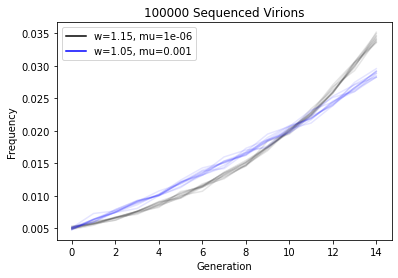

In [2]:
gens = 15
ps = 10 ** 8
ss = 10 ** 5
freq = 0.005
simulate_data(generations_number=gens, wt_freqs=freq*np.ones(10), population_size=ps, fitness=1.15, 
              mutation_rate=10**-6, 
              sequence_sample_size=ss, color='black', label=None, plot=True)
simulate_data(generations_number=gens, wt_freqs=freq*np.ones(10), population_size=ps, fitness=1.05, 
              mutation_rate=10**-3, 
              sequence_sample_size=ss, color='blue', label=None, plot=True)
plt.title(f'{ss} Sequenced Virions')

## 2. Comparing different methods

## 3. Effect of population size on inference

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=565, start_time=2021-03-22 12:57:05.304733, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega posterior


INFO:Epsilon:initial epsilon is 0.01069
INFO:ABC:t: 0, eps: 0.01069.
INFO:ABC:Acceptance rate: 1000 / 2054 = 4.8685e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.009694999999999997.
INFO:ABC:Acceptance rate: 1000 / 2146 = 4.6598e-01, ESS=9.4470e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=565, start_time=2021-03-22 12:57:05.304733, end_time=2021-03-22 12:57:22.723094)>


SMC run time:  17.48
Total number of SMC simulations:  5200


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=566, start_time=2021-03-22 12:57:23.966845, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.010579999999999999
INFO:ABC:t: 0, eps: 0.010579999999999999.
INFO:ABC:Acceptance rate: 1000 / 1951 = 5.1256e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.009699999999999999.
INFO:ABC:Acceptance rate: 1000 / 2130 = 4.6948e-01, ESS=9.6159e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=566, start_time=2021-03-22 12:57:23.966845, end_time=2021-03-22 12:57:34.510895)>


SMC run time:  10.6
Total number of SMC simulations:  5081


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=567, start_time=2021-03-22 12:57:35.881700, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.021249999999999998
INFO:ABC:t: 0, eps: 0.021249999999999998.
INFO:ABC:Acceptance rate: 1000 / 2085 = 4.7962e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.018984999999999988.
INFO:ABC:Acceptance rate: 1000 / 2121 = 4.7148e-01, ESS=9.4659e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=567, start_time=2021-03-22 12:57:35.881700, end_time=2021-03-22 12:57:47.683930)>


SMC run time:  11.84
Total number of SMC simulations:  5206


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=568, start_time=2021-03-22 12:57:49.063390, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Inferring from avgs


INFO:Epsilon:initial epsilon is 0.01065
INFO:ABC:t: 0, eps: 0.01065.
INFO:ABC:Acceptance rate: 1000 / 1983 = 5.0429e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.009754999999999996.
INFO:ABC:Acceptance rate: 1000 / 2130 = 4.6948e-01, ESS=9.5520e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=568, start_time=2021-03-22 12:57:49.063390, end_time=2021-03-22 12:58:01.377772)>


SMC run time:  12.35
Total number of SMC simulations:  5113


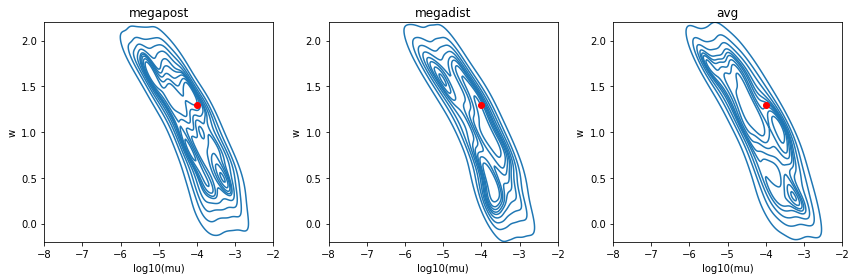

In [3]:
dfs = run_methods(10**-4, 1.3, 0.01, wt_freqs=[0,0])

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=569, start_time=2021-03-22 12:58:06.470408, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega posterior


INFO:Epsilon:initial epsilon is 0.011474999999999996
INFO:ABC:t: 0, eps: 0.011474999999999996.
INFO:ABC:Acceptance rate: 1000 / 2079 = 4.8100e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.010184999999999987.
INFO:ABC:Acceptance rate: 1000 / 2066 = 4.8403e-01, ESS=9.3782e+02.
INFO:ABC:t: 2, eps: 0.0077972428230082495.
INFO:ABC:Acceptance rate: 1000 / 2053 = 4.8709e-01, ESS=9.7140e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=569, start_time=2021-03-22 12:58:06.470408, end_time=2021-03-22 12:58:23.548951)>


SMC run time:  17.11
Total number of SMC simulations:  7198


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=570, start_time=2021-03-22 12:58:24.826658, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.39195999999999975
INFO:ABC:t: 0, eps: 0.39195999999999975.
INFO:ABC:Acceptance rate: 1000 / 1949 = 5.1308e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.3245749999999997.
INFO:ABC:Acceptance rate: 1000 / 2242 = 4.4603e-01, ESS=9.5990e+02.
INFO:ABC:t: 2, eps: 0.22021856505081777.
INFO:ABC:Acceptance rate: 1000 / 2050 = 4.8780e-01, ESS=9.6734e+02.
INFO:ABC:t: 3, eps: 0.1202121787482183.
INFO:ABC:Acceptance rate: 1000 / 2064 = 4.8450e-01, ESS=9.5124e+02.
INFO:ABC:t: 4, eps: 0.06745837825229795.
INFO:ABC:Acceptance rate: 1000 / 2062 = 4.8497e-01, ESS=9.3950e+02.
INFO:ABC:t: 5, eps: 0.03736266169167216.
INFO:ABC:Acceptance rate: 1000 / 2377 = 4.2070e-01, ESS=9.3498e+02.
INFO:ABC:t: 6, eps: 0.020854515719254858.
INFO:ABC:Acceptance rate: 1000 / 2473 = 4.0437e-01, ESS=9.2073e+02.
INFO

SMC run time:  52.24
Total number of SMC simulations:  21931


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=571, start_time=2021-03-22 12:59:18.278996, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.3998499999999999
INFO:ABC:t: 0, eps: 0.3998499999999999.
INFO:ABC:Acceptance rate: 1000 / 2081 = 4.8054e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.35288999999999987.
INFO:ABC:Acceptance rate: 1000 / 2071 = 4.8286e-01, ESS=9.3987e+02.
INFO:ABC:t: 2, eps: 0.24298473434715093.
INFO:ABC:Acceptance rate: 1000 / 2147 = 4.6577e-01, ESS=9.6961e+02.
INFO:ABC:t: 3, eps: 0.14371606698653772.
INFO:ABC:Acceptance rate: 1000 / 2056 = 4.8638e-01, ESS=9.6958e+02.
INFO:ABC:t: 4, eps: 0.0826818229153306.
INFO:ABC:Acceptance rate: 1000 / 2091 = 4.7824e-01, ESS=9.6865e+02.
INFO:ABC:t: 5, eps: 0.04769999999999999.
INFO:ABC:Acceptance rate: 1000 / 2061 = 4.8520e-01, ESS=9.6933e+02.
INFO:ABC:t: 6, eps: 0.030339999999999995.
INFO:ABC:Acceptance rate: 1000 / 2115 = 4.7281e-01, ESS=9.6759e+02.
INFO:ABC:t: 7, eps: 0.0228.
INFO:ABC:Acceptance rate: 1000 / 2091 = 4.7824e-01, ESS=9.6705e+02.
INFO:ABC:t: 8, eps: 0.01954062635840873.
INFO:ABC:Acceptance rate: 1000 / 2377 = 4.2070e-01

SMC run time:  51.38
Total number of SMC simulations:  20090


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=572, start_time=2021-03-22 13:00:10.999367, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Inferring from avgs


INFO:Epsilon:initial epsilon is 0.20056
INFO:ABC:t: 0, eps: 0.20056.
INFO:ABC:Acceptance rate: 1000 / 1972 = 5.0710e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.15916.
INFO:ABC:Acceptance rate: 1000 / 2197 = 4.5517e-01, ESS=9.4794e+02.
INFO:ABC:t: 2, eps: 0.09793956791210831.
INFO:ABC:Acceptance rate: 1000 / 2358 = 4.2409e-01, ESS=9.4885e+02.
INFO:ABC:t: 3, eps: 0.0602374475296574.
INFO:ABC:Acceptance rate: 1000 / 2236 = 4.4723e-01, ESS=9.6418e+02.
INFO:ABC:t: 4, eps: 0.033225000000000005.
INFO:ABC:Acceptance rate: 1000 / 2405 = 4.1580e-01, ESS=9.5512e+02.
INFO:ABC:t: 5, eps: 0.01899614922607578.
INFO:ABC:Acceptance rate: 1000 / 2439 = 4.1000e-01, ESS=9.4795e+02.
INFO:ABC:t: 6, eps: 0.010528220807339549.
INFO:ABC:Acceptance rate: 1000 / 2429 = 4.1169e-01, ESS=8.3290e+02.
INFO:ABC:t: 7, eps: 0.007613187148101195.
INFO:ABC:Acceptance rate: 1000 / 3083 = 3.2436e-01, ESS=8.3848e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=572, start_time=2021-03-22 13:00:10.999367, e

SMC run time:  46.6
Total number of SMC simulations:  20119


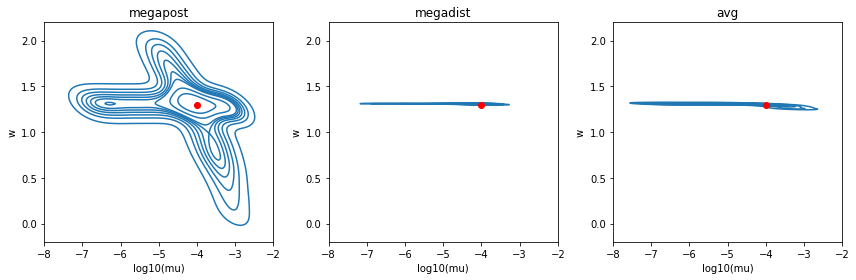

In [4]:
dfs = run_methods(10**-4, 1.3, 0.01, wt_freqs=[0,0.01])

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=552, start_time=2021-03-22 12:12:01.159827, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega posterior


INFO:Epsilon:initial epsilon is 0.01133
INFO:ABC:t: 0, eps: 0.01133.
INFO:ABC:Acceptance rate: 1000 / 1985 = 5.0378e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.010094999999999996.
INFO:ABC:Acceptance rate: 1000 / 2215 = 4.5147e-01, ESS=9.5807e+02.
INFO:ABC:t: 2, eps: 0.007921148690289183.
INFO:ABC:Acceptance rate: 1000 / 2021 = 4.9480e-01, ESS=9.7420e+02.
INFO:ABC:t: 3, eps: 0.005885680060209027.
INFO:ABC:Acceptance rate: 1000 / 2147 = 4.6577e-01, ESS=9.7732e+02.
INFO:ABC:t: 4, eps: 0.0043300000000000005.
INFO:ABC:Acceptance rate: 1000 / 1975 = 5.0633e-01, ESS=9.9312e+02.
INFO:ABC:t: 5, eps: 0.00327.
INFO:ABC:Acceptance rate: 1000 / 2009 = 4.9776e-01, ESS=9.8720e+02.
INFO:ABC:t: 6, eps: 0.00238.
INFO:ABC:Acceptance rate: 1000 / 2224 = 4.4964e-01, ESS=9.8436e+02.
INFO:ABC:t: 7, eps: 0.0017699999999999999.
INFO:ABC:Acceptance rate: 1000 / 2097 = 4.7687e-01, ESS=9.7357e+02.
INFO:ABC:t: 8, eps: 0.0013800000000000002.
INFO:ABC:Acceptance rate: 1000 / 2280 = 4.3860e-01, ESS=9.5032e+02.
INFO:A

SMC run time:  56.57
Total number of SMC simulations:  22704


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=553, start_time=2021-03-22 12:12:58.969227, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.050824999999999995
INFO:ABC:t: 0, eps: 0.050824999999999995.
INFO:ABC:Acceptance rate: 1000 / 2064 = 4.8450e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.040219999999999985.
INFO:ABC:Acceptance rate: 1000 / 2218 = 4.5086e-01, ESS=9.5394e+02.
INFO:ABC:t: 2, eps: 0.027347520344837006.
INFO:ABC:Acceptance rate: 1000 / 2336 = 4.2808e-01, ESS=9.7622e+02.
INFO:ABC:t: 3, eps: 0.017937212742963674.
INFO:ABC:Acceptance rate: 1000 / 2615 = 3.8241e-01, ESS=9.4719e+02.
INFO:ABC:t: 4, eps: 0.011362300780433694.
INFO:ABC:Acceptance rate: 1000 / 2260 = 4.4248e-01, ESS=9.7039e+02.
INFO:ABC:t: 5, eps: 0.00668.
INFO:ABC:Acceptance rate: 1000 / 2293 = 4.3611e-01, ESS=9.6012e+02.
INFO:ABC:t: 6, eps: 0.004244843764243859.
INFO:ABC:Acceptance rate: 1000 / 2280 = 4.3860e-01, ESS=9.0371e+02.
INFO:ABC

SMC run time:  61.79
Total number of SMC simulations:  32514


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=554, start_time=2021-03-22 12:14:01.974969, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.062325
INFO:ABC:t: 0, eps: 0.062325.
INFO:ABC:Acceptance rate: 1000 / 2152 = 4.6468e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.05190999999999999.
INFO:ABC:Acceptance rate: 1000 / 2177 = 4.5935e-01, ESS=9.5211e+02.
INFO:ABC:t: 2, eps: 0.040609959094459684.
INFO:ABC:Acceptance rate: 1000 / 2372 = 4.2159e-01, ESS=9.6825e+02.
INFO:ABC:t: 3, eps: 0.0289.
INFO:ABC:Acceptance rate: 1000 / 2213 = 4.5188e-01, ESS=9.6800e+02.
INFO:ABC:t: 4, eps: 0.02063.
INFO:ABC:Acceptance rate: 1000 / 2036 = 4.9116e-01, ESS=9.6900e+02.
INFO:ABC:t: 5, eps: 0.01583984127763859.
INFO:ABC:Acceptance rate: 1000 / 2175 = 4.5977e-01, ESS=9.6699e+02.
INFO:ABC:t: 6, eps: 0.013550000000000001.
INFO:ABC:Acceptance rate: 1000 / 2556 = 3.9124e-01, ESS=9.3678e+02.
INFO:ABC:t: 7, eps: 0.01117.
INFO:ABC:Acceptance rate: 1000 / 2428 = 4.1186e-01, ESS=9.6061e+02.
INFO:ABC:t: 8, eps: 0.008869999999999998.
INFO:ABC:Acceptance rate: 1000 / 1978 = 5.0556e-01, ESS=9.8519e+02.
INFO:ABC:t: 9, eps: 0.0

SMC run time:  61.1
Total number of SMC simulations:  23170


{'megapost': name           mu         w   weights
 id                                   
 3325353 -3.961406  1.298410  0.000799
 3325354 -4.064768  1.332454  0.001088
 3325355 -4.040587  1.333325  0.000942
 3325356 -4.003120  1.337636  0.000817
 3325357 -4.017757  1.328449  0.000704
 ...           ...       ...       ...
 3336349 -5.313033  1.313706  0.000778
 3336350 -5.259236  1.318042  0.000862
 3336351 -4.838820  1.315516  0.001011
 3336352 -6.576230  1.310909  0.001210
 3336353 -5.708169  1.313428  0.000938
 
 [2000 rows x 3 columns],
 'megadist': name           mu         w   weights
 id                                   
 3345355 -3.815866  1.259527  0.000936
 3345356 -4.029539  1.275764  0.000878
 3345357 -4.113144  1.283330  0.001058
 3345358 -3.940104  1.271429  0.000841
 3345359 -4.041891  1.270996  0.000902
 ...           ...       ...       ...
 3346350 -3.990198  1.268842  0.000845
 3346351 -4.006330  1.290174  0.001144
 3346352 -3.805653  1.237668  0.001149
 3346353 -3.

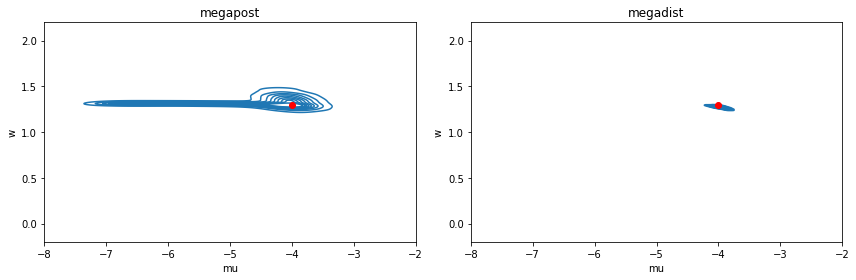

In [9]:
dfs = compare_methods(-4, 1.3, 0.001, stages=['megapost', 'megadist'], wt_freqs=[0,0.001])

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=431, start_time=2021-03-17 18:04:25.881715, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega posterior


INFO:Epsilon:initial epsilon is 0.01079
INFO:ABC:t: 0, eps: 0.01079.
INFO:ABC:Acceptance rate: 1000 / 1912 = 5.2301e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00984.
INFO:ABC:Acceptance rate: 1000 / 2098 = 4.7664e-01, ESS=9.6981e+02.
INFO:ABC:t: 2, eps: 0.007599999999999999.
INFO:ABC:Acceptance rate: 1000 / 2101 = 4.7596e-01, ESS=9.5886e+02.
INFO:ABC:t: 3, eps: 0.00594.
INFO:ABC:Acceptance rate: 1000 / 2103 = 4.7551e-01, ESS=9.7325e+02.
INFO:ABC:t: 4, eps: 0.004270589859519509.
INFO:ABC:Acceptance rate: 1000 / 2132 = 4.6904e-01, ESS=9.7863e+02.
INFO:ABC:t: 5, eps: 0.0032899999999999995.
INFO:ABC:Acceptance rate: 1000 / 2105 = 4.7506e-01, ESS=9.8701e+02.
INFO:ABC:t: 6, eps: 0.00249.
INFO:ABC:Acceptance rate: 1000 / 2070 = 4.8309e-01, ESS=9.8557e+02.
INFO:ABC:t: 7, eps: 0.0018900000000000002.
INFO:ABC:Acceptance rate: 1000 / 2200 = 4.5455e-01, ESS=9.8667e+02.
INFO:ABC:t: 8, eps: 0.0014800000000000002.
INFO:ABC:Acceptance rate: 1000 / 2334 = 4.2845e-01, ESS=9.6897e+02.
INFO:ABC:t: 9, eps:

SMC run time:  49.92
Total number of SMC simulations:  22673


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=432, start_time=2021-03-17 18:05:16.644069, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.01109
INFO:ABC:t: 0, eps: 0.01109.
INFO:ABC:Acceptance rate: 1000 / 2154 = 4.6425e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.009814999999999996.
INFO:ABC:Acceptance rate: 1000 / 2105 = 4.7506e-01, ESS=9.4193e+02.
INFO:ABC:t: 2, eps: 0.00773.
INFO:ABC:Acceptance rate: 1000 / 2023 = 4.9432e-01, ESS=9.7193e+02.
INFO:ABC:t: 3, eps: 0.005862186431804832.
INFO:ABC:Acceptance rate: 1000 / 2107 = 4.7461e-01, ESS=9.6026e+02.
INFO:ABC:t: 4, eps: 0.004321855642793042.
INFO:ABC:Acceptance rate: 1000 / 2059 = 4.8567e-01, ESS=9.9292e+02.
INFO:ABC:t: 5, eps: 0.0032500000000000003.
INFO:ABC:Acceptance rate: 1000 / 2073 = 4.8239e-01, ESS=9.7634e+02.
INFO:ABC:t: 6, eps: 0.00243.
INFO:ABC:Acceptance rate: 1000 / 2189 = 4.5683e-01, ESS=9.9081e+02.
INFO:ABC:t: 7, eps: 0.0018.
INFO:ABC:Acceptanc

SMC run time:  49.48
Total number of SMC simulations:  22648


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=433, start_time=2021-03-17 18:06:06.948677, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.021874999999999995
INFO:ABC:t: 0, eps: 0.021874999999999995.
INFO:ABC:Acceptance rate: 1000 / 2079 = 4.8100e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.019704999999999997.
INFO:ABC:Acceptance rate: 1000 / 2154 = 4.6425e-01, ESS=9.4493e+02.
INFO:ABC:t: 2, eps: 0.015179999999999999.
INFO:ABC:Acceptance rate: 1000 / 2107 = 4.7461e-01, ESS=9.8106e+02.
INFO:ABC:t: 3, eps: 0.011789748953648552.
INFO:ABC:Acceptance rate: 1000 / 2091 = 4.7824e-01, ESS=9.7923e+02.
INFO:ABC:t: 4, eps: 0.00866.
INFO:ABC:Acceptance rate: 1000 / 1984 = 5.0403e-01, ESS=9.8601e+02.
INFO:ABC:t: 5, eps: 0.0066019367996199806.
INFO:ABC:Acceptance rate: 1000 / 1899 = 5.2659e-01, ESS=9.8632e+02.
INFO:ABC:t: 6, eps: 0.004856415761299022.
INFO:ABC:Acceptance rate: 1000 / 2118 = 4.7214e-01, ESS=9.9152e+02.
INFO:ABC:t: 7, eps: 0.0035753813878353744.
INFO:ABC:Acceptance rate: 1000 / 2159 = 4.6318e-01, ESS=9.8467e+02.
INFO:ABC:t: 8, eps: 0.0027700000000000003.
INFO:ABC:Acceptance rate: 1000 / 22

SMC run time:  54.7
Total number of SMC simulations:  22109


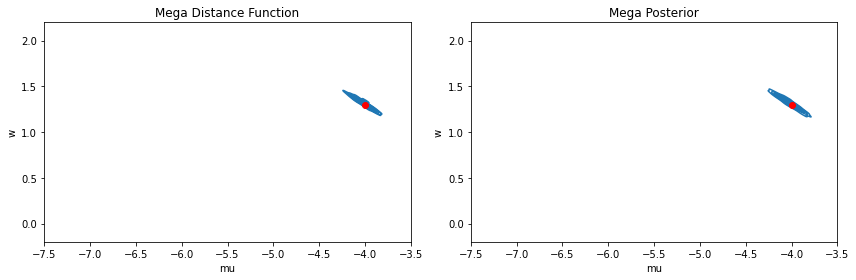

In [10]:
compare_methods(-4, 1.3, 0.001, data_size=2, infer_avg=False, wt_freqs=[0,0])

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=421, start_time=2021-03-17 15:16:13.277345, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega posterior


INFO:Epsilon:initial epsilon is 0.01107
INFO:ABC:t: 0, eps: 0.01107.
INFO:ABC:Acceptance rate: 1000 / 1927 = 5.1894e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.01019.
INFO:ABC:Acceptance rate: 1000 / 2076 = 4.8170e-01, ESS=9.4212e+02.
INFO:ABC:t: 2, eps: 0.007783075405824208.
INFO:ABC:Acceptance rate: 1000 / 2115 = 4.7281e-01, ESS=9.7373e+02.
INFO:ABC:t: 3, eps: 0.006012966021183578.
INFO:ABC:Acceptance rate: 1000 / 2053 = 4.8709e-01, ESS=9.6762e+02.
INFO:ABC:t: 4, eps: 0.0044399999999999995.
INFO:ABC:Acceptance rate: 1000 / 2043 = 4.8948e-01, ESS=9.7787e+02.
INFO:ABC:t: 5, eps: 0.00338495290892322.
INFO:ABC:Acceptance rate: 1000 / 2008 = 4.9801e-01, ESS=9.8694e+02.
INFO:ABC:t: 6, eps: 0.0024599999999999995.
INFO:ABC:Acceptance rate: 1000 / 2102 = 4.7574e-01, ESS=9.8548e+02.
INFO:ABC:t: 7, eps: 0.0018492975158709054.
INFO:ABC:Acceptance rate: 1000 / 2095 = 4.7733e-01, ESS=9.6810e+02.
INFO:ABC:t: 8, eps: 0.0014399999999999999.
INFO:ABC:Acceptance rate: 1000 / 2208 = 4.5290e-01, ESS=9.593

SMC run time:  47.35
Total number of SMC simulations:  22152


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=422, start_time=2021-03-17 15:17:01.540812, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 2.5143099999999974
INFO:ABC:t: 0, eps: 2.5143099999999974.
INFO:ABC:Acceptance rate: 1000 / 2138 = 4.6773e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 1.4441549999999983.
INFO:ABC:Acceptance rate: 1000 / 2033 = 4.9188e-01, ESS=9.6713e+02.
INFO:ABC:t: 2, eps: 0.7977016112437196.
INFO:ABC:Acceptance rate: 1000 / 2056 = 4.8638e-01, ESS=9.7700e+02.
INFO:ABC:t: 3, eps: 0.41064289008805904.
INFO:ABC:Acceptance rate: 1000 / 2045 = 4.8900e-01, ESS=9.7523e+02.
INFO:ABC:t: 4, eps: 0.2115551854206088.
INFO:ABC:Acceptance rate: 1000 / 2015 = 4.9628e-01, ESS=9.6316e+02.
INFO:ABC:t: 5, eps: 0.10767650597229593.
INFO:ABC:Acceptance rate: 1000 / 1996 = 5.0100e-01, ESS=9.3603e+02.
INFO:ABC:t: 6, eps: 0.05759000000000003.
INFO:ABC:Acceptance rate: 1000 / 1994 = 5.0150e-01, ESS=9.7495e+02.
INFO:ABC

SMC run time:  51.05
Total number of SMC simulations:  21671


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=423, start_time=2021-03-17 15:17:53.404225, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Inferring with mega distance function


INFO:Epsilon:initial epsilon is 3.0052949999999994
INFO:ABC:t: 0, eps: 3.0052949999999994.
INFO:ABC:Acceptance rate: 1000 / 2101 = 4.7596e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 1.5513399999999995.
INFO:ABC:Acceptance rate: 1000 / 1925 = 5.1948e-01, ESS=9.7136e+02.
INFO:ABC:t: 2, eps: 0.8663912128550895.
INFO:ABC:Acceptance rate: 1000 / 2028 = 4.9310e-01, ESS=9.6834e+02.
INFO:ABC:t: 3, eps: 0.4571301318675097.
INFO:ABC:Acceptance rate: 1000 / 2073 = 4.8239e-01, ESS=9.8636e+02.
INFO:ABC:t: 4, eps: 0.24794445273895493.
INFO:ABC:Acceptance rate: 1000 / 1984 = 5.0403e-01, ESS=9.5525e+02.
INFO:ABC:t: 5, eps: 0.1302503346013155.
INFO:ABC:Acceptance rate: 1000 / 2107 = 4.7461e-01, ESS=9.8059e+02.
INFO:ABC:t: 6, eps: 0.0784161934784693.
INFO:ABC:Acceptance rate: 1000 / 1907 = 5.2438e-01, ESS=9.7974e+02.
INFO:ABC:t: 7, eps: 0.046641525855513566.
INFO:ABC:Acceptance rate: 1000 / 2033 = 4.9188e-01, ESS=9.7009e+02.
INFO:ABC:t: 8, eps: 0.03288872172827649.
INFO:ABC:Acceptance rate: 1000 / 2036 = 4

SMC run time:  53.23
Total number of SMC simulations:  21572


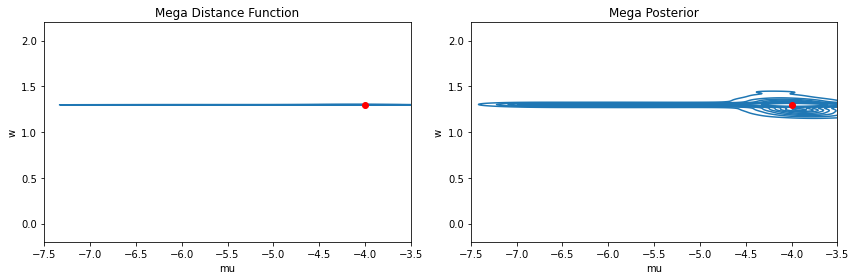

In [36]:
compare_methods(-4, 1.3, 0.001, data_size=2, infer_avg=False, wt_freqs=[0,0.3])

## How does population size effects accuracy?

Text(0.5, 1.0, '1000 Sequenced Virions')

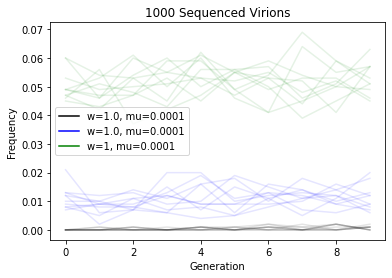

In [34]:
gens = 10
ps = 10 ** 8
mu = 10 ** -4
ss = 10 ** 3

simulate_data(generations_number=gens, wt_freqs=np.zeros(10), population_size=ps, fitness=1.0, mutation_rate=mu, 
              sequence_sample_size=ss, color='black', label=None, plot=True)
simulate_data(generations_number=gens, wt_freqs=0.01*np.ones(10), population_size=ps, fitness=1.0, mutation_rate=mu, 
              sequence_sample_size=ss, color='blue', label=None, plot=True)
simulate_data(generations_number=gens, wt_freqs=0.05*np.ones(10), population_size=ps, fitness=1, mutation_rate=mu, 
              sequence_sample_size=ss, color='green', label=None, plot=True)
plt.title(f'{ss} Sequenced Virions')

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=450, start_time=2021-03-18 13:52:00.456339, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega posterior


INFO:Epsilon:initial epsilon is 0.009300000000000001
INFO:ABC:t: 0, eps: 0.009300000000000001.
INFO:ABC:Acceptance rate: 1000 / 1452 = 6.8871e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.009000000000000001.
INFO:ABC:Acceptance rate: 1000 / 1997 = 5.0075e-01, ESS=9.5215e+02.
INFO:ABC:t: 2, eps: 0.0078.
INFO:ABC:Acceptance rate: 1000 / 2092 = 4.7801e-01, ESS=9.3008e+02.
INFO:ABC:t: 3, eps: 0.0062.
INFO:ABC:Acceptance rate: 1000 / 2077 = 4.8146e-01, ESS=9.4474e+02.
INFO:ABC:t: 4, eps: 0.0048000000000000004.
INFO:ABC:Acceptance rate: 1000 / 2116 = 4.7259e-01, ESS=9.3416e+02.
INFO:ABC:t: 5, eps: 0.0037999999999999996.
INFO:ABC:Acceptance rate: 1000 / 2235 = 4.4743e-01, ESS=8.9245e+02.
INFO:ABC:t: 6, eps: 0.0031000000000000003.
INFO:ABC:Acceptance rate: 1000 / 2707 = 3.6941e-01, ESS=7.6892e+02.
INFO:ABC:t: 7, eps: 0.0026000000000000007.
INFO:ABC:Acceptance rate: 1000 / 3904 = 2.5615e-01, ESS=7.7110e+02.
INFO:ABC:t: 8, eps: 0.0023.
INFO:ABC:Acceptance rate: 1000 / 5064 = 1.9747e-01, ESS=6.3624e

SMC run time:  61.08
Total number of SMC simulations:  33214


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=451, start_time=2021-03-18 13:53:02.485824, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.0502
INFO:ABC:t: 0, eps: 0.0502.
INFO:ABC:Acceptance rate: 1000 / 1941 = 5.1520e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0418.
INFO:ABC:Acceptance rate: 1000 / 2124 = 4.7081e-01, ESS=9.4020e+02.
INFO:ABC:t: 2, eps: 0.028800000000000003.
INFO:ABC:Acceptance rate: 1000 / 2313 = 4.3234e-01, ESS=9.6790e+02.
INFO:ABC:t: 3, eps: 0.0207.
INFO:ABC:Acceptance rate: 1000 / 2345 = 4.2644e-01, ESS=9.5915e+02.
INFO:ABC:t: 4, eps: 0.014499999999999999.
INFO:ABC:Acceptance rate: 1000 / 2257 = 4.4307e-01, ESS=9.6353e+02.
INFO:ABC:t: 5, eps: 0.0116.
INFO:ABC:Acceptance rate: 1000 / 2299 = 4.3497e-01, ESS=9.3468e+02.
INFO:ABC:t: 6, eps: 0.009999999999999998.
INFO:ABC:Acceptance rate: 1000 / 3145 = 3.1797e-01, ESS=8.9290e+02.
INFO:ABC:t: 7, eps: 0.008899999999999998.
INFO:ABC:Acceptance rat

SMC run time:  68.51
Total number of SMC simulations:  45257


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=452, start_time=2021-03-18 13:54:11.973884, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.0596
INFO:ABC:t: 0, eps: 0.0596.
INFO:ABC:Acceptance rate: 1000 / 1989 = 5.0277e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.05094999999999997.
INFO:ABC:Acceptance rate: 1000 / 2280 = 4.3860e-01, ESS=9.3778e+02.
INFO:ABC:t: 2, eps: 0.0411.
INFO:ABC:Acceptance rate: 1000 / 2343 = 4.2680e-01, ESS=9.5673e+02.
INFO:ABC:t: 3, eps: 0.029500000000000002.
INFO:ABC:Acceptance rate: 1000 / 2067 = 4.8379e-01, ESS=9.7039e+02.
INFO:ABC:t: 4, eps: 0.0217.
INFO:ABC:Acceptance rate: 1000 / 2175 = 4.5977e-01, ESS=9.6549e+02.
INFO:ABC:t: 5, eps: 0.0189.
INFO:ABC:Acceptance rate: 1000 / 2332 = 4.2882e-01, ESS=9.2960e+02.
INFO:ABC:t: 6, eps: 0.017099999999999997.
INFO:ABC:Acceptance rate: 1000 / 3027 = 3.3036e-01, ESS=8.3912e+02.
INFO:ABC:t: 7, eps: 0.015499999999999998.
INFO:ABC:Acceptance rate: 1000 / 3686 = 2.7130e-01, ESS=8.2446e+02.
INFO:ABC:t: 8, eps: 0.0141.
INFO:ABC:Acceptance rate: 1000 / 3764 = 2.6567e-01, ESS=7.9431e+02.
INFO:ABC:t: 9, eps: 0.013.
INFO:ABC:Accept

SMC run time:  56.65
Total number of SMC simulations:  29151


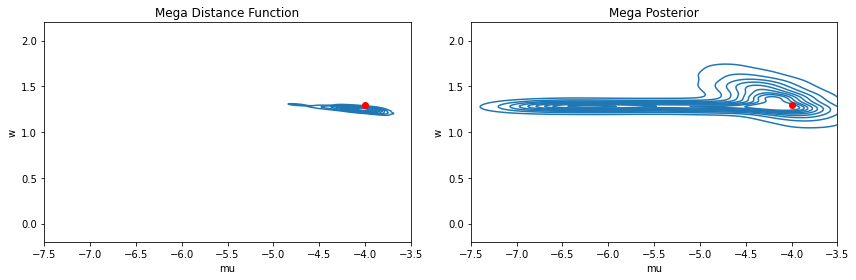

In [24]:
compare_methods(-4, 1.3, 0.001, data_size=2, infer_avg=False, wt_freqs=[0,0.001], sequence_sample_size=10**4)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=453, start_time=2021-03-18 13:55:11.948874, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega posterior


INFO:Epsilon:initial epsilon is 0.009000000000000001
INFO:ABC:t: 0, eps: 0.009000000000000001.
INFO:ABC:Acceptance rate: 1000 / 1563 = 6.3980e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.009000000000000001.
INFO:ABC:Acceptance rate: 1000 / 1093 = 9.1491e-01, ESS=9.2946e+02.
INFO:ABC:t: 2, eps: 0.009000000000000001.
INFO:ABC:Acceptance rate: 1000 / 1077 = 9.2851e-01, ESS=8.9816e+02.
INFO:ABC:t: 3, eps: 0.009000000000000001.
INFO:ABC:Acceptance rate: 1000 / 1108 = 9.0253e-01, ESS=9.1782e+02.
INFO:ABC:t: 4, eps: 0.009000000000000001.
INFO:ABC:Acceptance rate: 1000 / 1096 = 9.1241e-01, ESS=9.2224e+02.
INFO:ABC:t: 5, eps: 0.009000000000000001.
INFO:ABC:Acceptance rate: 1000 / 1089 = 9.1827e-01, ESS=8.5454e+02.
INFO:ABC:t: 6, eps: 0.009000000000000001.
INFO:ABC:Acceptance rate: 1000 / 1124 = 8.8968e-01, ESS=9.2685e+02.
INFO:ABC:t: 7, eps: 0.009000000000000001.
INFO:ABC:Acceptance rate: 1000 / 1106 = 9.0416e-01, ESS=9.1874e+02.
INFO:ABC:t: 8, eps: 0.009000000000000001.
INFO:ABC:Acceptance rate:

SMC run time:  44.68
Total number of SMC simulations:  12435


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=454, start_time=2021-03-18 13:55:57.532869, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.042
INFO:ABC:t: 0, eps: 0.042.
INFO:ABC:Acceptance rate: 1000 / 1934 = 5.1706e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.038.
INFO:ABC:Acceptance rate: 1000 / 2153 = 4.6447e-01, ESS=9.3303e+02.
INFO:ABC:t: 2, eps: 0.032.
INFO:ABC:Acceptance rate: 1000 / 2193 = 4.5600e-01, ESS=9.3877e+02.
INFO:ABC:t: 3, eps: 0.027.
INFO:ABC:Acceptance rate: 1000 / 2927 = 3.4165e-01, ESS=9.1445e+02.
INFO:ABC:t: 4, eps: 0.023.
INFO:ABC:Acceptance rate: 1000 / 3425 = 2.9197e-01, ESS=7.1019e+02.
INFO:ABC:t: 5, eps: 0.020000000000000004.
INFO:ABC:Acceptance rate: 1000 / 4958 = 2.0169e-01, ESS=7.1527e+02.
INFO:ABC:t: 6, eps: 0.018000000000000002.
INFO:ABC:Acceptance rate: 1000 / 6721 = 1.4879e-01, ESS=7.9158e+02.
INFO:ABC:t: 7, eps: 0.016.
INFO:ABC:Acceptance rate: 1000 / 10300 = 9.7087e-02, ESS=7

SMC run time:  94.73
Total number of SMC simulations:  78880


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=455, start_time=2021-03-18 13:57:33.203995, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.05199999999999999
INFO:ABC:t: 0, eps: 0.05199999999999999.
INFO:ABC:Acceptance rate: 1000 / 1856 = 5.3879e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.04800000000000001.
INFO:ABC:Acceptance rate: 1000 / 2205 = 4.5351e-01, ESS=9.5708e+02.
INFO:ABC:t: 2, eps: 0.042.
INFO:ABC:Acceptance rate: 1000 / 2307 = 4.3346e-01, ESS=9.3372e+02.
INFO:ABC:t: 3, eps: 0.036000000000000004.
INFO:ABC:Acceptance rate: 1000 / 2734 = 3.6576e-01, ESS=9.0411e+02.
INFO:ABC:t: 4, eps: 0.032.
INFO:ABC:Acceptance rate: 1000 / 2767 = 3.6140e-01, ESS=8.7914e+02.
INFO:ABC:t: 5, eps: 0.028999999999999998.
INFO:ABC:Acceptance rate: 1000 / 3693 = 2.7078e-01, ESS=8.7153e+02.
INFO:ABC:t: 6, eps: 0.026000000000000002.
INFO:ABC:Acceptance rate: 1000 / 5503 = 1.8172e-01, ESS=5.7026e+02.
INFO:ABC:t: 7, eps: 0.024.
INFO:ABC:Acceptance rate: 1000 / 9948 = 1.0052e-01, ESS=8.0909e+02.
INFO:ABC:t: 8, eps: 0.023.
INFO:ABC:Acceptance rate: 1000 / 12548 = 7.9694e-02, ESS=7.5232e+02.
INFO:ABC:t: 9, eps:

SMC run time:  82.44
Total number of SMC simulations:  65209


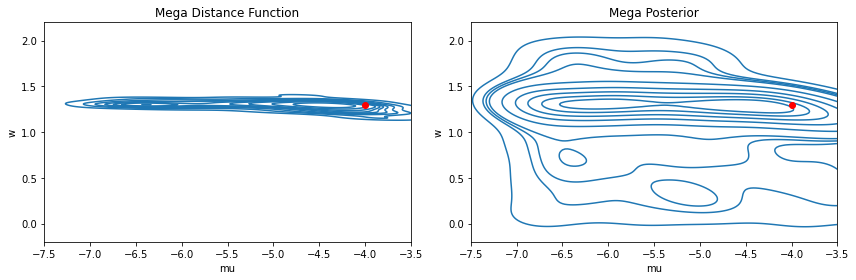

In [25]:
compare_methods(-4, 1.3, 0.001, data_size=2, infer_avg=False, wt_freqs=[0,0.001], model_ss=10**3, data_ss=10**3)

## but does the model care about sequence_sample_size?

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=456, start_time=2021-03-18 15:34:27.488755, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega posterior


INFO:Epsilon:initial epsilon is 0.010338
INFO:ABC:t: 0, eps: 0.010338.
INFO:ABC:Acceptance rate: 1000 / 2001 = 4.9975e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.009264.
INFO:ABC:Acceptance rate: 1000 / 2183 = 4.5809e-01, ESS=9.5278e+02.
INFO:ABC:t: 2, eps: 0.006960509762992088.
INFO:ABC:Acceptance rate: 1000 / 2118 = 4.7214e-01, ESS=9.6389e+02.
INFO:ABC:t: 3, eps: 0.0054258709381703775.
INFO:ABC:Acceptance rate: 1000 / 2157 = 4.6361e-01, ESS=9.8168e+02.
INFO:ABC:t: 4, eps: 0.004285112238821517.
INFO:ABC:Acceptance rate: 1000 / 1956 = 5.1125e-01, ESS=9.8412e+02.
INFO:ABC:t: 5, eps: 0.003406478227890457.
INFO:ABC:Acceptance rate: 1000 / 2055 = 4.8662e-01, ESS=9.9000e+02.
INFO:ABC:t: 6, eps: 0.0027329234540205308.
INFO:ABC:Acceptance rate: 1000 / 2059 = 4.8567e-01, ESS=9.8535e+02.
INFO:ABC:t: 7, eps: 0.00233107397093032.
INFO:ABC:Acceptance rate: 1000 / 2119 = 4.7192e-01, ESS=9.9048e+02.
INFO:ABC:t: 8, eps: 0.0021279999999999997.
INFO:ABC:Acceptance rate: 1000 / 2142 = 4.6685e-01, ESS=9.8

SMC run time:  49.03
Total number of SMC simulations:  22252


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=457, start_time=2021-03-18 15:35:17.451648, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.048945499999999996
INFO:ABC:t: 0, eps: 0.048945499999999996.
INFO:ABC:Acceptance rate: 1000 / 2039 = 4.9044e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0388435.
INFO:ABC:Acceptance rate: 1000 / 2162 = 4.6253e-01, ESS=9.4365e+02.
INFO:ABC:t: 2, eps: 0.026192789463218152.
INFO:ABC:Acceptance rate: 1000 / 2284 = 4.3783e-01, ESS=9.6041e+02.
INFO:ABC:t: 3, eps: 0.01732501073387721.
INFO:ABC:Acceptance rate: 1000 / 2807 = 3.5625e-01, ESS=9.7169e+02.
INFO:ABC:t: 4, eps: 0.010511354749680091.
INFO:ABC:Acceptance rate: 1000 / 2497 = 4.0048e-01, ESS=9.4068e+02.
INFO:ABC:t: 5, eps: 0.006946614635519285.
INFO:ABC:Acceptance rate: 1000 / 2747 = 3.6403e-01, ESS=9.2212e+02.
INFO:ABC:t: 6, eps: 0.005051898908100488.
INFO:ABC:Acceptance rate: 1000 / 2860 = 3.4965e-01, ESS=9.3923e+02.
INFO:AB

SMC run time:  61.37
Total number of SMC simulations:  34800


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=458, start_time=2021-03-18 15:36:19.737521, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.05996799999999999
INFO:ABC:t: 0, eps: 0.05996799999999999.
INFO:ABC:Acceptance rate: 1000 / 1875 = 5.3333e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.05053799999999995.
INFO:ABC:Acceptance rate: 1000 / 2149 = 4.6533e-01, ESS=9.6282e+02.
INFO:ABC:t: 2, eps: 0.0402207033052266.
INFO:ABC:Acceptance rate: 1000 / 2325 = 4.3011e-01, ESS=9.5912e+02.
INFO:ABC:t: 3, eps: 0.02875396630771651.
INFO:ABC:Acceptance rate: 1000 / 2328 = 4.2955e-01, ESS=9.7176e+02.
INFO:ABC:t: 4, eps: 0.02012358005328771.
INFO:ABC:Acceptance rate: 1000 / 2169 = 4.6104e-01, ESS=9.7764e+02.
INFO:ABC:t: 5, eps: 0.01572821918386669.
INFO:ABC:Acceptance rate: 1000 / 2329 = 4.2937e-01, ESS=9.6287e+02.
INFO:ABC:t: 6, eps: 0.0137596424501568.
INFO:ABC:Acceptance rate: 1000 / 2444 = 4.0917e-01, ESS=9.5175e+02.
INFO:ABC:t: 7, eps: 0.011280223462458395.
INFO:ABC:Acceptance rate: 1000 / 2279 = 4.3879e-01, ESS=9.7285e+02.
INFO:ABC:t: 8, eps: 0.0092331265783287.
INFO:ABC:Acceptance rate: 1000 / 2096

SMC run time:  51.24
Total number of SMC simulations:  23075


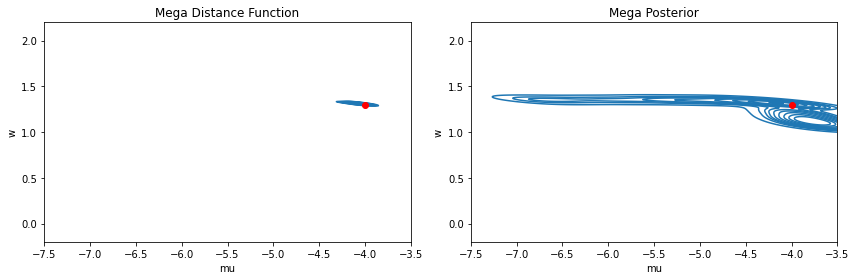

In [37]:
compare_methods(-4, 1.3, 0.001, data_size=2, infer_avg=False, wt_freqs=[0,0.001], model_ss=10**6, data_ss=10**4)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=459, start_time=2021-03-18 15:38:07.183342, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega posterior


INFO:Epsilon:initial epsilon is 0.010977
INFO:ABC:t: 0, eps: 0.010977.
INFO:ABC:Acceptance rate: 1000 / 2002 = 4.9950e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.010513.
INFO:ABC:Acceptance rate: 1000 / 2093 = 4.7778e-01, ESS=9.6023e+02.
INFO:ABC:t: 2, eps: 0.009293395235358324.
INFO:ABC:Acceptance rate: 1000 / 2074 = 4.8216e-01, ESS=9.6363e+02.
INFO:ABC:t: 3, eps: 0.007362349839562217.
INFO:ABC:Acceptance rate: 1000 / 2073 = 4.8239e-01, ESS=9.7679e+02.
INFO:ABC:t: 4, eps: 0.0058635897639628875.
INFO:ABC:Acceptance rate: 1000 / 2036 = 4.9116e-01, ESS=9.8056e+02.
INFO:ABC:t: 5, eps: 0.005093565596723656.
INFO:ABC:Acceptance rate: 1000 / 1979 = 5.0531e-01, ESS=9.8459e+02.
INFO:ABC:t: 6, eps: 0.0046192458103145465.
INFO:ABC:Acceptance rate: 1000 / 2135 = 4.6838e-01, ESS=9.9060e+02.
INFO:ABC:t: 7, eps: 0.004286.
INFO:ABC:Acceptance rate: 1000 / 2130 = 4.6948e-01, ESS=9.8569e+02.
INFO:ABC:t: 8, eps: 0.004083141640604441.
INFO:ABC:Acceptance rate: 1000 / 2285 = 4.3764e-01, ESS=9.5351e+02.
INF

SMC run time:  49.04
Total number of SMC simulations:  22305


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=460, start_time=2021-03-18 15:38:57.194025, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.05533099999999999
INFO:ABC:t: 0, eps: 0.05533099999999999.
INFO:ABC:Acceptance rate: 1000 / 2117 = 4.7237e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.04298299999999994.
INFO:ABC:Acceptance rate: 1000 / 2250 = 4.4444e-01, ESS=9.5627e+02.
INFO:ABC:t: 2, eps: 0.028643978983630036.
INFO:ABC:Acceptance rate: 1000 / 2535 = 3.9448e-01, ESS=9.6645e+02.
INFO:ABC:t: 3, eps: 0.02266683922708881.
INFO:ABC:Acceptance rate: 1000 / 3224 = 3.1017e-01, ESS=9.3610e+02.
INFO:ABC:t: 4, eps: 0.02015269298762786.
INFO:ABC:Acceptance rate: 1000 / 3960 = 2.5253e-01, ESS=8.5898e+02.
INFO:ABC:t: 5, eps: 0.018515745511928427.
INFO:ABC:Acceptance rate: 1000 / 4859 = 2.0580e-01, ESS=8.6228e+02.
INFO:ABC:t: 6, eps: 0.016689272952621237.
INFO:ABC:Acceptance rate: 1000 / 2256 = 4.4326e-01, ESS=9.7784e+02.


SMC run time:  58.05
Total number of SMC simulations:  29063


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=461, start_time=2021-03-18 15:39:56.180881, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.067118
INFO:ABC:t: 0, eps: 0.067118.
INFO:ABC:Acceptance rate: 1000 / 1999 = 5.0025e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.05839499999999997.
INFO:ABC:Acceptance rate: 1000 / 2253 = 4.4385e-01, ESS=9.4859e+02.
INFO:ABC:t: 2, eps: 0.04842589313727806.
INFO:ABC:Acceptance rate: 1000 / 2149 = 4.6533e-01, ESS=9.6680e+02.
INFO:ABC:t: 3, eps: 0.038140815823677676.
INFO:ABC:Acceptance rate: 1000 / 2237 = 4.4703e-01, ESS=9.7274e+02.
INFO:ABC:t: 4, eps: 0.03238618463739224.
INFO:ABC:Acceptance rate: 1000 / 2203 = 4.5393e-01, ESS=9.7210e+02.
INFO:ABC:t: 5, eps: 0.03050242322443649.
INFO:ABC:Acceptance rate: 1000 / 2443 = 4.0933e-01, ESS=9.1130e+02.
INFO:ABC:t: 6, eps: 0.028050354807102273.
INFO:ABC:Acceptance rate: 1000 / 2109 = 4.7416e-01, ESS=9.8545e+02.
INFO:ABC:t: 7, eps: 0.02615370723987757.
INFO:ABC:Acceptance rate: 1000 / 2049 = 4.8804e-01, ESS=9.9054e+02.
INFO:ABC:t: 8, eps: 0.024822732473109597.
INFO:ABC:Acceptance rate: 1000 / 1992 = 5.0201e-01, ES

SMC run time:  52.87
Total number of SMC simulations:  22444


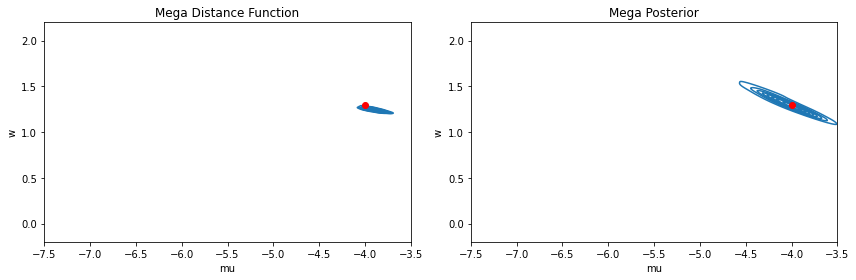

In [38]:
compare_methods(-4, 1.3, 0.001, data_size=2, infer_avg=False, wt_freqs=[0,0.001], model_ss=10**6, data_ss=10**3)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=462, start_time=2021-03-18 15:42:06.747289, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega posterior


INFO:Epsilon:initial epsilon is 0.020194
INFO:ABC:t: 0, eps: 0.020194.
INFO:ABC:Acceptance rate: 1000 / 1849 = 5.4083e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.020001.
INFO:ABC:Acceptance rate: 1000 / 2168 = 4.6125e-01, ESS=9.3969e+02.
INFO:ABC:t: 2, eps: 0.019878.
INFO:ABC:Acceptance rate: 1000 / 2272 = 4.4014e-01, ESS=9.2147e+02.
INFO:ABC:t: 3, eps: 0.01899176679088457.
INFO:ABC:Acceptance rate: 1000 / 2189 = 4.5683e-01, ESS=9.6489e+02.
INFO:ABC:t: 4, eps: 0.01696819215869979.
INFO:ABC:Acceptance rate: 1000 / 2196 = 4.5537e-01, ESS=9.7112e+02.
INFO:ABC:t: 5, eps: 0.014794928128401193.
INFO:ABC:Acceptance rate: 1000 / 1984 = 5.0403e-01, ESS=9.5877e+02.
INFO:ABC:t: 6, eps: 0.01313880889204402.
INFO:ABC:Acceptance rate: 1000 / 2091 = 4.7824e-01, ESS=9.6972e+02.
INFO:ABC:t: 7, eps: 0.01202114660308586.
INFO:ABC:Acceptance rate: 1000 / 2059 = 4.8567e-01, ESS=9.6700e+02.
INFO:ABC:t: 8, eps: 0.011280306941048616.
INFO:ABC:Acceptance rate: 1000 / 2153 = 4.6447e-01, ESS=9.6305e+02.
INFO:ABC:

SMC run time:  47.35
Total number of SMC simulations:  22111


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=463, start_time=2021-03-18 15:42:55.099636, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.05999699999999999
INFO:ABC:t: 0, eps: 0.05999699999999999.
INFO:ABC:Acceptance rate: 1000 / 2058 = 4.8591e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.059794.
INFO:ABC:Acceptance rate: 1000 / 2107 = 4.7461e-01, ESS=9.4282e+02.
INFO:ABC:t: 2, eps: 0.058515629577400675.
INFO:ABC:Acceptance rate: 1000 / 2144 = 4.6642e-01, ESS=9.4194e+02.
INFO:ABC:t: 3, eps: 0.05578831668847756.
INFO:ABC:Acceptance rate: 1000 / 2115 = 4.7281e-01, ESS=9.7091e+02.
INFO:ABC:t: 4, eps: 0.05327466758446089.
INFO:ABC:Acceptance rate: 1000 / 2009 = 4.9776e-01, ESS=9.7916e+02.
INFO:ABC:t: 5, eps: 0.05182573624547377.
INFO:ABC:Acceptance rate: 1000 / 1978 = 5.0556e-01, ESS=9.8072e+02.
INFO:ABC:t: 6, eps: 0.050975488166589006.
INFO:ABC:Acceptance rate: 1000 / 2068 = 4.8356e-01, ESS=9.8621e+02.
INFO:ABC:t: 

SMC run time:  50.64
Total number of SMC simulations:  22111


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=464, start_time=2021-03-18 15:43:46.770530, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.08005199999999998
INFO:ABC:t: 0, eps: 0.08005199999999998.
INFO:ABC:Acceptance rate: 1000 / 1938 = 5.1600e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.079969.
INFO:ABC:Acceptance rate: 1000 / 2136 = 4.6816e-01, ESS=9.1585e+02.
INFO:ABC:t: 2, eps: 0.07924654647598497.
INFO:ABC:Acceptance rate: 1000 / 2238 = 4.4683e-01, ESS=9.5301e+02.
INFO:ABC:t: 3, eps: 0.0762465909871413.
INFO:ABC:Acceptance rate: 1000 / 2260 = 4.4248e-01, ESS=9.6134e+02.
INFO:ABC:t: 4, eps: 0.07209483505431358.
INFO:ABC:Acceptance rate: 1000 / 2036 = 4.9116e-01, ESS=9.7019e+02.
INFO:ABC:t: 5, eps: 0.068498.
INFO:ABC:Acceptance rate: 1000 / 1982 = 5.0454e-01, ESS=9.6283e+02.
INFO:ABC:t: 6, eps: 0.06591240844201265.
INFO:ABC:Acceptance rate: 1000 / 2046 = 4.8876e-01, ESS=9.7712e+02.
INFO:ABC:t: 7, eps: 0.06427618678284003.
INFO:ABC:Acceptance rate: 1000 / 2034 = 4.9164e-01, ESS=9.7371e+02.
INFO:ABC:t: 8, eps: 0.06309215756840035.
INFO:ABC:Acceptance rate: 1000 / 2104 = 4.7529e-01, ESS=9.

SMC run time:  51.03
Total number of SMC simulations:  21917


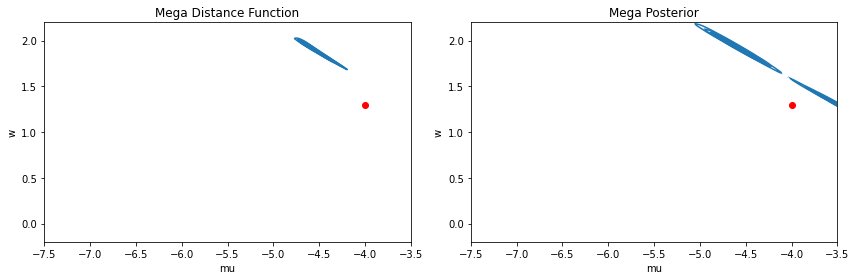

In [39]:
compare_methods(-4, 1.3, 0.001, data_size=2, infer_avg=False, wt_freqs=[0,0.001], model_ss=10**6, data_ss=10**2)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=488, start_time=2021-03-18 16:48:46.062264, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.01061
INFO:ABC:t: 0, eps: 0.01061.
INFO:ABC:Acceptance rate: 1000 / 1961 = 5.0994e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.009760000000000001.
INFO:ABC:Acceptance rate: 1000 / 2223 = 4.4984e-01, ESS=9.6082e+02.
INFO:ABC:t: 2, eps: 0.007665596483075281.
INFO:ABC:Acceptance rate: 1000 / 2059 = 4.8567e-01, ESS=9.6114e+02.
INFO:ABC:t: 3, eps: 0.005980163228195479.
INFO:ABC:Acceptance rate: 1000 / 2073 = 4.8239e-01, ESS=9.7706e+02.
INFO:ABC:t: 4, eps: 0.00439.
INFO:ABC:Acceptance rate: 1000 / 1949 = 5.1308e-01, ESS=9.8440e+02.
INFO:ABC:t: 5, eps: 0.0032500000000000003.
INFO:ABC:Acceptance rate: 1000 / 2042 = 4.8972e-01, ESS=9.9089e+02.
INFO:ABC:t: 6, eps: 0.002479999999999999.
INFO:ABC:Acceptance rate: 1000 / 1994 = 5.0150e-01, ESS=9.8678e+02.
INFO:ABC:t: 7, eps: 0.0019099999999999994.
INFO:ABC:Acceptance rate: 1000 / 2179 = 4.5893e-01, ESS=9.8108e+02.
INFO:ABC:t: 8, eps: 0.0015.
INFO:ABC:Acceptance rate: 1000 / 2349 = 4.2571e-01, ESS=9.3536e+02.
INFO:ABC

SMC run time:  53.98
Total number of SMC simulations:  22815


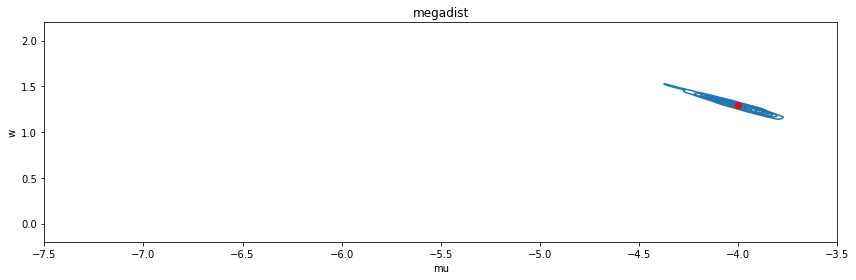

In [70]:
compare_methods(-4, 1.3, 0.001, data_size=2, stages=['megadist'], wt_freqs=[0], model_ss=10**5, data_ss=10**5)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=489, start_time=2021-03-18 16:49:42.022733, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.010780024999999999
INFO:ABC:t: 0, eps: 0.010780024999999999.
INFO:ABC:Acceptance rate: 1000 / 1941 = 5.1520e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00988043.
INFO:ABC:Acceptance rate: 1000 / 2091 = 4.7824e-01, ESS=9.3793e+02.
INFO:ABC:t: 2, eps: 0.007455703238047751.
INFO:ABC:Acceptance rate: 1000 / 2077 = 4.8146e-01, ESS=9.6156e+02.
INFO:ABC:t: 3, eps: 0.005972121970985944.
INFO:ABC:Acceptance rate: 1000 / 1993 = 5.0176e-01, ESS=9.7438e+02.
INFO:ABC:t: 4, eps: 0.004382135662066245.
INFO:ABC:Acceptance rate: 1000 / 2118 = 4.7214e-01, ESS=9.9296e+02.
INFO:ABC:t: 5, eps: 0.00330471218667325.
INFO:ABC:Acceptance rate: 1000 / 2079 = 4.8100e-01, ESS=9.8808e+02.
INFO:ABC:t: 6, eps: 0.0024303267816288424.
INFO:ABC:Acceptance rate: 1000 / 2103 = 4.7551e-01, ESS=9.9121e+02.
INFO:ABC:t: 7, eps: 0.0017565838952360593.
INFO:ABC:Acceptance rate: 1000 / 2021 = 4.9480e-01, ESS=9.8478e+02.
INFO:ABC:t: 8, eps: 0.0012788855801881907.
INFO:ABC:Acceptance rate: 1000 / 

SMC run time:  53.94
Total number of SMC simulations:  21474


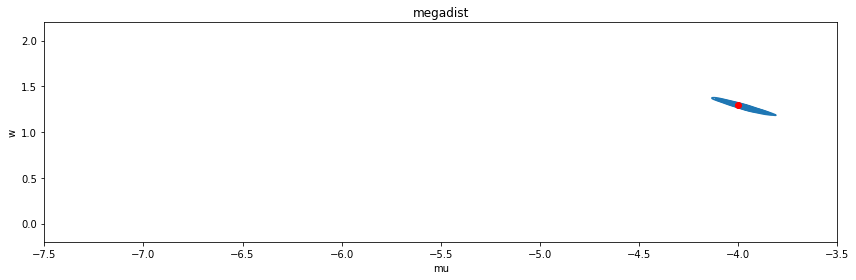

In [71]:
compare_methods(-4, 1.3, 0.001, stages=['megadist'], wt_freqs=[0], model_ss=10**8, data_ss=10**5)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=490, start_time=2021-03-18 16:50:37.896645, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.02
INFO:ABC:t: 0, eps: 0.02.
INFO:ABC:Acceptance rate: 1000 / 1462 = 6.8399e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.02.
INFO:ABC:Acceptance rate: 1000 / 1099 = 9.0992e-01, ESS=9.4832e+02.
INFO:ABC:t: 2, eps: 0.02.
INFO:ABC:Acceptance rate: 1000 / 1112 = 8.9928e-01, ESS=8.9385e+02.
INFO:ABC:t: 3, eps: 0.02.
INFO:ABC:Acceptance rate: 1000 / 1098 = 9.1075e-01, ESS=9.0848e+02.
INFO:ABC:t: 4, eps: 0.02.
INFO:ABC:Acceptance rate: 1000 / 1121 = 8.9206e-01, ESS=9.2860e+02.
INFO:ABC:t: 5, eps: 0.02.
INFO:ABC:Acceptance rate: 1000 / 1125 = 8.8889e-01, ESS=9.3555e+02.
INFO:ABC:t: 6, eps: 0.02.
INFO:ABC:Acceptance rate: 1000 / 1088 = 9.1912e-01, ESS=9.2897e+02.
INFO:ABC:t: 7, eps: 0.02.
INFO:ABC:Acceptance rate: 1000 / 1098 = 9.1075e-01, ESS=9.4950e+02.
INFO:ABC:t: 8, eps: 0.02.
INFO:ABC:Acceptance rate: 1000 / 1092 = 9.1575e-01, ESS=9.2581e+02.
INFO:ABC:t: 9, eps: 0.02.
INFO:ABC:Acceptance rate: 1000 / 1108 = 9.0253e-01, ESS=9.3209e+02.
INFO:History:Done <ABCS

SMC run time:  47.92
Total number of SMC simulations:  12403


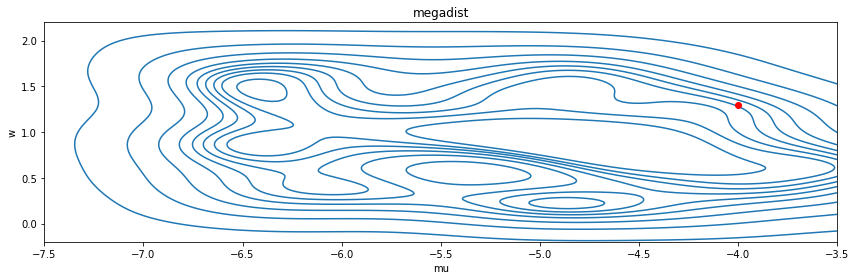

In [72]:
compare_methods(-4, 1.3, 0.001, stages=['megadist'], wt_freqs=[0], model_ss=10**3, data_ss=10**3)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=480, start_time=2021-03-18 16:09:18.425132, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.015928215
INFO:ABC:t: 0, eps: 0.015928215.
INFO:ABC:Acceptance rate: 1000 / 2079 = 4.8100e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.014982819999999996.
INFO:ABC:Acceptance rate: 1000 / 2159 = 4.6318e-01, ESS=9.5517e+02.
INFO:ABC:t: 2, eps: 0.012732658019096463.
INFO:ABC:Acceptance rate: 1000 / 2059 = 4.8567e-01, ESS=9.2338e+02.
INFO:ABC:t: 3, eps: 0.010117187724466138.
INFO:ABC:Acceptance rate: 1000 / 2050 = 4.8780e-01, ESS=9.7147e+02.
INFO:ABC:t: 4, eps: 0.007508297391173075.
INFO:ABC:Acceptance rate: 1000 / 2082 = 4.8031e-01, ESS=9.7265e+02.
INFO:ABC:t: 5, eps: 0.005970697630271077.
INFO:ABC:Acceptance rate: 1000 / 1881 = 5.3163e-01, ESS=9.9546e+02.
INFO:ABC:t: 6, eps: 0.0051464791902403936.
INFO:ABC:Acceptance rate: 1000 / 2014 = 4.9652e-01, ESS=9.8356e+02.
INFO:ABC:t: 7, eps: 0.004599982652081332.
INFO:ABC:Acceptance rate: 1000 / 2053 = 4.8709e-01, ESS=9.9020e+02.
INFO:ABC:t: 8, eps: 0.004263452645500641.
INFO:ABC:Acceptance rate: 1000 / 2102 = 4.

SMC run time:  53.58
Total number of SMC simulations:  21516


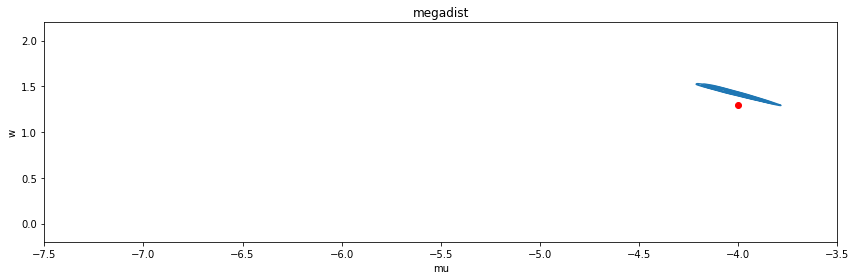

In [62]:
compare_methods(-4, 1.3, 0.001, stages=['megadist'], wt_freqs=[0], model_ss=10**8, data_ss=10**3)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=491, start_time=2021-03-18 16:51:27.817033, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.01172424999999999
INFO:ABC:t: 0, eps: 0.01172424999999999.
INFO:ABC:Acceptance rate: 1000 / 2073 = 4.8239e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.010089724999999999.
INFO:ABC:Acceptance rate: 1000 / 2097 = 4.7687e-01, ESS=9.5112e+02.
INFO:ABC:t: 2, eps: 0.010016021581853123.
INFO:ABC:Acceptance rate: 1000 / 2140 = 4.6729e-01, ESS=9.5721e+02.
INFO:ABC:t: 3, eps: 0.010005579999999998.
INFO:ABC:Acceptance rate: 1000 / 2135 = 4.6838e-01, ESS=9.3166e+02.
INFO:ABC:t: 4, eps: 0.01000268124055644.
INFO:ABC:Acceptance rate: 1000 / 2057 = 4.8614e-01, ESS=9.3796e+02.
INFO:ABC:t: 5, eps: 0.01000172.
INFO:ABC:Acceptance rate: 1000 / 2073 = 4.8239e-01, ESS=9.3008e+02.
INFO:ABC:t: 6, eps: 0.010001260000000001.
INFO:ABC:Acceptance rate: 1000 / 2217 = 4.5106e-01, ESS=9.4018e+02.
INFO:ABC:t: 7, eps: 0.01000102.
INFO:ABC:Acceptance rate: 1000 / 2509 = 3.9857e-01, ESS=8.8152e+02.
INFO:ABC:t: 8, eps: 0.010000879999999998.
INFO:ABC:Acceptance rate: 1000 / 3037 = 3.2927e-

SMC run time:  59.19
Total number of SMC simulations:  25566


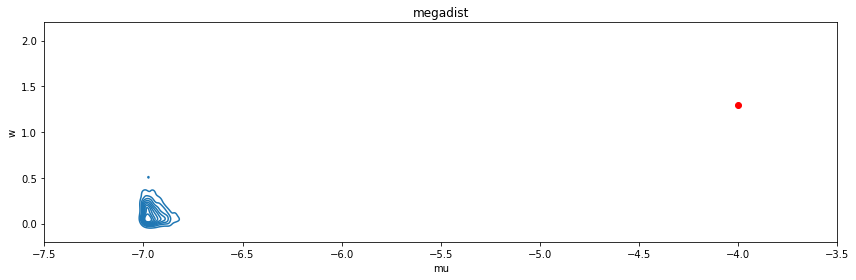

In [73]:
compare_methods(-4, 1.3, 0.0001, stages=['megadist'], wt_freqs=[0], model_ss=10**8, data_ss=10**2)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.000,0.000,0.001,0.000,0.000,0.002,0.002,0.002,0.004
1,0.0,0.000,0.000,0.000,0.001,0.001,0.001,0.004,0.001,0.002
2,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.001,0.003
3,0.0,0.000,0.000,0.000,0.000,0.001,0.003,0.003,0.004,0.003
4,0.0,0.000,0.002,0.001,0.001,0.002,0.000,0.000,0.003,0.005
5,0.0,0.001,0.000,0.000,0.001,0.001,0.002,0.005,0.000,0.004
6,0.0,0.000,0.000,0.000,0.000,0.000,0.002,0.005,0.003,0.000
7,0.0,0.000,0.000,0.000,0.000,0.001,0.002,0.002,0.002,0.002
8,0.0,0.000,0.000,0.001,0.001,0.001,0.001,0.002,0.007,0.005
9,0.0,0.000,0.000,0.000,0.000,0.001,0.001,0.001,0.001,0.004


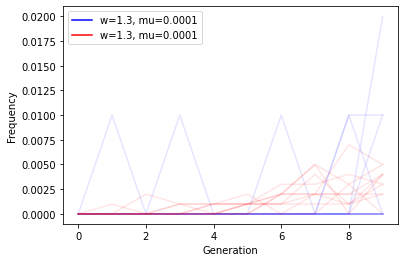

In [78]:
simulate_data(generations_number=10, wt_freqs=0 * np.ones(10), population_size=10**9, fitness=1.3, 
              mutation_rate=10**-4, 
              sequence_sample_size=10**2, color='blue', label=None, plot=True)
simulate_data(generations_number=10, wt_freqs=0 * np.ones(10), population_size=10**9, fitness=1.3, 
              mutation_rate=10**-4, 
              sequence_sample_size=10**3, color='red', label=None, plot=True)

## mu = -5

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=481, start_time=2021-03-18 16:34:37.032698, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.0017649999999999819
INFO:ABC:t: 0, eps: 0.0017649999999999819.
INFO:ABC:Acceptance rate: 1000 / 1860 = 5.3763e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0009400000000000001.
INFO:ABC:Acceptance rate: 1000 / 2046 = 4.8876e-01, ESS=9.6099e+02.
INFO:ABC:t: 2, eps: 0.00075.
INFO:ABC:Acceptance rate: 1000 / 1996 = 5.0100e-01, ESS=9.4170e+02.
INFO:ABC:t: 3, eps: 0.0005706874890274981.
INFO:ABC:Acceptance rate: 1000 / 2265 = 4.4150e-01, ESS=9.6566e+02.
INFO:ABC:t: 4, eps: 0.00047.
INFO:ABC:Acceptance rate: 1000 / 2076 = 4.8170e-01, ESS=9.5438e+02.
INFO:ABC:t: 5, eps: 0.00038.
INFO:ABC:Acceptance rate: 1000 / 2279 = 4.3879e-01, ESS=8.8871e+02.
INFO:ABC:t: 6, eps: 0.00032.
INFO:ABC:Acceptance rate: 1000 / 2724 = 3.6711e-01, ESS=7.5723e+02.
INFO:ABC:t: 7, eps: 0.00027.
INFO:ABC:Acceptance rate: 1000 / 3661 = 2.7315e-01, ESS=6.6204e+02.
INFO:ABC:t: 8, eps: 0.00023000000000000003.
INFO:ABC:Acceptance rate: 1000 / 5856 = 1.7077e-01, ESS=6.4725e+02.
INFO:ABC:t: 9, e

SMC run time:  65.55
Total number of SMC simulations:  34834


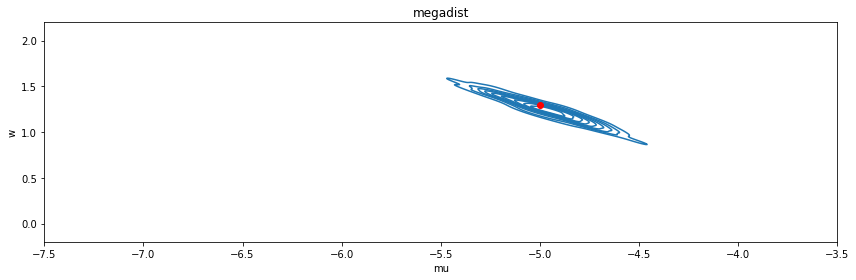

In [63]:
compare_methods(-5, 1.3, 0.0001, stages=['megadist'], wt_freqs=[0], model_ss=10**5, data_ss=10**5)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=484, start_time=2021-03-18 16:39:48.837375, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.00108
INFO:ABC:t: 0, eps: 0.00108.
INFO:ABC:Acceptance rate: 1000 / 1894 = 5.2798e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00097.
INFO:ABC:Acceptance rate: 1000 / 2039 = 4.9044e-01, ESS=9.3957e+02.
INFO:ABC:t: 2, eps: 0.0007700000000000001.
INFO:ABC:Acceptance rate: 1000 / 2090 = 4.7847e-01, ESS=9.6087e+02.
INFO:ABC:t: 3, eps: 0.0006000000000000001.
INFO:ABC:Acceptance rate: 1000 / 2130 = 4.6948e-01, ESS=9.6037e+02.
INFO:ABC:t: 4, eps: 0.00047000000000000004.
INFO:ABC:Acceptance rate: 1000 / 2155 = 4.6404e-01, ESS=9.2850e+02.
INFO:ABC:t: 5, eps: 0.0003800000000000001.
INFO:ABC:Acceptance rate: 1000 / 2626 = 3.8081e-01, ESS=9.1065e+02.
INFO:ABC:t: 6, eps: 0.00031000000000000005.
INFO:ABC:Acceptance rate: 1000 / 3243 = 3.0836e-01, ESS=7.6566e+02.
INFO:ABC:t: 7, eps: 0.00027.
INFO:ABC:Acceptance rate: 1000 / 4426 = 2.2594e-01, ESS=6.9779e+02.
INFO:ABC:t: 8, eps: 0.0002300000000000001.
INFO:ABC:Acceptance rate: 1000 / 7076 = 1.4132e-01, ESS=5.3244e+02.
I

SMC run time:  111.37
Total number of SMC simulations:  91924


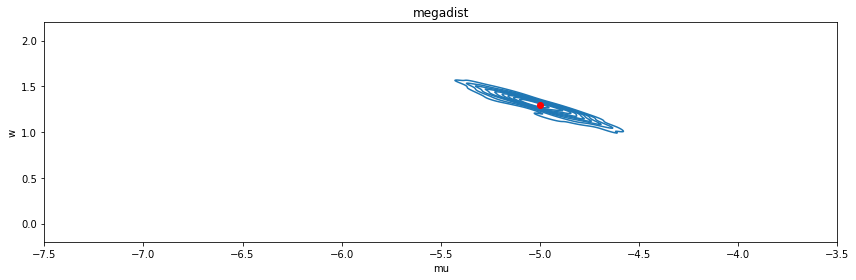

In [66]:
compare_methods(-5, 1.3, 0.0001, stages=['megadist'], wt_freqs=[0], model_ss=10**5, data_ss=10**5, max_episodes=12)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=482, start_time=2021-03-18 16:35:44.571872, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.0011196599999999896
INFO:ABC:t: 0, eps: 0.0011196599999999896.
INFO:ABC:Acceptance rate: 1000 / 1952 = 5.1230e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0009288949999999999.
INFO:ABC:Acceptance rate: 1000 / 2063 = 4.8473e-01, ESS=9.4794e+02.
INFO:ABC:t: 2, eps: 0.0007875372149956704.
INFO:ABC:Acceptance rate: 1000 / 1996 = 5.0100e-01, ESS=9.4172e+02.
INFO:ABC:t: 3, eps: 0.0006138431973540505.
INFO:ABC:Acceptance rate: 1000 / 2127 = 4.7015e-01, ESS=9.6243e+02.
INFO:ABC:t: 4, eps: 0.0004406600717233063.
INFO:ABC:Acceptance rate: 1000 / 1889 = 5.2938e-01, ESS=9.7038e+02.
INFO:ABC:t: 5, eps: 0.00032548803202448064.
INFO:ABC:Acceptance rate: 1000 / 2034 = 4.9164e-01, ESS=9.9086e+02.
INFO:ABC:t: 6, eps: 0.00027052.
INFO:ABC:Acceptance rate: 1000 / 2120 = 4.7170e-01, ESS=9.8540e+02.
INFO:ABC:t: 7, eps: 0.00023034811862603866.
INFO:ABC:Acceptance rate: 1000 / 2151 = 4.6490e-01, ESS=9.7895e+02.
INFO:ABC:t: 8, eps: 0.00020036798693869729.
INFO:ABC:Acceptance rat

SMC run time:  53.68
Total number of SMC simulations:  21787


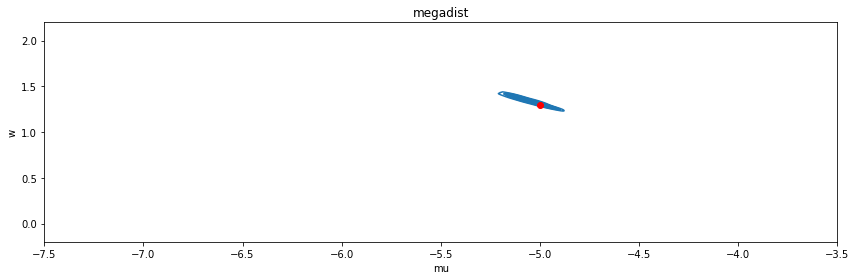

In [64]:
compare_methods(-5, 1.3, 0.0001, stages=['megadist'], wt_freqs=[0], model_ss=10**8, data_ss=10**5)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=485, start_time=2021-03-18 16:41:42.103329, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.0021
INFO:ABC:t: 0, eps: 0.0021.
INFO:ABC:Acceptance rate: 1000 / 1897 = 5.2715e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.002.
INFO:ABC:Acceptance rate: 1000 / 1894 = 5.2798e-01, ESS=9.3768e+02.
INFO:ABC:t: 2, eps: 0.0018.
INFO:ABC:Acceptance rate: 1000 / 2216 = 4.5126e-01, ESS=9.2481e+02.
INFO:ABC:t: 3, eps: 0.0015.
INFO:ABC:Acceptance rate: 1000 / 2386 = 4.1911e-01, ESS=8.8134e+02.
INFO:ABC:t: 4, eps: 0.0013.
INFO:ABC:Acceptance rate: 1000 / 2782 = 3.5945e-01, ESS=7.0511e+02.
INFO:ABC:t: 5, eps: 0.0011.
INFO:ABC:Acceptance rate: 1000 / 3773 = 2.6504e-01, ESS=7.9017e+02.
INFO:ABC:t: 6, eps: 0.001.
INFO:ABC:Acceptance rate: 1000 / 4102 = 2.4378e-01, ESS=7.6568e+02.
INFO:ABC:t: 7, eps: 0.0009.
INFO:ABC:Acceptance rate: 1000 / 6446 = 1.5513e-01, ESS=8.3638e+02.
INFO:ABC:t: 8, eps: 0.0007999999999999999.
INFO:ABC:Acceptance rate: 1000 / 10386 = 9.6283e-02, ESS=4.6211e+02.
INFO:ABC:t: 9, eps: 0.0007.
INFO:ABC:Acceptance rate: 1000 / 19071 = 5.2436e-02, ES

SMC run time:  76.78
Total number of SMC simulations:  55953


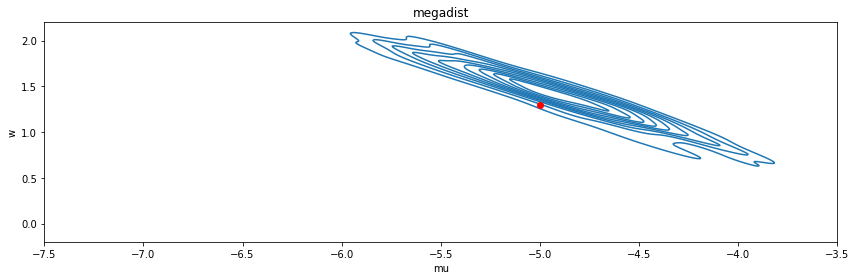

In [67]:
compare_methods(-5, 1.3, 0.0001, stages=['megadist'], wt_freqs=[0], model_ss=10**4, data_ss=10**4)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=483, start_time=2021-03-18 16:38:56.063274, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.0011997700000000002
INFO:ABC:t: 0, eps: 0.0011997700000000002.
INFO:ABC:Acceptance rate: 1000 / 2023 = 4.9432e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.001161715.
INFO:ABC:Acceptance rate: 1000 / 2070 = 4.8309e-01, ESS=9.4693e+02.
INFO:ABC:t: 2, eps: 0.0010454892665101665.
INFO:ABC:Acceptance rate: 1000 / 2081 = 4.8054e-01, ESS=9.6488e+02.
INFO:ABC:t: 3, eps: 0.0008922709422005047.
INFO:ABC:Acceptance rate: 1000 / 2083 = 4.8008e-01, ESS=9.6725e+02.
INFO:ABC:t: 4, eps: 0.000797518491241164.
INFO:ABC:Acceptance rate: 1000 / 2091 = 4.7824e-01, ESS=9.7964e+02.
INFO:ABC:t: 5, eps: 0.0007357248888949694.
INFO:ABC:Acceptance rate: 1000 / 2090 = 4.7847e-01, ESS=9.8010e+02.
INFO:ABC:t: 6, eps: 0.0007000422255547676.
INFO:ABC:Acceptance rate: 1000 / 2029 = 4.9285e-01, ESS=9.2459e+02.
INFO:ABC:t: 7, eps: 0.0006802493711363638.
INFO:ABC:Acceptance rate: 1000 / 2348 = 4.2589e-01, ESS=8.8538e+02.
INFO:ABC:t: 8, eps: 0.0006681607412276022.
INFO:ABC:Acceptance rate: 

SMC run time:  49.36
Total number of SMC simulations:  23693


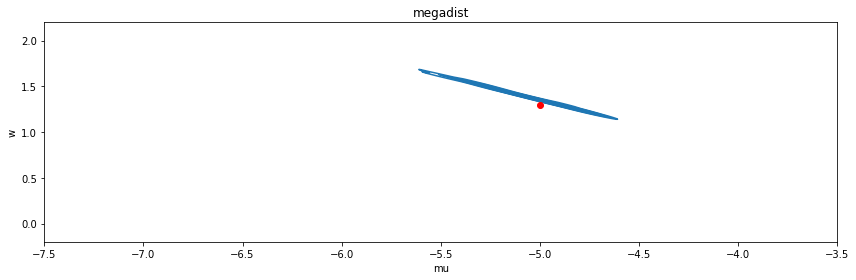

In [65]:
compare_methods(-5, 1.3, 0.0001, stages=['megadist'], wt_freqs=[0], model_ss=10**8, data_ss=10**4)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=486, start_time=2021-03-18 16:45:47.765889, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.0033036899999999963
INFO:ABC:t: 0, eps: 0.0033036899999999963.
INFO:ABC:Acceptance rate: 1000 / 2046 = 4.8876e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0020721949999999998.
INFO:ABC:Acceptance rate: 1000 / 2009 = 4.9776e-01, ESS=9.1485e+02.
INFO:ABC:t: 2, eps: 0.0020130091696672144.
INFO:ABC:Acceptance rate: 1000 / 2084 = 4.7985e-01, ESS=9.6261e+02.
INFO:ABC:t: 3, eps: 0.0020045113439562333.
INFO:ABC:Acceptance rate: 1000 / 2048 = 4.8828e-01, ESS=9.1157e+02.
INFO:ABC:t: 4, eps: 0.00200239.
INFO:ABC:Acceptance rate: 1000 / 2129 = 4.6970e-01, ESS=9.3489e+02.
INFO:ABC:t: 5, eps: 0.00200162.
INFO:ABC:Acceptance rate: 1000 / 2004 = 4.9900e-01, ESS=9.1146e+02.
INFO:ABC:t: 6, eps: 0.0020012200000000006.
INFO:ABC:Acceptance rate: 1000 / 2313 = 4.3234e-01, ESS=8.6987e+02.
INFO:ABC:t: 7, eps: 0.002001.
INFO:ABC:Acceptance rate: 1000 / 2536 = 3.9432e-01, ESS=9.1951e+02.
INFO:ABC:t: 8, eps: 0.00200087.
INFO:ABC:Acceptance rate: 1000 / 3089 = 3.2373e-01, ESS=6.806

SMC run time:  54.05
Total number of SMC simulations:  25525


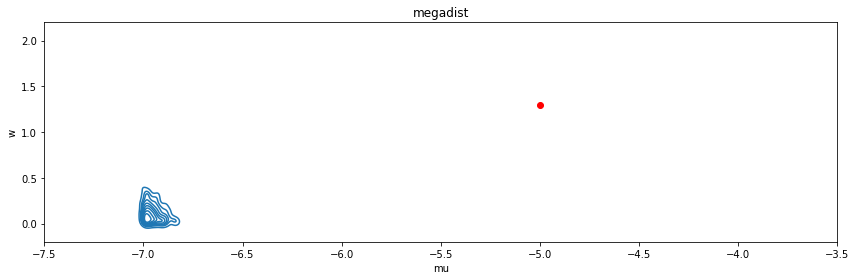

In [68]:
compare_methods(-5, 1.3, 0.0001, stages=['megadist'], wt_freqs=[0], model_ss=10**8, data_ss=10**3)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=492, start_time=2021-03-18 16:56:24.293353, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 2.5259893549999997
INFO:ABC:t: 0, eps: 2.5259893549999997.
INFO:ABC:Acceptance rate: 1000 / 1904 = 5.2521e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 1.7209863999999993.
INFO:ABC:Acceptance rate: 1000 / 1978 = 5.0556e-01, ESS=9.6500e+02.
INFO:ABC:t: 2, eps: 0.9655142509509461.
INFO:ABC:Acceptance rate: 1000 / 1926 = 5.1921e-01, ESS=9.7068e+02.
INFO:ABC:t: 3, eps: 0.46145731545868013.
INFO:ABC:Acceptance rate: 1000 / 2101 = 4.7596e-01, ESS=9.6054e+02.
INFO:ABC:t: 4, eps: 0.23330958317480016.
INFO:ABC:Acceptance rate: 1000 / 1945 = 5.1414e-01, ESS=9.6445e+02.
INFO:ABC:t: 5, eps: 0.1251298683259311.
INFO:ABC:Acceptance rate: 1000 / 1998 = 5.0050e-01, ESS=9.4334e+02.
INFO:ABC:t: 6, eps: 0.06828854422470013.
INFO:ABC:Acceptance rate: 1000 / 2163 = 4.6232e-01, ESS=9.6481e+02.
INFO:ABC:t: 7, eps: 0.04403612205104672.
INFO:ABC:Acceptance rate: 1000 / 2045 = 4.8900e-01, ESS=9.3799e+02.
INFO:ABC:t: 8, eps: 0.03257269954741649.
INFO:ABC:Acceptance rate: 1000 / 2129 = 

SMC run time:  49.9
Total number of SMC simulations:  21470


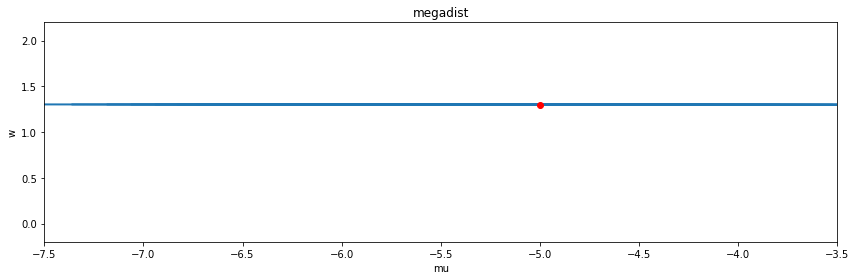

In [79]:
compare_methods(-5, 1.3, 0.001, stages=['megadist'], wt_freqs=[0.1], model_ss=10**8, data_ss=10**4)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=493, start_time=2021-03-18 16:58:19.327722, end_time=None)>


Creating dataset...
Inferring with mega distance function


INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 2.487281624999999
INFO:ABC:t: 0, eps: 2.487281624999999.
INFO:ABC:Acceptance rate: 1000 / 1930 = 5.1813e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 1.812958044999996.
INFO:ABC:Acceptance rate: 1000 / 1988 = 5.0302e-01, ESS=9.6742e+02.
INFO:ABC:t: 2, eps: 1.1286913137749466.
INFO:ABC:Acceptance rate: 1000 / 1968 = 5.0813e-01, ESS=9.4790e+02.
INFO:ABC:t: 3, eps: 0.706872228011098.
INFO:ABC:Acceptance rate: 1000 / 2022 = 4.9456e-01, ESS=9.5423e+02.
INFO:ABC:t: 4, eps: 0.6104761909603209.
INFO:ABC:Acceptance rate: 1000 / 1933 = 5.1733e-01, ESS=9.6499e+02.
INFO:ABC:t: 5, eps: 0.6011270607610082.
INFO:ABC:Acceptance rate: 1000 / 2221 = 4.5025e-01, ESS=9.7496e+02.
INFO:ABC:t: 6, eps: 0.5962993597725068.
INFO:ABC:Acceptance rate: 1000 / 2079 = 4.8100e-01, ESS=9.6380e+02.
INFO:ABC:t: 7, eps: 0.5940224604722081.
INFO:ABC:Acceptance rate: 1000 / 2119 = 4.7192e-01, ESS=9.6147e+02.
INFO:ABC:t: 8, eps: 0.5928039468926328.
INFO:ABC:

SMC run time:  48.66
Total number of SMC simulations:  21594


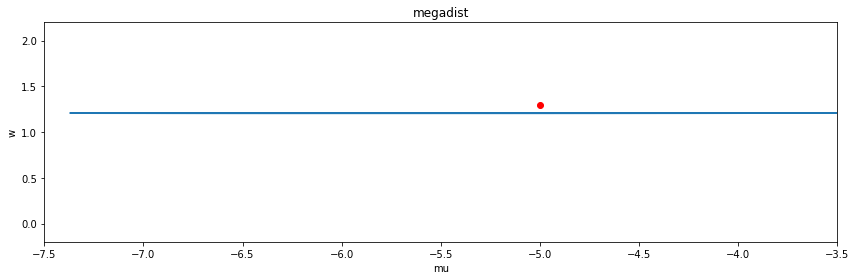

In [80]:
compare_methods(-5, 1.3, 0.001, stages=['megadist'], wt_freqs=[0.1], model_ss=10**8, data_ss=10**2)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=495, start_time=2021-03-18 17:01:41.253275, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.36634254
INFO:ABC:t: 0, eps: 0.36634254.
INFO:ABC:Acceptance rate: 1000 / 2072 = 4.8263e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.306501435.
INFO:ABC:Acceptance rate: 1000 / 2158 = 4.6339e-01, ESS=9.4560e+02.
INFO:ABC:t: 2, eps: 0.20390521056956507.
INFO:ABC:Acceptance rate: 1000 / 2124 = 4.7081e-01, ESS=9.7239e+02.
INFO:ABC:t: 3, eps: 0.12004140670401865.
INFO:ABC:Acceptance rate: 1000 / 2113 = 4.7326e-01, ESS=9.6547e+02.
INFO:ABC:t: 4, eps: 0.07177286582979366.
INFO:ABC:Acceptance rate: 1000 / 2172 = 4.6041e-01, ESS=9.5428e+02.
INFO:ABC:t: 5, eps: 0.0462352597979465.
INFO:ABC:Acceptance rate: 1000 / 2027 = 4.9334e-01, ESS=9.7938e+02.
INFO:ABC:t: 6, eps: 0.038349398291629574.
INFO:ABC:Acceptance rate: 1000 / 1998 = 5.0050e-01, ESS=9.4725e+02.
INFO:ABC:t: 7, eps: 0.0368736955432475.
INFO:ABC:Acceptance rate: 1000 / 2142 = 4.6685e-01, ESS=9.5829e+02.
INFO:ABC:t: 8, eps: 0.03651742531809266.
INFO:ABC:Acceptance rate: 1000 / 2160 = 4.6296e-01, ESS=9.5615

SMC run time:  49.65
Total number of SMC simulations:  22211


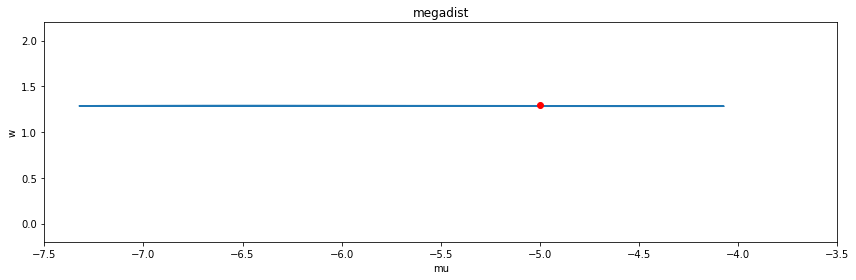

In [83]:
df = compare_methods(-5, 1.3, 0.001, stages=['megadist'], wt_freqs=[0.01], model_ss=10**8, data_ss=10**3)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=496, start_time=2021-03-18 17:03:56.732051, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.04808213499999999
INFO:ABC:t: 0, eps: 0.04808213499999999.
INFO:ABC:Acceptance rate: 1000 / 1888 = 5.2966e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.040132069999999964.
INFO:ABC:Acceptance rate: 1000 / 2201 = 4.5434e-01, ESS=9.3382e+02.
INFO:ABC:t: 2, eps: 0.027646627078440587.
INFO:ABC:Acceptance rate: 1000 / 2217 = 4.5106e-01, ESS=9.6435e+02.
INFO:ABC:t: 3, eps: 0.020515406521692165.
INFO:ABC:Acceptance rate: 1000 / 2698 = 3.7064e-01, ESS=9.5038e+02.
INFO:ABC:t: 4, eps: 0.015978936233676588.
INFO:ABC:Acceptance rate: 1000 / 2228 = 4.4883e-01, ESS=9.3374e+02.
INFO:ABC:t: 5, eps: 0.013873467974940169.
INFO:ABC:Acceptance rate: 1000 / 2084 = 4.7985e-01, ESS=9.7850e+02.
INFO:ABC:t: 6, eps: 0.013497427152632194.
INFO:ABC:Acceptance rate: 1000 / 2070 = 4.8309e-01, ESS=9.2806e+02.
INFO:ABC:t: 7, eps: 0.013457896361169872.
INFO:ABC:Acceptance rate: 1000 / 2778 = 3.5997e-01, ESS=9.3823e+02.
INFO:ABC:t: 8, eps: 0.013435784555209504.
INFO:ABC:Acceptance rate: 1

SMC run time:  53.98
Total number of SMC simulations:  31013


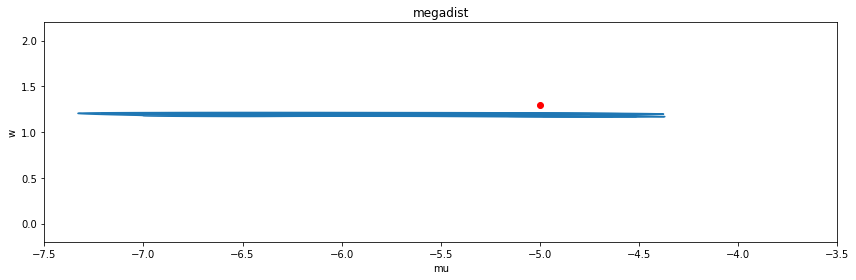

In [85]:
df = compare_methods(-5, 1.3, 0.001, stages=['megadist'], wt_freqs=[0.001], model_ss=10**8, data_ss=10**3)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=498, start_time=2021-03-18 17:06:22.025627, end_time=None)>


Creating dataset...
Inferring with mega distance function


INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.04182240999999999
INFO:ABC:t: 0, eps: 0.04182240999999999.
INFO:ABC:Acceptance rate: 1000 / 1968 = 5.0813e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.032513505.
INFO:ABC:Acceptance rate: 1000 / 2337 = 4.2790e-01, ESS=9.4268e+02.
INFO:ABC:t: 2, eps: 0.022498231540835727.
INFO:ABC:Acceptance rate: 1000 / 2238 = 4.4683e-01, ESS=9.7264e+02.
INFO:ABC:t: 3, eps: 0.014553816046796807.
INFO:ABC:Acceptance rate: 1000 / 2648 = 3.7764e-01, ESS=9.5840e+02.
INFO:ABC:t: 4, eps: 0.00842144491926566.
INFO:ABC:Acceptance rate: 1000 / 2306 = 4.3365e-01, ESS=9.7217e+02.
INFO:ABC:t: 5, eps: 0.004818084359598499.
INFO:ABC:Acceptance rate: 1000 / 2240 = 4.4643e-01, ESS=9.4474e+02.
INFO:ABC:t: 6, eps: 0.0028840134943070375.
INFO:ABC:Acceptance rate: 1000 / 2246 = 4.4524e-01, ESS=9.7859e+02.
INFO:ABC:t: 7, eps: 0.0019336811555020978.
INFO:ABC:Acceptance rate: 1000 / 2099 = 4.7642e-01, ESS=9.7258e+02.
INFO:ABC:t: 8, eps: 0.001573868969185

SMC run time:  53.61
Total number of SMC simulations:  23475


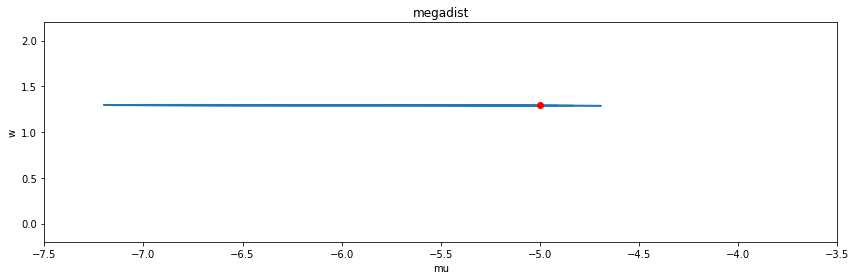

In [87]:
df = compare_methods(-5, 1.3, 0.001, stages=['megadist'], wt_freqs=[0.001], model_ss=10**8, data_ss=10**5)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=500, start_time=2021-03-18 17:08:24.866047, end_time=None)>


Creating dataset...
Inferring with mega distance function


INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.005220935
INFO:ABC:t: 0, eps: 0.005220935.
INFO:ABC:Acceptance rate: 1000 / 2110 = 4.7393e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0043132199999999996.
INFO:ABC:Acceptance rate: 1000 / 2259 = 4.4267e-01, ESS=9.4506e+02.
INFO:ABC:t: 2, eps: 0.002907543869663339.
INFO:ABC:Acceptance rate: 1000 / 2355 = 4.2463e-01, ESS=9.5996e+02.
INFO:ABC:t: 3, eps: 0.001998466696653958.
INFO:ABC:Acceptance rate: 1000 / 2728 = 3.6657e-01, ESS=9.5417e+02.
INFO:ABC:t: 4, eps: 0.00133365311506274.
INFO:ABC:Acceptance rate: 1000 / 2418 = 4.1356e-01, ESS=9.6942e+02.
INFO:ABC:t: 5, eps: 0.0009322438013248804.
INFO:ABC:Acceptance rate: 1000 / 2687 = 3.7216e-01, ESS=9.5440e+02.
INFO:ABC:t: 6, eps: 0.0007367992281232765.
INFO:ABC:Acceptance rate: 1000 / 2806 = 3.5638e-01, ESS=9.4052e+02.
INFO:ABC:t: 7, eps: 0.0006763.
INFO:ABC:Acceptance rate: 1000 / 3353 = 2.9824e-01, ESS=8.2960e+02.
INFO:ABC:t: 8, eps: 0.0006485985530856564.
INFO:ABC:Ac

SMC run time:  55.41
Total number of SMC simulations:  28978


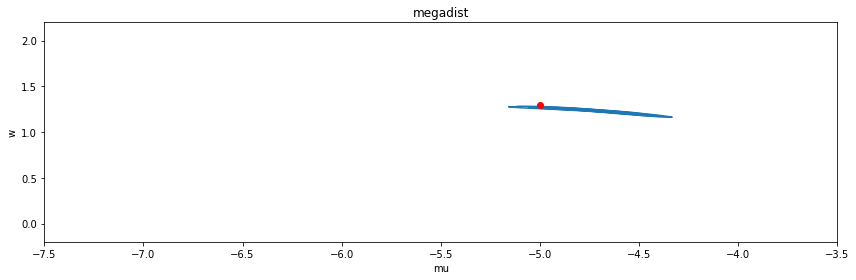

In [89]:
df = compare_methods(-5, 1.3, 0.0001, stages=['megadist'], wt_freqs=[0.0001], model_ss=10**8, data_ss=10**5)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.000,0.000,0.001,0.000,0.001,0.000,0.000,0.000,0.000
1,0.0,0.001,0.001,0.000,0.000,0.001,0.000,0.000,0.000,0.001
2,0.0,0.000,0.000,0.000,0.000,0.000,0.001,0.001,0.000,0.001
3,0.0,0.000,0.000,0.001,0.000,0.002,0.001,0.000,0.001,0.001
4,0.0,0.000,0.000,0.000,0.001,0.000,0.001,0.000,0.000,0.000
5,0.0,0.000,0.001,0.001,0.000,0.002,0.002,0.002,0.000,0.002
6,0.0,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.001,0.000
7,0.0,0.000,0.000,0.001,0.000,0.001,0.000,0.000,0.000,0.002
8,0.0,0.000,0.001,0.000,0.000,0.000,0.001,0.001,0.000,0.002
9,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.003


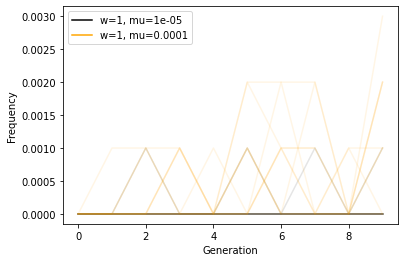

In [114]:
simulate_data(generations_number=10, wt_freqs=0 * np.ones(10), population_size=10**9, fitness=1, 
              mutation_rate=10**-5, 
              sequence_sample_size=10**3, color='black', label=None, plot=True)
simulate_data(generations_number=10, wt_freqs=0 * np.ones(10), population_size=10**9, fitness=1, 
              mutation_rate=10**-4, 
              sequence_sample_size=10**3, color='orange', label=None, plot=True)


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=507, start_time=2021-03-18 17:23:56.859457, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.122373735
INFO:ABC:t: 0, eps: 0.122373735.
INFO:ABC:Acceptance rate: 1000 / 2027 = 4.9334e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.11145828999999999.
INFO:ABC:Acceptance rate: 1000 / 2165 = 4.6189e-01, ESS=9.3555e+02.
INFO:ABC:t: 2, eps: 0.08787499178604216.
INFO:ABC:Acceptance rate: 1000 / 2086 = 4.7939e-01, ESS=9.5912e+02.
INFO:ABC:t: 3, eps: 0.06594056327449478.
INFO:ABC:Acceptance rate: 1000 / 2134 = 4.6860e-01, ESS=9.7123e+02.
INFO:ABC:t: 4, eps: 0.04706286533921119.
INFO:ABC:Acceptance rate: 1000 / 2006 = 4.9850e-01, ESS=9.9320e+02.
INFO:ABC:t: 5, eps: 0.03615663660190063.
INFO:ABC:Acceptance rate: 1000 / 2008 = 4.9801e-01, ESS=9.8414e+02.
INFO:ABC:t: 6, eps: 0.026830666780974094.
INFO:ABC:Acceptance rate: 1000 / 2008 = 4.9801e-01, ESS=9.8178e+02.
INFO:ABC:t: 7, eps: 0.020941693187431054.
INFO:ABC:Acceptance rate: 1000 / 2052 = 4.8733e-01, ESS=9.9032e+02.
INFO:ABC:t: 8, eps: 0.016910310207921036.
INFO:ABC:Acceptance rate: 1000 / 2126 = 4.7037e-

SMC run time:  48.5
Total number of SMC simulations:  21737


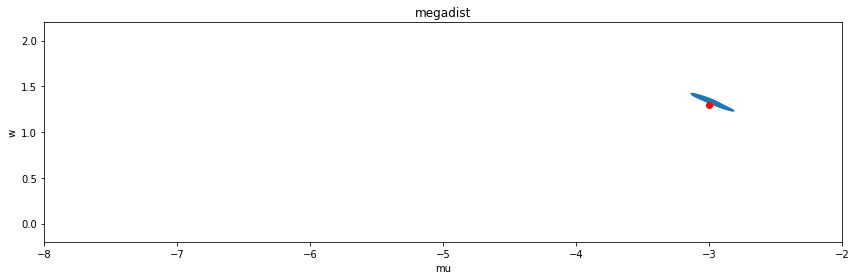

In [103]:
df = compare_methods(-3, 1.3, 0.001, stages=['megadist'], wt_freqs=[0.0001], model_ss=10**8, data_ss=10**3)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=508, start_time=2021-03-18 17:25:21.763472, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.002207059999999999
INFO:ABC:t: 0, eps: 0.002207059999999999.
INFO:ABC:Acceptance rate: 1000 / 2007 = 4.9826e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.001073465.
INFO:ABC:Acceptance rate: 1000 / 1977 = 5.0582e-01, ESS=9.3928e+02.
INFO:ABC:t: 2, eps: 0.001014706476327129.
INFO:ABC:Acceptance rate: 1000 / 2110 = 4.7393e-01, ESS=9.4835e+02.
INFO:ABC:t: 3, eps: 0.0010051555488978698.
INFO:ABC:Acceptance rate: 1000 / 2079 = 4.8100e-01, ESS=9.0672e+02.
INFO:ABC:t: 4, eps: 0.001002671342008066.
INFO:ABC:Acceptance rate: 1000 / 2050 = 4.8780e-01, ESS=8.8627e+02.
INFO:ABC:t: 5, eps: 0.00100169.
INFO:ABC:Acceptance rate: 1000 / 2244 = 4.4563e-01, ESS=9.3446e+02.
INFO:ABC:t: 6, eps: 0.0010012699999999999.
INFO:ABC:Acceptance rate: 1000 / 2239 = 4.4663e-01, ESS=9.3890e+02.
INFO:ABC:t: 7, eps: 0.0010010300000000002.
INFO:ABC:Acceptance rate: 1000 / 2476 = 4.0388e-01, ESS=8.4746e+02.
INFO:ABC:t: 8, eps: 0.0010008999999999999.
INFO:ABC:Acceptance rate: 1000 / 3129 = 

SMC run time:  53.16
Total number of SMC simulations:  25283


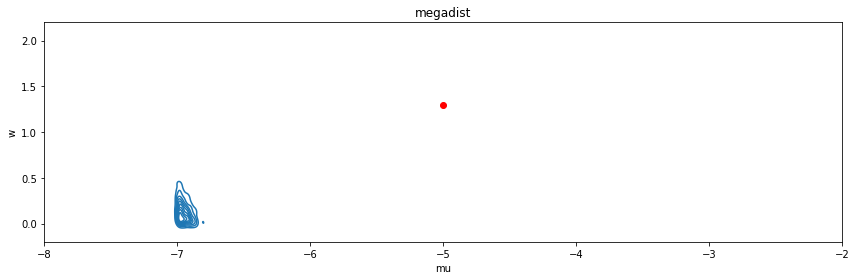

In [104]:
df = compare_methods(-5, 1.3, 0.001, stages=['megadist'], wt_freqs=[0], model_ss=10**8, data_ss=10**3)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=509, start_time=2021-03-18 17:29:19.535884, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.003
INFO:ABC:t: 0, eps: 0.003.
INFO:ABC:Acceptance rate: 1000 / 1992 = 5.0201e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.002.
INFO:ABC:Acceptance rate: 1000 / 1265 = 7.9051e-01, ESS=9.1383e+02.
INFO:ABC:t: 2, eps: 0.002.
INFO:ABC:Acceptance rate: 1000 / 1238 = 8.0775e-01, ESS=8.1670e+02.
INFO:ABC:t: 3, eps: 0.002.
INFO:ABC:Acceptance rate: 1000 / 1208 = 8.2781e-01, ESS=8.7552e+02.
INFO:ABC:t: 4, eps: 0.002.
INFO:ABC:Acceptance rate: 1000 / 1207 = 8.2850e-01, ESS=8.8369e+02.
INFO:ABC:t: 5, eps: 0.002.
INFO:ABC:Acceptance rate: 1000 / 1209 = 8.2713e-01, ESS=9.0094e+02.
INFO:ABC:t: 6, eps: 0.002.
INFO:ABC:Acceptance rate: 1000 / 1199 = 8.3403e-01, ESS=8.8573e+02.
INFO:ABC:t: 7, eps: 0.002.
INFO:ABC:Acceptance rate: 1000 / 1193 = 8.3822e-01, ESS=8.2366e+02.
INFO:ABC:t: 8, eps: 0.002.
INFO:ABC:Acceptance rate: 1000 / 1224 = 8.1699e-01, ESS=7.5918e+02.
INFO:ABC:t: 9, eps: 0.002.
INFO:ABC:Acceptance rate: 1000 / 1209 = 8.2713e-01, ESS=8.8107e+02.
INFO:History

SMC run time:  45.96
Total number of SMC simulations:  13944


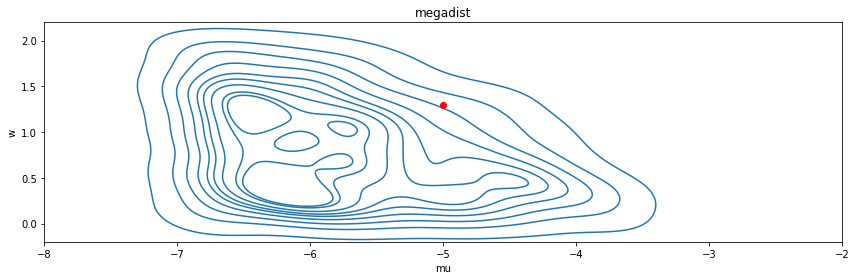

In [115]:
df = compare_methods(-5, 1.3, 0.001, stages=['megadist'], wt_freqs=[0], model_ss=10**3, data_ss=10**3)

INFO:Sampler:Parallelizing the sampling on 8 cores.


Creating dataset...
Inferring with mega distance function


INFO:History:Start <ABCSMC(id=510, start_time=2021-03-18 17:30:46.912139, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.00269
INFO:ABC:t: 0, eps: 0.00269.
INFO:ABC:Acceptance rate: 1000 / 1901 = 5.2604e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00113.
INFO:ABC:Acceptance rate: 1000 / 1344 = 7.4405e-01, ESS=9.1696e+02.
INFO:ABC:t: 2, eps: 0.00113.
INFO:ABC:Acceptance rate: 1000 / 1206 = 8.2919e-01, ESS=8.8641e+02.
INFO:ABC:t: 3, eps: 0.00113.
INFO:ABC:Acceptance rate: 1000 / 1181 = 8.4674e-01, ESS=8.9786e+02.
INFO:ABC:t: 4, eps: 0.00113.
INFO:ABC:Acceptance rate: 1000 / 1171 = 8.5397e-01, ESS=7.7958e+02.
INFO:ABC:t: 5, eps: 0.00113.
INFO:ABC:Acceptance rate: 1000 / 1195 = 8.3682e-01, ESS=8.0099e+02.
INFO:ABC:t: 6, eps: 0.00113.
INFO:ABC:Acceptance rate: 1000 / 1198 = 8.3472e-01, ESS=8.4012e+02.
INFO:ABC:t: 7, eps: 0.00113.
INFO:ABC:Acceptance rate: 1000 / 1254 = 7.9745e-01, ESS=8.5396e+02.
INFO:ABC:t: 8, eps: 0.00113.
INFO:ABC:Acceptance rate:

SMC run time:  43.89
Total number of SMC simulations:  13876


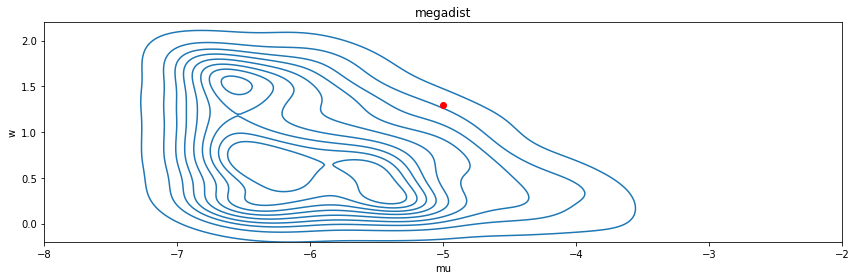

In [116]:
df = compare_methods(-5, 1.3, 0.001, stages=['megadist'], wt_freqs=[0], model_ss=10**3, data_ss=10**5)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=512, start_time=2021-03-18 17:31:57.754594, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.002429999999999978
INFO:ABC:t: 0, eps: 0.002429999999999978.
INFO:ABC:Acceptance rate: 1000 / 2002 = 4.9950e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00106.
INFO:ABC:Acceptance rate: 1000 / 1346 = 7.4294e-01, ESS=9.5292e+02.
INFO:ABC:t: 2, eps: 0.00106.
INFO:ABC:Acceptance rate: 1000 / 1180 = 8.4746e-01, ESS=7.7887e+02.
INFO:ABC:t: 3, eps: 0.00106.
INFO:ABC:Acceptance rate: 1000 / 1185 = 8.4388e-01, ESS=8.5031e+02.
INFO:ABC:t: 4, eps: 0.00106.
INFO:ABC:Acceptance rate: 1000 / 1225 = 8.1633e-01, ESS=8.5568e+02.
INFO:ABC:t: 5, eps: 0.00106.
INFO:ABC:Acceptance rate: 1000 / 1208 = 8.2781e-01, ESS=8.6177e+02.
INFO:ABC:t: 6, eps: 0.00106.
INFO:ABC:Acceptance rate: 1000 / 1221 = 8.1900e-01, ESS=7.8055e+02.
INFO:ABC:t: 7, eps: 0.00106.
INFO:ABC:Acceptance rate: 1000 / 1228 = 8.1433e-01, ESS=8.7642e+02.
INFO:ABC:t: 8, eps: 0.00106.
INFO:ABC:Acceptance rate: 1000 / 1191 = 8.3963e-01, ESS=8.8409e+02.
INFO:ABC:t: 9, eps: 0.00106.
INFO:ABC:Acceptance rate: 1000 /

SMC run time:  47.78
Total number of SMC simulations:  13965


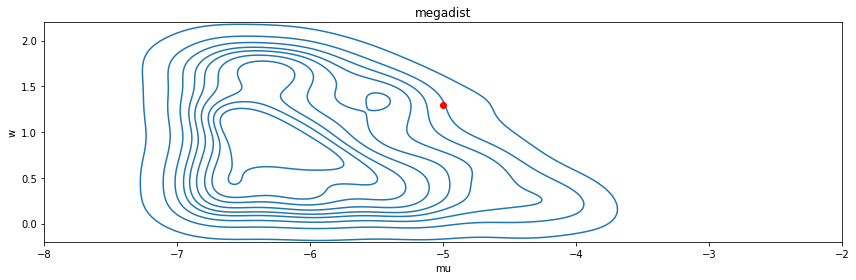

In [118]:
df = compare_methods(-5, 1.3, 0.001, stages=['megadist'], wt_freqs=[0], model_ss=10**3, data_ss=10**5)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=515, start_time=2021-03-18 17:35:14.557917, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.0011099999999999999
INFO:ABC:t: 0, eps: 0.0011099999999999999.
INFO:ABC:Acceptance rate: 1000 / 1994 = 5.0150e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00102.
INFO:ABC:Acceptance rate: 1000 / 2032 = 4.9213e-01, ESS=9.4955e+02.
INFO:ABC:t: 2, eps: 0.0008300000000000001.
INFO:ABC:Acceptance rate: 1000 / 2102 = 4.7574e-01, ESS=9.5657e+02.
INFO:ABC:t: 3, eps: 0.0006467516215437376.
INFO:ABC:Acceptance rate: 1000 / 2121 = 4.7148e-01, ESS=9.4605e+02.
INFO:ABC:t: 4, eps: 0.0004999999999999999.
INFO:ABC:Acceptance rate: 1000 / 2178 = 4.5914e-01, ESS=9.4434e+02.
INFO:ABC:t: 5, eps: 0.00039000000000000005.
INFO:ABC:Acceptance rate: 1000 / 2433 = 4.1102e-01, ESS=9.1261e+02.
INFO:ABC:t: 6, eps: 0.00033792299132444565.
INFO:ABC:Acceptance rate: 1000 / 3172 = 3.1526e-01, ESS=7.3495e+02.
INFO:ABC:t: 7, eps: 0.00029.
INFO:ABC:Acceptance rate: 1000 / 4403 = 2.2712e-01, ESS=7.8601e+02.
INFO:ABC:t: 8, eps: 0.00026.
INFO:ABC:Acceptance rate: 1000 / 6407 = 1.5608e-01, ESS

SMC run time:  60.08
Total number of SMC simulations:  38542


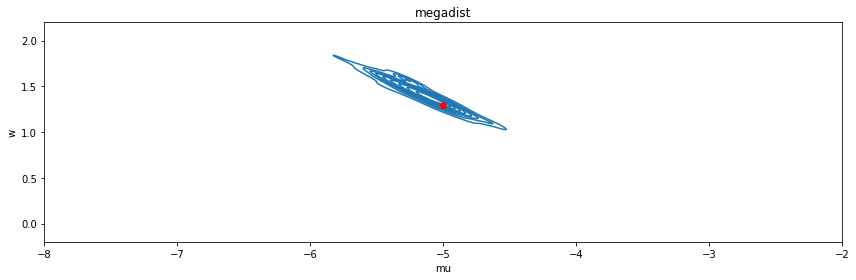

In [121]:
df = compare_methods(-5, 1.3, 0.0001, stages=['megadist'], wt_freqs=[0], model_ss=10**5, data_ss=10**5)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=514, start_time=2021-03-18 17:33:33.009071, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.0011241449999999898
INFO:ABC:t: 0, eps: 0.0011241449999999898.
INFO:ABC:Acceptance rate: 1000 / 2032 = 4.9213e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0009642699999999999.
INFO:ABC:Acceptance rate: 1000 / 2066 = 4.8403e-01, ESS=9.4574e+02.
INFO:ABC:t: 2, eps: 0.0007822755053000433.
INFO:ABC:Acceptance rate: 1000 / 2054 = 4.8685e-01, ESS=9.7337e+02.
INFO:ABC:t: 3, eps: 0.0005997355586278042.
INFO:ABC:Acceptance rate: 1000 / 2100 = 4.7619e-01, ESS=9.4876e+02.
INFO:ABC:t: 4, eps: 0.0004426362330548173.
INFO:ABC:Acceptance rate: 1000 / 2050 = 4.8780e-01, ESS=9.8873e+02.
INFO:ABC:t: 5, eps: 0.0003514762639095759.
INFO:ABC:Acceptance rate: 1000 / 2087 = 4.7916e-01, ESS=9.8618e+02.
INFO:ABC:t: 6, eps: 0.0002800872042594858.
INFO:ABC:Acceptance rate: 1000 / 2145 = 4.6620e-01, ESS=9.8752e+02.
INFO:ABC:t: 7, eps: 0.00024413484392640523.
INFO:ABC:Acceptance rate: 1000 / 2065 = 4.8426e-01, ESS=9.7746e+02.
INFO:ABC:t: 8, eps: 0.00022417434205459336.
INFO:ABC:Acce

SMC run time:  48.88
Total number of SMC simulations:  22193


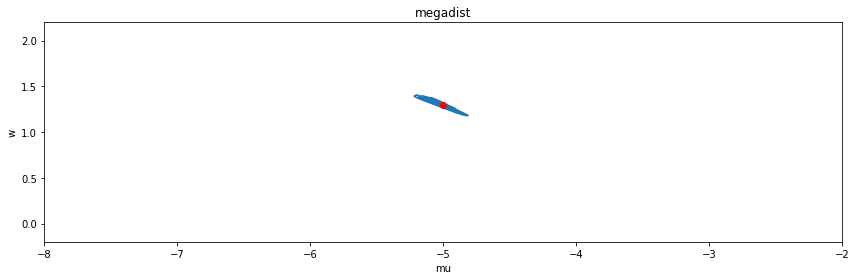

In [120]:
df = compare_methods(-5, 1.3, 0.0001, stages=['megadist'], wt_freqs=[0], model_ss=10**8, data_ss=10**5)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=519, start_time=2021-03-18 17:45:26.735465, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.09074499999999996
INFO:ABC:t: 0, eps: 0.09074499999999996.
INFO:ABC:Acceptance rate: 1000 / 1890 = 5.2910e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.07252499999999996.
INFO:ABC:Acceptance rate: 1000 / 2140 = 4.6729e-01, ESS=9.4217e+02.
INFO:ABC:t: 2, eps: 0.04512193081287805.
INFO:ABC:Acceptance rate: 1000 / 2161 = 4.6275e-01, ESS=9.4514e+02.
INFO:ABC:t: 3, eps: 0.024716416947211134.
INFO:ABC:Acceptance rate: 1000 / 2569 = 3.8926e-01, ESS=8.8791e+02.
INFO:ABC:t: 4, eps: 0.012967335483208662.
INFO:ABC:Acceptance rate: 1000 / 4357 = 2.2952e-01, ESS=9.0552e+02.
INFO:ABC:t: 5, eps: 0.00709825533221944.
INFO:ABC:Acceptance rate: 1000 / 7712 = 1.2967e-01, ESS=7.5459e+02.
INFO:ABC:t: 6, eps: 0.00474.
INFO:ABC:Acceptance rate: 1000 / 17395 = 5.7488e-02, ESS=8.7389e+02.
INFO:ABC:t: 7, eps: 0.0037899999999999965.
INFO:ABC:Acceptance rate: 1000 / 35672 = 2.8033e-02, ESS=8.9545e+02.
INFO:ABC:t: 8, eps: 0.0032699999999999995.
INFO:ABC:Acceptance rate: 1000 / 73145 

SMC run time:  258.99
Total number of SMC simulations:  287828


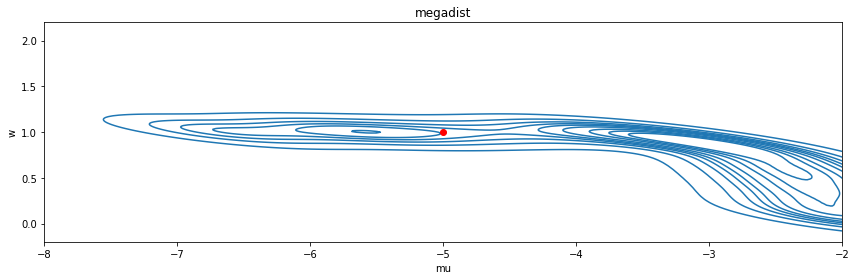

In [125]:
df = compare_methods(-5, 1, 0.0001, stages=['megadist'], wt_freqs=[0.01], model_ss=10**5, data_ss=10**5)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=518, start_time=2021-03-18 17:41:41.883463, end_time=None)>


Creating dataset...
Inferring with mega distance function


INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.090148495
INFO:ABC:t: 0, eps: 0.090148495.
INFO:ABC:Acceptance rate: 1000 / 1929 = 5.1840e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.07050012499999993.
INFO:ABC:Acceptance rate: 1000 / 2126 = 4.7037e-01, ESS=9.4191e+02.
INFO:ABC:t: 2, eps: 0.04214467123217946.
INFO:ABC:Acceptance rate: 1000 / 2268 = 4.4092e-01, ESS=9.2784e+02.
INFO:ABC:t: 3, eps: 0.022781328487104954.
INFO:ABC:Acceptance rate: 1000 / 2764 = 3.6179e-01, ESS=8.2539e+02.
INFO:ABC:t: 4, eps: 0.011456095785514767.
INFO:ABC:Acceptance rate: 1000 / 4898 = 2.0416e-01, ESS=8.8290e+02.
INFO:ABC:t: 5, eps: 0.006021127235953389.
INFO:ABC:Acceptance rate: 1000 / 9119 = 1.0966e-01, ESS=9.0941e+02.
INFO:ABC:t: 6, eps: 0.0031851183861193316.
INFO:ABC:Acceptance rate: 1000 / 15575 = 6.4205e-02, ESS=8.2026e+02.
INFO:ABC:t: 7, eps: 0.0018803029701665592.
INFO:ABC:Acceptance rate: 1000 / 30761 = 3.2509e-02, ESS=8.2715e+02.
INFO:ABC:t: 8, eps: 0.0014684199548223237.


SMC run time:  222.42
Total number of SMC simulations:  262628


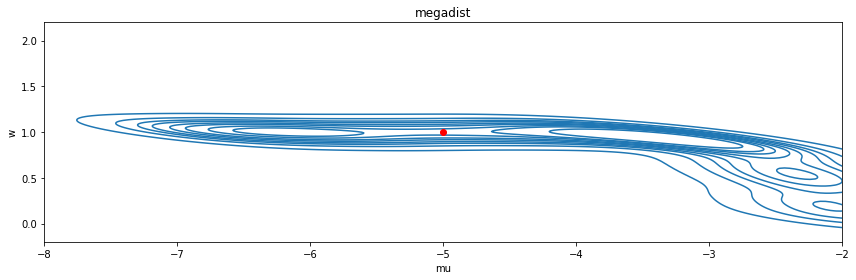

In [124]:
df = compare_methods(-5, 1, 0.0001, stages=['megadist'], wt_freqs=[0.01], model_ss=10**8, data_ss=10**5)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=537, start_time=2021-03-18 18:51:18.594778, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.0012000000000000001
INFO:ABC:t: 0, eps: 0.0012000000000000001.
INFO:ABC:Acceptance rate: 1000 / 2101 = 4.7596e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0011.
INFO:ABC:Acceptance rate: 1000 / 1107 = 9.0334e-01, ESS=9.2174e+02.
INFO:ABC:t: 2, eps: 0.001.
INFO:ABC:Acceptance rate: 1000 / 2209 = 4.5269e-01, ESS=9.3623e+02.
INFO:ABC:t: 3, eps: 0.0009000000000000001.
INFO:ABC:Acceptance rate: 1000 / 2328 = 4.2955e-01, ESS=9.0706e+02.
INFO:ABC:t: 4, eps: 0.0008.
INFO:ABC:Acceptance rate: 1000 / 2854 = 3.5039e-01, ESS=8.8973e+02.
INFO:ABC:t: 5, eps: 0.0007.
INFO:ABC:Acceptance rate: 1000 / 4516 = 2.2143e-01, ESS=8.1759e+02.
INFO:ABC:t: 6, eps: 0.0006000000000000001.
INFO:ABC:Acceptance rate: 1000 / 6356 = 1.5733e-01, ESS=7.8762e+02.
INFO:ABC:t: 7, eps: 0.0006.
INFO:ABC:Acceptance rate: 1000 / 8066 = 1.2398e-01, ESS=5.3244e+02.
INFO:ABC:t: 8, eps: 0.0005.
INFO:ABC:Acceptance rate: 1000 / 13303 = 7.5171e-02, ESS=6.4871e+02.
INFO:ABC:t: 9, eps: 0.0005.
INFO:ABC:

SMC run time:  82.81
Total number of SMC simulations:  55858


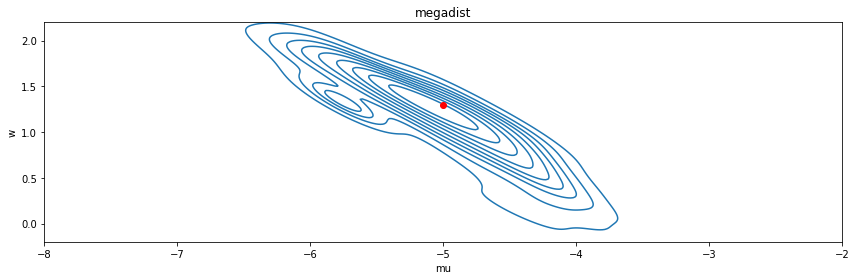

In [150]:
df = compare_methods(-5, 1.3, 0.0001, stages=['megadist'], wt_freqs=[0], model_ss=10**4, data_ss=10**4)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=538, start_time=2021-03-18 18:53:32.068665, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.0014249999999999966
INFO:ABC:t: 0, eps: 0.0014249999999999966.
INFO:ABC:Acceptance rate: 1000 / 1948 = 5.1335e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00069.
INFO:ABC:Acceptance rate: 1000 / 1909 = 5.2383e-01, ESS=9.4476e+02.
INFO:ABC:t: 2, eps: 0.00062.
INFO:ABC:Acceptance rate: 1000 / 2109 = 4.7416e-01, ESS=9.3955e+02.
INFO:ABC:t: 3, eps: 0.00056.
INFO:ABC:Acceptance rate: 1000 / 2357 = 4.2427e-01, ESS=8.7790e+02.
INFO:ABC:t: 4, eps: 0.00051.
INFO:ABC:Acceptance rate: 1000 / 2743 = 3.6456e-01, ESS=8.7690e+02.
INFO:ABC:t: 5, eps: 0.00047999999999999996.
INFO:ABC:Acceptance rate: 1000 / 3788 = 2.6399e-01, ESS=6.2664e+02.
INFO:ABC:t: 6, eps: 0.00045.
INFO:ABC:Acceptance rate: 1000 / 5982 = 1.6717e-01, ESS=6.8380e+02.
INFO:ABC:t: 7, eps: 0.00042999999999999994.
INFO:ABC:Acceptance rate: 1000 / 9696 = 1.0314e-01, ESS=7.5487e+02.
INFO:ABC:t: 8, eps: 0.0004.
INFO:ABC:Acceptance rate: 1000 / 15450 = 6.4725e-02, ESS=7.3571e+02.
INFO:ABC:t: 9, eps: 0.00038.


SMC run time:  89.76
Total number of SMC simulations:  73385


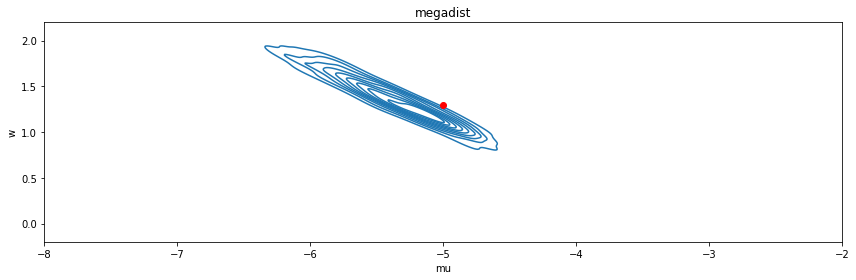

In [151]:
df = compare_methods(-5, 1.3, 0.0001, stages=['megadist'], wt_freqs=[0], model_ss=10**5, data_ss=10**4)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=543, start_time=2021-03-18 19:17:00.552017, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.0013346649999999827
INFO:ABC:t: 0, eps: 0.0013346649999999827.
INFO:ABC:Acceptance rate: 1000 / 2042 = 4.8972e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.000781655.
INFO:ABC:Acceptance rate: 1000 / 1915 = 5.2219e-01, ESS=9.6996e+02.
INFO:ABC:t: 2, eps: 0.0007184584445079653.
INFO:ABC:Acceptance rate: 1000 / 2061 = 4.8520e-01, ESS=9.4601e+02.
INFO:ABC:t: 3, eps: 0.0006363884445168591.
INFO:ABC:Acceptance rate: 1000 / 2134 = 4.6860e-01, ESS=9.6979e+02.
INFO:ABC:t: 4, eps: 0.0005483226695436835.
INFO:ABC:Acceptance rate: 1000 / 2154 = 4.6425e-01, ESS=9.5323e+02.
INFO:ABC:t: 5, eps: 0.00048246842162091624.
INFO:ABC:Acceptance rate: 1000 / 2035 = 4.9140e-01, ESS=9.6547e+02.
INFO:ABC:t: 6, eps: 0.00042928704373157596.
INFO:ABC:Acceptance rate: 1000 / 2051 = 4.8757e-01, ESS=9.3519e+02.
INFO:ABC:t: 7, eps: 0.00040322803995321635.
INFO:ABC:Acceptance rate: 1000 / 2315 = 4.3197e-01, ESS=8.9319e+02.
INFO:ABC:t: 8, eps: 0.0003912500000000001.
INFO:ABC:Acceptance ra

SMC run time:  57.63
Total number of SMC simulations:  23710


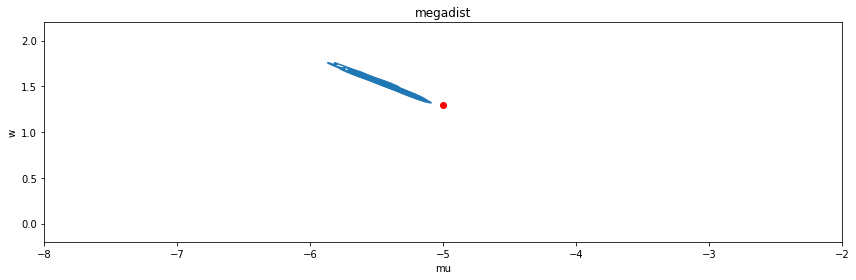

In [159]:
df = compare_methods(-5, 1.3, 0.0001, stages=['megadist'], wt_freqs=[0], model_ss=10**8, data_ss=10**4)

INFO:Sampler:Parallelizing the sampling on 8 cores.


Creating dataset...
Inferring with mega distance function


INFO:History:Start <ABCSMC(id=544, start_time=2021-03-18 19:19:10.237585, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.00109987
INFO:ABC:t: 0, eps: 0.00109987.
INFO:ABC:Acceptance rate: 1000 / 2127 = 4.7015e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0010693200000000001.
INFO:ABC:Acceptance rate: 1000 / 2162 = 4.6253e-01, ESS=9.5830e+02.
INFO:ABC:t: 2, eps: 0.0009661010120172773.
INFO:ABC:Acceptance rate: 1000 / 2167 = 4.6147e-01, ESS=9.7033e+02.
INFO:ABC:t: 3, eps: 0.0008153183672315038.
INFO:ABC:Acceptance rate: 1000 / 2106 = 4.7483e-01, ESS=9.4149e+02.
INFO:ABC:t: 4, eps: 0.0007122078911440337.
INFO:ABC:Acceptance rate: 1000 / 2139 = 4.6751e-01, ESS=9.7686e+02.
INFO:ABC:t: 5, eps: 0.0006411813758338739.
INFO:ABC:Acceptance rate: 1000 / 2056 = 4.8638e-01, ESS=9.5275e+02.
INFO:ABC:t: 6, eps: 0.0005886192357732623.
INFO:ABC:Acceptance rate: 1000 / 2164 = 4.6211e-01, ESS=9.6741e+02.
INFO:ABC:t: 7, eps: 0.0005544957326090569.
INFO:ABC:Acceptanc

SMC run time:  55.62
Total number of SMC simulations:  25662


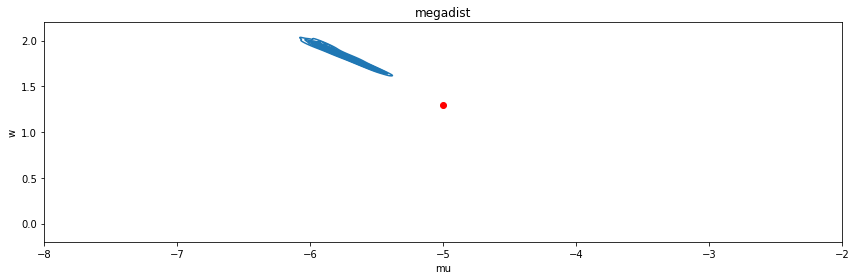

In [160]:
df = compare_methods(-5, 1.3, 0.0001, stages=['megadist'], wt_freqs=[0], model_ss=10**8, data_ss=10**4)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=546, start_time=2021-03-18 19:33:25.940009, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.0011427
INFO:ABC:t: 0, eps: 0.0011427.
INFO:ABC:Acceptance rate: 1000 / 1967 = 5.0839e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0010390999999999998.
INFO:ABC:Acceptance rate: 1000 / 2233 = 4.4783e-01, ESS=9.5108e+02.
INFO:ABC:t: 2, eps: 0.0008102999999999999.
INFO:ABC:Acceptance rate: 1000 / 2141 = 4.6707e-01, ESS=9.3951e+02.
INFO:ABC:t: 3, eps: 0.0006203.
INFO:ABC:Acceptance rate: 1000 / 2178 = 4.5914e-01, ESS=9.7030e+02.
INFO:ABC:t: 4, eps: 0.00046252111233520686.
INFO:ABC:Acceptance rate: 1000 / 2032 = 4.9213e-01, ESS=9.3800e+02.
INFO:ABC:t: 5, eps: 0.0003591.
INFO:ABC:Acceptance rate: 1000 / 2557 = 3.9108e-01, ESS=9.2839e+02.
INFO:ABC:t: 6, eps: 0.00029109738985139935.
INFO:ABC:Acceptance rate: 1000 / 2865 = 3.4904e-01, ESS=7.2215e+02.
INFO:ABC:t: 7, eps: 0.00024269999999999994.
INFO:ABC:Acceptance rate: 1000 / 3809 = 2.6254e-01, ESS=6.9635e+02.
INFO:ABC:t: 8, eps: 0.0002083.
INFO:ABC:Acceptance rate: 1000 / 5840 = 1.7123e-01, ESS=5.1442e+02.
INFO

SMC run time:  60.78
Total number of SMC simulations:  36834


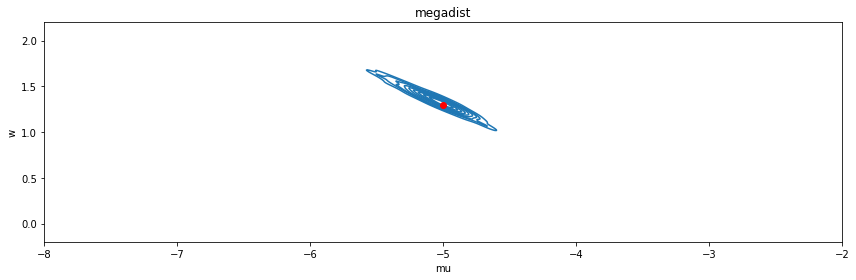

In [162]:
df = compare_methods(-5, 1.3, 0.0001, stages=['megadist'], wt_freqs=[0], model_ss=10**5, data_ss=10**7)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=547, start_time=2021-03-18 19:34:47.358567, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.0010871499999999998
INFO:ABC:t: 0, eps: 0.0010871499999999998.
INFO:ABC:Acceptance rate: 1000 / 1954 = 5.1177e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0009739999999999998.
INFO:ABC:Acceptance rate: 1000 / 2092 = 4.7801e-01, ESS=9.4425e+02.
INFO:ABC:t: 2, eps: 0.0007373822061739816.
INFO:ABC:Acceptance rate: 1000 / 2086 = 4.7939e-01, ESS=9.7405e+02.
INFO:ABC:t: 3, eps: 0.0005559568232706367.
INFO:ABC:Acceptance rate: 1000 / 2114 = 4.7304e-01, ESS=9.7395e+02.
INFO:ABC:t: 4, eps: 0.00039638034458343546.
INFO:ABC:Acceptance rate: 1000 / 1999 = 5.0025e-01, ESS=9.9467e+02.
INFO:ABC:t: 5, eps: 0.00029108823364805425.
INFO:ABC:Acceptance rate: 1000 / 2050 = 4.8780e-01, ESS=9.8173e+02.
INFO:ABC:t: 6, eps: 0.0002076412525654992.
INFO:ABC:Acceptance rate: 1000 / 2254 = 4.4366e-01, ESS=9.8914e+02.
INFO:ABC:t: 7, eps: 0.00014417414419340977.
INFO:ABC:Acceptance rate: 1000 / 2159 = 4.6318e-01, ESS=9.8641e+02.
INFO:ABC:t: 8, eps: 0.00010376683747355725.
INFO:ABC:Ac

SMC run time:  53.95
Total number of SMC simulations:  22182


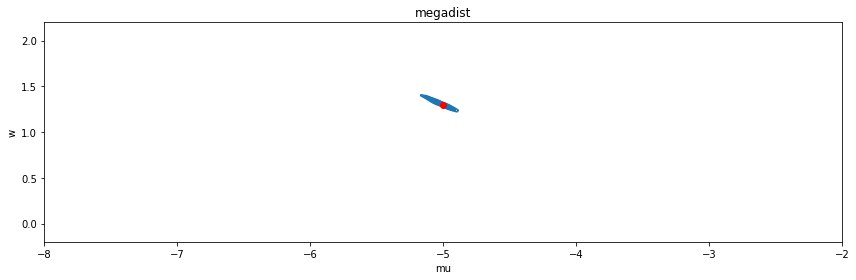

In [163]:
df = compare_methods(-5, 1.3, 0.0001, stages=['megadist'], wt_freqs=[0], model_ss=10**7, data_ss=10**7)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=542, start_time=2021-03-18 19:16:04.302683, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.0009213849999999982
INFO:ABC:t: 0, eps: 0.0009213849999999982.
INFO:ABC:Acceptance rate: 1000 / 2010 = 4.9751e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00079451.
INFO:ABC:Acceptance rate: 1000 / 2003 = 4.9925e-01, ESS=9.5878e+02.
INFO:ABC:t: 2, eps: 0.0007249821346123707.
INFO:ABC:Acceptance rate: 1000 / 2076 = 4.8170e-01, ESS=9.5571e+02.
INFO:ABC:t: 3, eps: 0.0006061277984420521.
INFO:ABC:Acceptance rate: 1000 / 2120 = 4.7170e-01, ESS=9.7404e+02.
INFO:ABC:t: 4, eps: 0.0004913916721978405.
INFO:ABC:Acceptance rate: 1000 / 2069 = 4.8333e-01, ESS=9.7728e+02.
INFO:ABC:t: 5, eps: 0.0004409870198074999.
INFO:ABC:Acceptance rate: 1000 / 1980 = 5.0505e-01, ESS=9.8813e+02.
INFO:ABC:t: 6, eps: 0.0004184753252417094.
INFO:ABC:Acceptance rate: 1000 / 2275 = 4.3956e-01, ESS=9.6628e+02.
INFO:ABC:t: 7, eps: 0.00040727812178516665.
INFO:ABC:Acceptance rate: 1000 / 2255 = 4.4346e-01, ESS=9.4418e+02.
INFO:ABC:t: 8, eps: 0.0004030276845979616.
INFO:ABC:Acceptance rate:

SMC run time:  54.13
Total number of SMC simulations:  24395


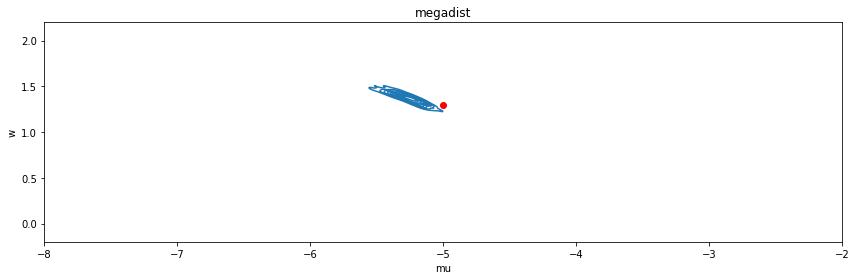

In [158]:
df = compare_methods(-5, 1.3, 0.0001, stages=['megadist'], wt_freqs=[0], model_ss=10**8, data_ss=10**4)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=520, start_time=2021-03-18 17:49:47.624695, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.001374769999999996
INFO:ABC:t: 0, eps: 0.001374769999999996.
INFO:ABC:Acceptance rate: 1000 / 2056 = 4.8638e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00036636499999999984.
INFO:ABC:Acceptance rate: 1000 / 1922 = 5.2029e-01, ESS=9.5301e+02.
INFO:ABC:t: 2, eps: 0.0002810079110507273.
INFO:ABC:Acceptance rate: 1000 / 2080 = 4.8077e-01, ESS=9.6028e+02.
INFO:ABC:t: 3, eps: 0.00023172311053117994.
INFO:ABC:Acceptance rate: 1000 / 2094 = 4.7755e-01, ESS=9.8774e+02.
INFO:ABC:t: 4, eps: 0.00020620999999999997.
INFO:ABC:Acceptance rate: 1000 / 2039 = 4.9044e-01, ESS=9.8927e+02.
INFO:ABC:t: 5, eps: 0.00018465999999999998.
INFO:ABC:Acceptance rate: 1000 / 2140 = 4.6729e-01, ESS=9.8969e+02.
INFO:ABC:t: 6, eps: 0.0001696514988673704.
INFO:ABC:Acceptance rate: 1000 / 2034 = 4.9164e-01, ESS=9.9431e+02.
INFO:ABC:t: 7, eps: 0.00015856638644503308.
INFO:ABC:Acceptance rate: 1000 / 2075 = 4.8193e-01, ESS=9.8526e+02.
INFO:ABC:t: 8, eps: 0.00015234599055950708.
INFO:ABC:Ac

SMC run time:  69.59
Total number of SMC simulations:  22212


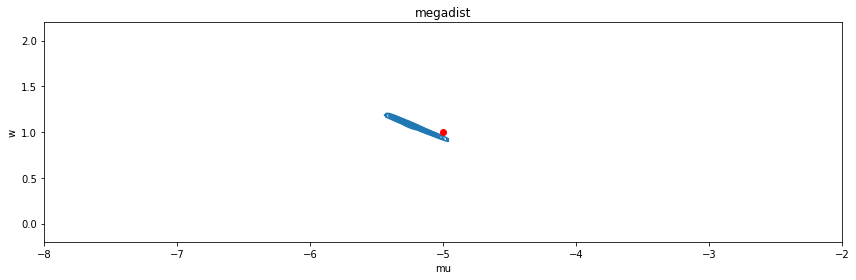

In [126]:
df = compare_methods(-5, 1, 0.0001, stages=['megadist'], wt_freqs=[0], model_ss=10**8, data_ss=10**5)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=502, start_time=2021-03-18 17:09:59.094231, end_time=None)>


Creating dataset...
Inferring with mega distance function


INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.004256609999999999
INFO:ABC:t: 0, eps: 0.004256609999999999.
INFO:ABC:Acceptance rate: 1000 / 1915 = 5.2219e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00400315.
INFO:ABC:Acceptance rate: 1000 / 2105 = 4.7506e-01, ESS=9.3736e+02.
INFO:ABC:t: 2, eps: 0.003998960000000001.
INFO:ABC:Acceptance rate: 1000 / 2272 = 4.4014e-01, ESS=9.0501e+02.
INFO:ABC:t: 3, eps: 0.003963241224467188.
INFO:ABC:Acceptance rate: 1000 / 2119 = 4.7192e-01, ESS=9.6129e+02.
INFO:ABC:t: 4, eps: 0.0038743438657556457.
INFO:ABC:Acceptance rate: 1000 / 2167 = 4.6147e-01, ESS=9.5975e+02.
INFO:ABC:t: 5, eps: 0.0037336975738811967.
INFO:ABC:Acceptance rate: 1000 / 2275 = 4.3956e-01, ESS=9.6769e+02.
INFO:ABC:t: 6, eps: 0.0036113134178065655.
INFO:ABC:Acceptance rate: 1000 / 2194 = 4.5579e-01, ESS=9.6787e+02.
INFO:ABC:t: 7, eps: 0.0035071857571780628.
INFO:ABC:Acceptance rate: 1000 / 2289 = 4.3687e-01, ESS=9.3481e+02.
INFO:ABC:t: 8, eps: 0.00343036113

SMC run time:  54.59
Total number of SMC simulations:  22826


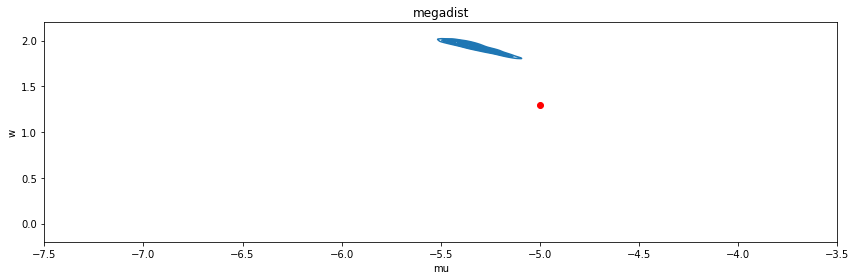

In [91]:
df = compare_methods(-5, 1.3, 0.001, stages=['megadist'], wt_freqs=[0.0001], model_ss=10**8, data_ss=10**3)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=527, start_time=2021-03-18 18:28:44.924095, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.01448
INFO:ABC:t: 0, eps: 0.01448.
INFO:ABC:Acceptance rate: 1000 / 1894 = 5.2798e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.01218.
INFO:ABC:Acceptance rate: 1000 / 2142 = 4.6685e-01, ESS=9.5329e+02.
INFO:ABC:t: 2, eps: 0.008879999999999999.
INFO:ABC:Acceptance rate: 1000 / 2207 = 4.5310e-01, ESS=9.6264e+02.
INFO:ABC:t: 3, eps: 0.006166325496799816.
INFO:ABC:Acceptance rate: 1000 / 2651 = 3.7722e-01, ESS=9.6577e+02.
INFO:ABC:t: 4, eps: 0.00432.
INFO:ABC:Acceptance rate: 1000 / 2973 = 3.3636e-01, ESS=9.4728e+02.
INFO:ABC:t: 5, eps: 0.00342.
INFO:ABC:Acceptance rate: 1000 / 3969 = 2.5195e-01, ESS=8.6100e+02.
INFO:ABC:t: 6, eps: 0.0028800000000000006.
INFO:ABC:Acceptance rate: 1000 / 6602 = 1.5147e-01, ESS=8.8358e+02.
INFO:ABC:t: 7, eps: 0.0025000000000000005.
INFO:ABC:Acceptance rate: 1000 / 11907 = 8.3984e-02, ESS=7.8915e+02.
INFO:ABC:t: 8, eps: 0.00224.
INFO:ABC:Acceptance rate: 1000 / 18754 = 5.3322e-02, ESS=7.4428e+02.
INFO:ABC:t: 9, eps: 0.002.
INFO

SMC run time:  106.4
Total number of SMC simulations:  93075


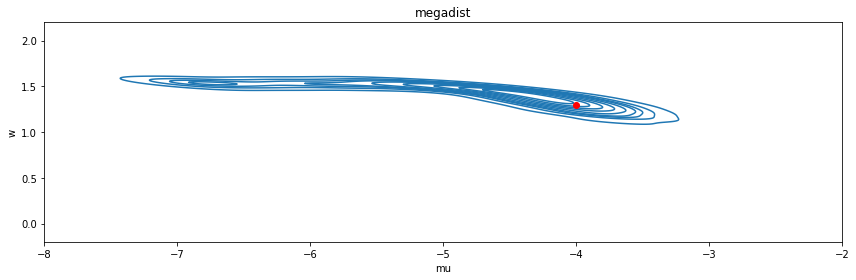

In [133]:
df = compare_methods(-4, 1.3, 0.001, stages=['megadist'], wt_freqs=[0.0001], model_ss=10**4, data_ss=10**5)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=528, start_time=2021-03-18 18:30:33.319493, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.014904999999999996
INFO:ABC:t: 0, eps: 0.014904999999999996.
INFO:ABC:Acceptance rate: 1000 / 2042 = 4.8972e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.011694999999999995.
INFO:ABC:Acceptance rate: 1000 / 2209 = 4.5269e-01, ESS=9.5406e+02.
INFO:ABC:t: 2, eps: 0.008569470702507033.
INFO:ABC:Acceptance rate: 1000 / 2459 = 4.0667e-01, ESS=9.6286e+02.
INFO:ABC:t: 3, eps: 0.005599999999999999.
INFO:ABC:Acceptance rate: 1000 / 2429 = 4.1169e-01, ESS=9.6796e+02.
INFO:ABC:t: 4, eps: 0.0038499999999999997.
INFO:ABC:Acceptance rate: 1000 / 2621 = 3.8153e-01, ESS=9.6214e+02.
INFO:ABC:t: 5, eps: 0.0031299999999999995.
INFO:ABC:Acceptance rate: 1000 / 3779 = 2.6462e-01, ESS=8.5880e+02.
INFO:ABC:t: 6, eps: 0.0026329576479604253.
INFO:ABC:Acceptance rate: 1000 / 4437 = 2.2538e-01, ESS=8.7243e+02.
INFO:ABC:t: 7, eps: 0.0021100000000000003.
INFO:ABC:Acceptance rate: 1000 / 3174 = 3.1506e-01, ESS=8.6549e+02.
INFO:ABC:t: 8, eps: 0.0017400000000000002.
INFO:ABC:Acceptance 

SMC run time:  58.42
Total number of SMC simulations:  29984


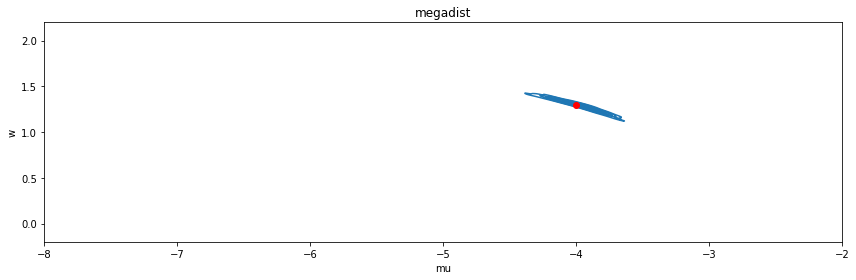

In [134]:
df = compare_methods(-4, 1.3, 0.001, stages=['megadist'], wt_freqs=[0.0001], model_ss=10**5, data_ss=10**5)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=529, start_time=2021-03-18 18:31:33.779692, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.014713539999999999
INFO:ABC:t: 0, eps: 0.014713539999999999.
INFO:ABC:Acceptance rate: 1000 / 2011 = 4.9727e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.012040869999999997.
INFO:ABC:Acceptance rate: 1000 / 2112 = 4.7348e-01, ESS=9.6566e+02.
INFO:ABC:t: 2, eps: 0.008871912528182889.
INFO:ABC:Acceptance rate: 1000 / 2351 = 4.2535e-01, ESS=9.6168e+02.
INFO:ABC:t: 3, eps: 0.005893008531334798.
INFO:ABC:Acceptance rate: 1000 / 2539 = 3.9386e-01, ESS=9.5141e+02.
INFO:ABC:t: 4, eps: 0.0037949997098581955.
INFO:ABC:Acceptance rate: 1000 / 2641 = 3.7864e-01, ESS=9.6395e+02.
INFO:ABC:t: 5, eps: 0.002887967717074309.
INFO:ABC:Acceptance rate: 1000 / 3125 = 3.2000e-01, ESS=9.0298e+02.
INFO:ABC:t: 6, eps: 0.0025235250612590065.
INFO:ABC:Acceptance rate: 1000 / 4299 = 2.3261e-01, ESS=9.1173e+02.
INFO:ABC:t: 7, eps: 0.0019408431290343462.
INFO:ABC:Acceptance rate: 1000 / 2257 = 4.4307e-01, ESS=9.7798e+02.
INFO:ABC:t: 8, eps: 0.0014669664917895538.
INFO:ABC:Acceptance r

SMC run time:  56.38
Total number of SMC simulations:  26509


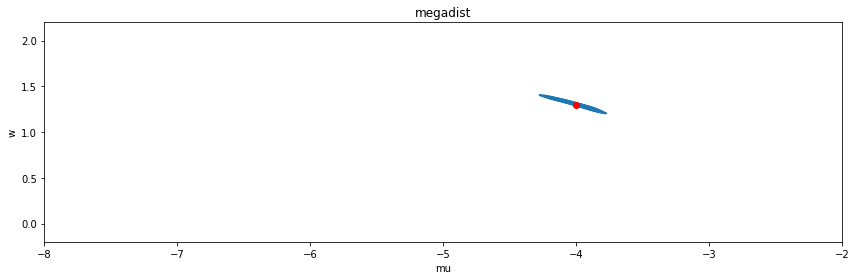

In [135]:
df = compare_methods(-4, 1.3, 0.001, stages=['megadist'], wt_freqs=[0.0001], model_ss=10**8, data_ss=10**5)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=503, start_time=2021-03-18 17:11:37.118059, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.004354664999999997
INFO:ABC:t: 0, eps: 0.004354664999999997.
INFO:ABC:Acceptance rate: 1000 / 1872 = 5.3419e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00401931.
INFO:ABC:Acceptance rate: 1000 / 2052 = 4.8733e-01, ESS=9.5636e+02.
INFO:ABC:t: 2, eps: 0.004003779817504434.
INFO:ABC:Acceptance rate: 1000 / 1963 = 5.0942e-01, ESS=9.4009e+02.
INFO:ABC:t: 3, eps: 0.0040013900000000005.
INFO:ABC:Acceptance rate: 1000 / 2055 = 4.8662e-01, ESS=9.5819e+02.
INFO:ABC:t: 4, eps: 0.00400078.
INFO:ABC:Acceptance rate: 1000 / 2209 = 4.5269e-01, ESS=8.3555e+02.
INFO:ABC:t: 5, eps: 0.0040005100000000005.
INFO:ABC:Acceptance rate: 1000 / 2891 = 3.4590e-01, ESS=8.2717e+02.
INFO:ABC:t: 6, eps: 0.0040003700000000005.
INFO:ABC:Acceptance rate: 1000 / 4699 = 2.1281e-01, ESS=6.4377e+02.
INFO:ABC:t: 7, eps: 0.00400026.
INFO:ABC:Acceptance rate: 1000 / 9312 = 1.0739e-01, ESS=7.7320e+02.
INFO:ABC:t: 8, eps: 0.004000170000000001.
INFO:ABC:Acceptance rate: 1000 / 16027 = 6.2395e-02,

SMC run time:  91.85
Total number of SMC simulations:  76835


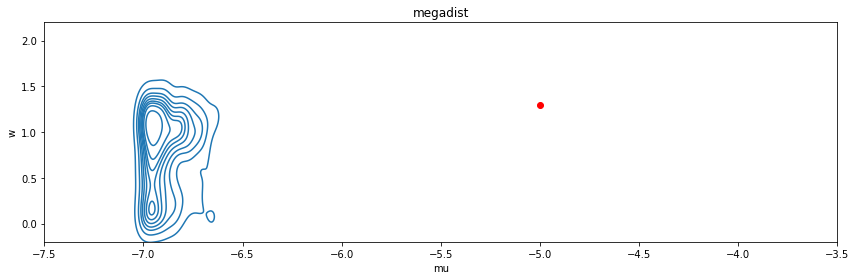

In [92]:
df = compare_methods(-5, 1.3, 0.001, stages=['megadist'], wt_freqs=[0.0001], model_ss=10**8, data_ss=10**3)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=477, start_time=2021-03-18 16:07:02.732549, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.001102
INFO:ABC:t: 0, eps: 0.001102.
INFO:ABC:Acceptance rate: 1000 / 1941 = 5.1520e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.000997.
INFO:ABC:Acceptance rate: 1000 / 2104 = 4.7529e-01, ESS=9.3285e+02.
INFO:ABC:t: 2, eps: 0.0007589999999999999.
INFO:ABC:Acceptance rate: 1000 / 2222 = 4.5005e-01, ESS=9.5492e+02.
INFO:ABC:t: 3, eps: 0.000582807605392073.
INFO:ABC:Acceptance rate: 1000 / 2141 = 4.6707e-01, ESS=9.8957e+02.
INFO:ABC:t: 4, eps: 0.00044300000000000003.
INFO:ABC:Acceptance rate: 1000 / 1975 = 5.0633e-01, ESS=9.8231e+02.
INFO:ABC:t: 5, eps: 0.00033599999999999993.
INFO:ABC:Acceptance rate: 1000 / 2055 = 4.8662e-01, ESS=9.8559e+02.
INFO:ABC:t: 6, eps: 0.00025100000000000003.
INFO:ABC:Acceptance rate: 1000 / 2061 = 4.8520e-01, ESS=9.8271e+02.
INFO:ABC:t: 7, eps: 0.00019200000000000006.
INFO:ABC:Acceptance rate: 1000 / 2100 = 4.7619e-01, ESS=9.7242e+02.
INFO:ABC:t: 8, eps: 0.00015099999999999993.
INFO:ABC:Acceptance rate: 1000 / 2270 = 4.4053e-01

SMC run time:  50.08
Total number of SMC simulations:  22707


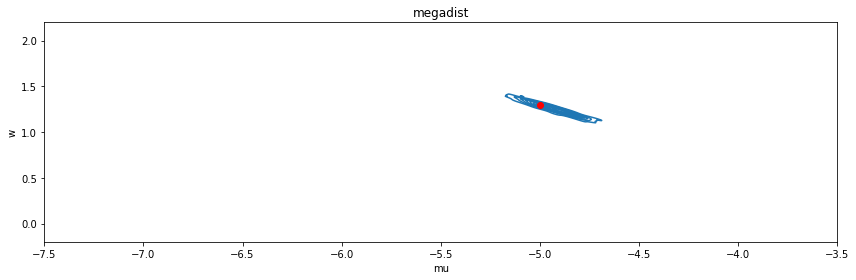

In [59]:
compare_methods(-5, 1.3, 0.0001, stages=['megadist'], wt_freqs=[0], model_ss=10**6, data_ss=10**6)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=475, start_time=2021-03-18 16:04:55.438877, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.002005999999999999
INFO:ABC:t: 0, eps: 0.002005999999999999.
INFO:ABC:Acceptance rate: 1000 / 2061 = 4.8520e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0010644999999999997.
INFO:ABC:Acceptance rate: 1000 / 2066 = 4.8403e-01, ESS=9.5407e+02.
INFO:ABC:t: 2, eps: 0.001013.
INFO:ABC:Acceptance rate: 1000 / 2020 = 4.9505e-01, ESS=9.1401e+02.
INFO:ABC:t: 3, eps: 0.0010040000000000001.
INFO:ABC:Acceptance rate: 1000 / 2307 = 4.3346e-01, ESS=9.5605e+02.
INFO:ABC:t: 4, eps: 0.001002.
INFO:ABC:Acceptance rate: 1000 / 2217 = 4.5106e-01, ESS=7.4085e+02.
INFO:ABC:t: 5, eps: 0.001001.
INFO:ABC:Acceptance rate: 1000 / 3156 = 3.1686e-01, ESS=7.5036e+02.
INFO:ABC:t: 6, eps: 0.001.
INFO:ABC:Acceptance rate: 1000 / 5526 = 1.8096e-01, ESS=7.2252e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=475, start_time=2021-03-18 16:04:55.438877, end_time=2021-03-18 16:05:37.126333)>


SMC run time:  41.73
Total number of SMC simulations:  20353


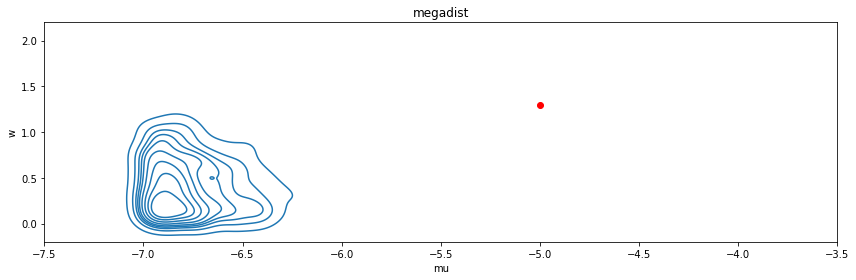

In [57]:
compare_methods(-5, 1.3, 0.001, stages=['megadist'], wt_freqs=[0], model_ss=10**6, data_ss=10**3)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=531, start_time=2021-03-18 18:38:21.207226, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.007339999999999993
INFO:ABC:t: 0, eps: 0.007339999999999993.
INFO:ABC:Acceptance rate: 1000 / 2132 = 4.6904e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00071.
INFO:ABC:Acceptance rate: 1000 / 1925 = 5.1948e-01, ESS=9.7352e+02.
INFO:ABC:t: 2, eps: 0.0005.
INFO:ABC:Acceptance rate: 1000 / 2219 = 4.5065e-01, ESS=9.7590e+02.
INFO:ABC:t: 3, eps: 0.00036.
INFO:ABC:Acceptance rate: 1000 / 2442 = 4.0950e-01, ESS=9.5239e+02.
INFO:ABC:t: 4, eps: 0.00030000000000000003.
INFO:ABC:Acceptance rate: 1000 / 3451 = 2.8977e-01, ESS=9.1063e+02.
INFO:ABC:t: 5, eps: 0.00026000000000000003.
INFO:ABC:Acceptance rate: 1000 / 6340 = 1.5773e-01, ESS=9.3275e+02.
INFO:ABC:t: 6, eps: 0.00023999999999999995.
INFO:ABC:Acceptance rate: 1000 / 11453 = 8.7313e-02, ESS=8.3858e+02.
INFO:ABC:t: 7, eps: 0.00021000000000000004.
INFO:ABC:Acceptance rate: 1000 / 19524 = 5.1219e-02, ESS=6.4460e+02.
INFO:ABC:t: 8, eps: 0.00019999999999999998.
INFO:ABC:Acceptance rate: 1000 / 34359 = 2.9104e-02, 

SMC run time:  131.75
Total number of SMC simulations:  144202


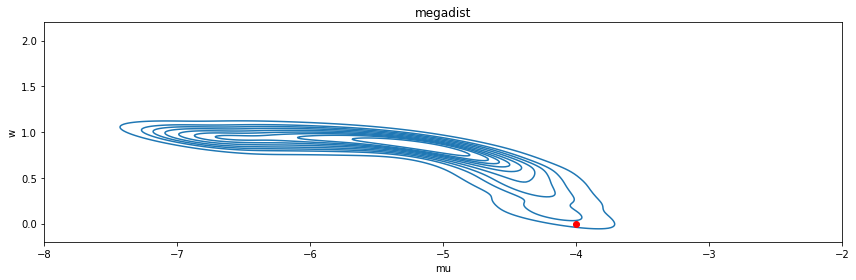

In [137]:
df = compare_methods(-4, 0, 0.0001, stages=['megadist'], wt_freqs=[0.0001], model_ss=10**5, data_ss=10**5)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=534, start_time=2021-03-18 18:46:41.366024, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.024262
INFO:ABC:t: 0, eps: 0.024262.
INFO:ABC:Acceptance rate: 1000 / 2135 = 4.6838e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.002228499999999979.
INFO:ABC:Acceptance rate: 1000 / 2021 = 4.9480e-01, ESS=9.4882e+02.
INFO:ABC:t: 2, eps: 0.0008926713861306559.
INFO:ABC:Acceptance rate: 1000 / 2060 = 4.8544e-01, ESS=9.5643e+02.
INFO:ABC:t: 3, eps: 0.0008086999999999999.
INFO:ABC:Acceptance rate: 1000 / 2046 = 4.8876e-01, ESS=9.4439e+02.
INFO:ABC:t: 4, eps: 0.0006939581888783285.
INFO:ABC:Acceptance rate: 1000 / 2287 = 4.3725e-01, ESS=9.4318e+02.
INFO:ABC:t: 5, eps: 0.0005182820320947439.
INFO:ABC:Acceptance rate: 1000 / 2110 = 4.7393e-01, ESS=9.5734e+02.
INFO:ABC:t: 6, eps: 0.0003767315681171572.
INFO:ABC:Acceptance rate: 1000 / 2005 = 4.9875e-01, ESS=9.8291e+02.
INFO:ABC:t: 7, eps: 0.00026413478177637434.
INFO:ABC:Acceptance rate: 1000 / 2129 = 4.6970e-01, ESS=9.5376e+02.
INFO:ABC:t: 8, eps: 0.00019063620633617392.
INFO:ABC:Acceptance rate: 1000 / 2075 = 

SMC run time:  48.82
Total number of SMC simulations:  21915


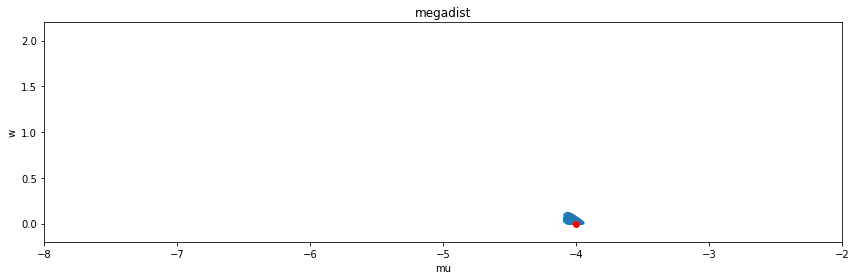

In [147]:
df = compare_methods(-4, 0, 0.0001, stages=['megadist'], wt_freqs=[0.01], model_ss=10**7, data_ss=10**7)

,0,1,2,3,4,5,6,7,8,9
0,0.000099,0.000134,0.000162,0.000210,0.000265,0.000324,0.000410,0.000487,0.000597,0.000712
1,0.000100,0.000133,0.000165,0.000215,0.000265,0.000331,0.000398,0.000494,0.000610,0.000735
2,0.000098,0.000132,0.000163,0.000212,0.000268,0.000319,0.000400,0.000486,0.000598,0.000731
3,0.000100,0.000129,0.000161,0.000207,0.000261,0.000327,0.000401,0.000489,0.000598,0.000707
4,0.000099,0.000128,0.000167,0.000208,0.000258,0.000329,0.000414,0.000499,0.000608,0.000717
5,0.000098,0.000135,0.000167,0.000216,0.000261,0.000323,0.000411,0.000492,0.000598,0.000713
6,0.000096,0.000131,0.000165,0.000211,0.000259,0.000336,0.000396,0.000481,0.000601,0.000716
7,0.000103,0.000127,0.000165,0.000207,0.000266,0.000327,0.000393,0.000487,0.000594,0.000732
8,0.000101,0.000131,0.000163,0.000212,0.000263,0.000327,0.000392,0.000482,0.000603,0.000714
9,0.000106,0.000135,0.000164,0.000197,0.000268,0.000316,0.000407,0.000487,0.000581,0.000731


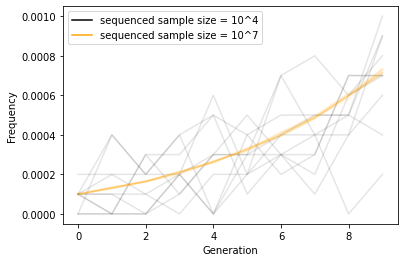

In [156]:
simulate_data(generations_number=10, wt_freqs=0.0001 * np.ones(10), population_size=10**9, fitness=1.2, 
              mutation_rate=10**-5, 
              sequence_sample_size=10**4, color='black', label="sequenced sample size = 10^4", plot=True)
simulate_data(generations_number=10, wt_freqs=0.0001 * np.ones(10), population_size=10**9, fitness=1.2, 
              mutation_rate=10**-5, 
              sequence_sample_size=10**7, color='orange', label="sequenced sample size = 10^7", plot=True)


In [ ]:
compare_methods(-4, 1.3, 0.001, data_size=2, stages=['megadist'], wt_freqs=[0], model_ss=10**6, data_ss=10**6)

In [ ]:
compare_methods(-4, 1, 0.001, data_size=2, infer_avg=False, wt_freqs=[0,0.001], model_ss=10**6, data_ss=10**2)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.00012,0.00023,0.00043,0.00063,0.00094,0.00121,0.00164,0.00239,0.00318
1,0.0,0.00012,0.00022,0.00033,0.00048,0.00081,0.00153,0.00159,0.00236,0.00329
2,0.0,0.00014,0.00014,0.00045,0.00062,0.00094,0.00139,0.00195,0.00261,0.00329
3,0.0,0.00010,0.00023,0.00037,0.00070,0.00090,0.00142,0.00180,0.00228,0.00343
4,0.0,0.00005,0.00023,0.00054,0.00067,0.00096,0.00129,0.00172,0.00236,0.00317
5,0.0,0.00011,0.00018,0.00048,0.00069,0.00098,0.00142,0.00178,0.00249,0.00317
6,0.0,0.00008,0.00031,0.00049,0.00051,0.00090,0.00134,0.00144,0.00252,0.00323
7,0.0,0.00013,0.00018,0.00036,0.00067,0.00083,0.00120,0.00151,0.00245,0.00282
8,0.0,0.00009,0.00026,0.00044,0.00068,0.00076,0.00127,0.00194,0.00237,0.00316
9,0.0,0.00010,0.00022,0.00041,0.00061,0.00092,0.00125,0.00160,0.00214,0.00297


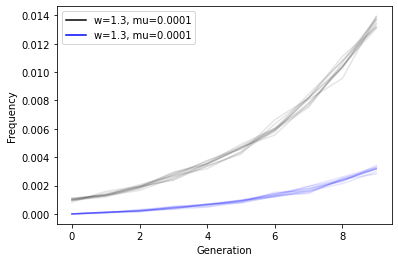

In [31]:
simulate_data(generations_number=10, wt_freqs=0.001 * np.ones(10), population_size=10**9, fitness=1.3, 
              mutation_rate=10**-4, 
              sequence_sample_size=10**5, color='black', label=None, plot=True)
simulate_data(generations_number=10, wt_freqs=0 * np.ones(10), population_size=10**9, fitness=1.3, 
              mutation_rate=10**-4, 
              sequence_sample_size=10**5, color='blue', label=None, plot=True)


Text(0.5, 1.0, '100000 Sequenced Virions')

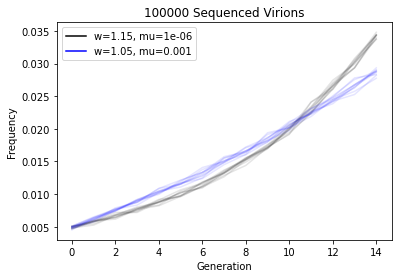

In [111]:
gens = 15
ps = 10 ** 8
ss = 10 ** 5
freq = 0.005
simulate_data(generations_number=gens, wt_freqs=freq*np.ones(10), population_size=ps, fitness=1.15, 
              mutation_rate=10**-6, 
              sequence_sample_size=ss, color='black', label=None, plot=True)
simulate_data(generations_number=gens, wt_freqs=freq*np.ones(10), population_size=ps, fitness=1.05, 
              mutation_rate=10**-3, 
              sequence_sample_size=ss, color='blue', label=None, plot=True)
plt.title(f'{ss} Sequenced Virions')

Text(0.5, 1.0, '1000000 Sequenced Virions')

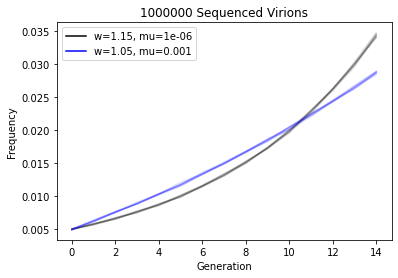

In [106]:
gens = 15
ps = 10 ** 8
ss = 10 ** 6
freq = 0.005
simulate_data(generations_number=gens, wt_freqs=freq*np.ones(10), population_size=ps, fitness=1.15, 
              mutation_rate=10**-6, 
              sequence_sample_size=ss, color='black', label=None, plot=True)
simulate_data(generations_number=gens, wt_freqs=freq*np.ones(10), population_size=ps, fitness=1.05, 
              mutation_rate=10**-3, 
              sequence_sample_size=ss, color='blue', label=None, plot=True)
plt.title(f'{ss} Sequenced Virions')

Text(0.5, 1.0, '100000 Sequenced Virions')

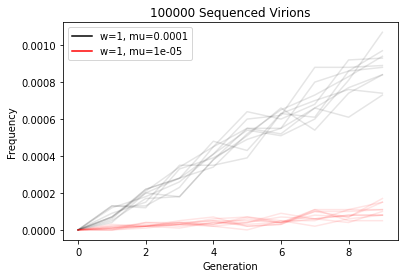

In [132]:
gens = 10
ps = 10 ** 8
mu = 10 ** -4
ss = 10 ** 5
simulate_data(generations_number=gens, wt_freqs=0*np.ones(10), population_size=ps, fitness=1, mutation_rate=mu, 
              sequence_sample_size=ss, color='black', label=None, plot=True)
mu = 10 ** -5
simulate_data(generations_number=gens, wt_freqs=0*np.ones(10), population_size=ps, fitness=1, mutation_rate=mu, 
              sequence_sample_size=ss, color='red', label=None, plot=True)
plt.title(f'{ss} Sequenced Virions')

,0,1,2,3,4,5,6,7,8,9
0,0.016,0.011,0.019,0.014,0.018,0.024,0.035,0.045,0.047,0.054
1,0.005,0.015,0.015,0.020,0.022,0.025,0.032,0.027,0.056,0.048
2,0.015,0.018,0.016,0.021,0.019,0.032,0.031,0.031,0.047,0.038
3,0.015,0.015,0.022,0.017,0.018,0.019,0.024,0.034,0.041,0.045
4,0.008,0.012,0.018,0.017,0.018,0.026,0.031,0.031,0.036,0.058
5,0.011,0.017,0.010,0.018,0.018,0.032,0.034,0.030,0.044,0.049
6,0.011,0.008,0.014,0.021,0.025,0.021,0.022,0.035,0.032,0.037
7,0.009,0.014,0.013,0.014,0.022,0.037,0.032,0.043,0.043,0.040
8,0.007,0.009,0.013,0.014,0.019,0.025,0.035,0.034,0.049,0.045
9,0.007,0.014,0.010,0.012,0.024,0.025,0.025,0.027,0.041,0.044


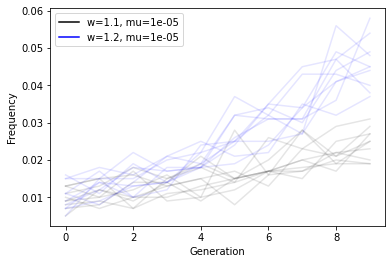

In [128]:
gens = 10
ps = 10 ** 8
mu = 10 ** -5
ss = 10 ** 3
simulate_data(generations_number=gens, wt_freqs=0.01*np.ones(10), population_size=ps, fitness=1.1, mutation_rate=mu, 
              sequence_sample_size=ss, color='black', label=None, plot=True)
simulate_data(generations_number=gens, wt_freqs=0.01*np.ones(10), population_size=ps, fitness=1.2, mutation_rate=mu, 
              sequence_sample_size=ss, color='blue', label=None, plot=True)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=398, start_time=2021-03-17 14:48:34.111944, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring from avgs


INFO:Epsilon:initial epsilon is 0.0011533333333333333
INFO:ABC:t: 0, eps: 0.0011533333333333333.
INFO:ABC:Acceptance rate: 1000 / 1914 = 5.2247e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0010066666666666668.
INFO:ABC:Acceptance rate: 1000 / 2011 = 4.9727e-01, ESS=9.2993e+02.
INFO:ABC:t: 2, eps: 0.0007533333333333333.
INFO:ABC:Acceptance rate: 1000 / 2217 = 4.5106e-01, ESS=9.3712e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=398, start_time=2021-03-17 14:48:34.111944, end_time=2021-03-17 14:48:48.109205)>


SMC run time:  14.05
Total number of SMC simulations:  7142


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=399, start_time=2021-03-17 14:48:48.959908, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.00332
INFO:ABC:t: 0, eps: 0.00332.
INFO:ABC:Acceptance rate: 1000 / 1935 = 5.1680e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0030099999999999997.
INFO:ABC:Acceptance rate: 1000 / 2135 = 4.6838e-01, ESS=9.2787e+02.
INFO:ABC:t: 2, eps: 0.00235.
INFO:ABC:Acceptance rate: 1000 / 2028 = 4.9310e-01, ESS=9.6376e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=399, start_time=2021-03-17 14:48:48.959908, end_time=2021-03-17 14:49:03.347188)>


SMC run time:  14.43
Total number of SMC simulations:  7098


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=400, start_time=2021-03-17 14:49:04.221618, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Inferring with mega posterior


INFO:Epsilon:initial epsilon is 0.00118
INFO:ABC:t: 0, eps: 0.00118.
INFO:ABC:Acceptance rate: 1000 / 1953 = 5.1203e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00107.
INFO:ABC:Acceptance rate: 1000 / 2155 = 4.6404e-01, ESS=9.3835e+02.
INFO:ABC:t: 2, eps: 0.00083.
INFO:ABC:Acceptance rate: 1000 / 2110 = 4.7393e-01, ESS=9.6486e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=400, start_time=2021-03-17 14:49:04.221618, end_time=2021-03-17 14:49:19.651460)>


SMC run time:  15.47
Total number of SMC simulations:  7218


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=401, start_time=2021-03-17 14:49:20.549369, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.00116
INFO:ABC:t: 0, eps: 0.00116.
INFO:ABC:Acceptance rate: 1000 / 1981 = 5.0480e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00107.
INFO:ABC:Acceptance rate: 1000 / 2058 = 4.8591e-01, ESS=9.4314e+02.
INFO:ABC:t: 2, eps: 0.00082.
INFO:ABC:Acceptance rate: 1000 / 2073 = 4.8239e-01, ESS=9.6552e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=401, start_time=2021-03-17 14:49:20.549369, end_time=2021-03-17 14:49:36.324461)>


SMC run time:  15.82
Total number of SMC simulations:  7112


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=402, start_time=2021-03-17 14:49:37.169756, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.00098
INFO:ABC:t: 0, eps: 0.00098.
INFO:ABC:Acceptance rate: 1000 / 2015 = 4.9628e-01, ESS=1.0000e+03.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=402, start_time=2021-03-17 14:49:37.169756, end_time=2021-03-17 14:49:42.527334)>


SMC run time:  5.39
Total number of SMC simulations:  3015


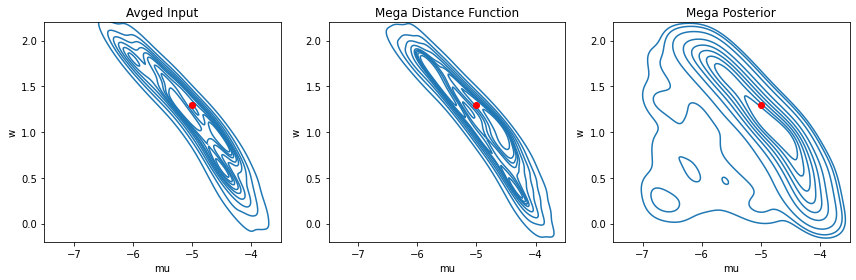

In [17]:
compare_methods(-5, 1.3, 0.001, data_size=3)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=378, start_time=2021-03-17 14:25:52.121904, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring from avgs


INFO:Epsilon:initial epsilon is 0.001077
INFO:ABC:t: 0, eps: 0.001077.
INFO:ABC:Acceptance rate: 1000 / 1960 = 5.1020e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.000977.
INFO:ABC:Acceptance rate: 1000 / 2052 = 4.8733e-01, ESS=9.4683e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=378, start_time=2021-03-17 14:25:52.121904, end_time=2021-03-17 14:26:01.661454)>


SMC run time:  9.58
Total number of SMC simulations:  5012


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=379, start_time=2021-03-17 14:26:02.511779, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.01425499999999999
INFO:ABC:t: 0, eps: 0.01425499999999999.
INFO:ABC:Acceptance rate: 1000 / 1909 = 5.2383e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.009834999999999997.
INFO:ABC:Acceptance rate: 1000 / 2091 = 4.7824e-01, ESS=9.6127e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=379, start_time=2021-03-17 14:26:02.511779, end_time=2021-03-17 14:26:12.458332)>


SMC run time:  9.98
Total number of SMC simulations:  5000


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=380, start_time=2021-03-17 14:26:13.304100, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Inferring with mega posterior


INFO:Epsilon:initial epsilon is 0.00083
INFO:ABC:t: 0, eps: 0.00083.
INFO:ABC:Acceptance rate: 1000 / 2131 = 4.6926e-01, ESS=1.0000e+03.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=380, start_time=2021-03-17 14:26:13.304100, end_time=2021-03-17 14:26:18.156490)>


SMC run time:  4.89
Total number of SMC simulations:  3131


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=381, start_time=2021-03-17 14:26:19.047138, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.00113
INFO:ABC:t: 0, eps: 0.00113.
INFO:ABC:Acceptance rate: 1000 / 1994 = 5.0150e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00105.
INFO:ABC:Acceptance rate: 1000 / 2138 = 4.6773e-01, ESS=9.0983e+02.
INFO:ABC:t: 2, eps: 0.0008500000000000001.
INFO:ABC:Acceptance rate: 1000 / 2032 = 4.9213e-01, ESS=9.7730e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=381, start_time=2021-03-17 14:26:19.047138, end_time=2021-03-17 14:26:34.137886)>


SMC run time:  15.13
Total number of SMC simulations:  7164


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=382, start_time=2021-03-17 14:26:34.997254, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.0011749999999999964
INFO:ABC:t: 0, eps: 0.0011749999999999964.
INFO:ABC:Acceptance rate: 1000 / 1985 = 5.0378e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00108.
INFO:ABC:Acceptance rate: 1000 / 2152 = 4.6468e-01, ESS=9.3112e+02.
INFO:ABC:t: 2, eps: 0.0009.
INFO:ABC:Acceptance rate: 1000 / 1986 = 5.0352e-01, ESS=9.6927e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=382, start_time=2021-03-17 14:26:34.997254, end_time=2021-03-17 14:26:50.609841)>


SMC run time:  15.65
Total number of SMC simulations:  7123


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=383, start_time=2021-03-17 14:26:51.463092, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.00115
INFO:ABC:t: 0, eps: 0.00115.
INFO:ABC:Acceptance rate: 1000 / 1914 = 5.2247e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00105.
INFO:ABC:Acceptance rate: 1000 / 2081 = 4.8054e-01, ESS=9.5713e+02.
INFO:ABC:t: 2, eps: 0.00083.
INFO:ABC:Acceptance rate: 1000 / 2154 = 4.6425e-01, ESS=9.6800e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=383, start_time=2021-03-17 14:26:51.463092, end_time=2021-03-17 14:27:06.964312)>


SMC run time:  15.54
Total number of SMC simulations:  7149


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=384, start_time=2021-03-17 14:27:07.846479, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.00101
INFO:ABC:t: 0, eps: 0.00101.
INFO:ABC:Acceptance rate: 1000 / 2049 = 4.8804e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0009149999999999964.
INFO:ABC:Acceptance rate: 1000 / 2135 = 4.6838e-01, ESS=9.4384e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=384, start_time=2021-03-17 14:27:07.846479, end_time=2021-03-17 14:27:18.342002)>


SMC run time:  10.53
Total number of SMC simulations:  5184


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=385, start_time=2021-03-17 14:27:19.226169, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.0011849999999999964
INFO:ABC:t: 0, eps: 0.0011849999999999964.
INFO:ABC:Acceptance rate: 1000 / 1964 = 5.0916e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00109.
INFO:ABC:Acceptance rate: 1000 / 1996 = 5.0100e-01, ESS=9.3870e+02.
INFO:ABC:t: 2, eps: 0.0009.
INFO:ABC:Acceptance rate: 1000 / 1960 = 5.1020e-01, ESS=9.4009e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=385, start_time=2021-03-17 14:27:19.226169, end_time=2021-03-17 14:27:34.334676)>


SMC run time:  15.14
Total number of SMC simulations:  6920


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=386, start_time=2021-03-17 14:27:35.176564, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.00108
INFO:ABC:t: 0, eps: 0.00108.
INFO:ABC:Acceptance rate: 1000 / 2017 = 4.9579e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00097.
INFO:ABC:Acceptance rate: 1000 / 1981 = 5.0480e-01, ESS=9.4247e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=386, start_time=2021-03-17 14:27:35.176564, end_time=2021-03-17 14:27:45.387417)>


SMC run time:  10.25
Total number of SMC simulations:  4998


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=387, start_time=2021-03-17 14:27:46.302873, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.0010699999999999998
INFO:ABC:t: 0, eps: 0.0010699999999999998.
INFO:ABC:Acceptance rate: 1000 / 2037 = 4.9092e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00099.
INFO:ABC:Acceptance rate: 1000 / 2090 = 4.7847e-01, ESS=9.3463e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=387, start_time=2021-03-17 14:27:46.302873, end_time=2021-03-17 14:27:56.891124)>


SMC run time:  10.63
Total number of SMC simulations:  5127


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=388, start_time=2021-03-17 14:27:57.797695, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.0013699999999999928
INFO:ABC:t: 0, eps: 0.0013699999999999928.
INFO:ABC:Acceptance rate: 1000 / 1852 = 5.3996e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.001.
INFO:ABC:Acceptance rate: 1000 / 1973 = 5.0684e-01, ESS=9.5278e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=388, start_time=2021-03-17 14:27:57.797695, end_time=2021-03-17 14:28:08.054097)>


SMC run time:  10.29
Total number of SMC simulations:  4825


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=389, start_time=2021-03-17 14:28:08.944466, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.0011399999999999928
INFO:ABC:t: 0, eps: 0.0011399999999999928.
INFO:ABC:Acceptance rate: 1000 / 1969 = 5.0787e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00099.
INFO:ABC:Acceptance rate: 1000 / 2028 = 4.9310e-01, ESS=9.2624e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=389, start_time=2021-03-17 14:28:08.944466, end_time=2021-03-17 14:28:19.868548)>


SMC run time:  10.96
Total number of SMC simulations:  4997


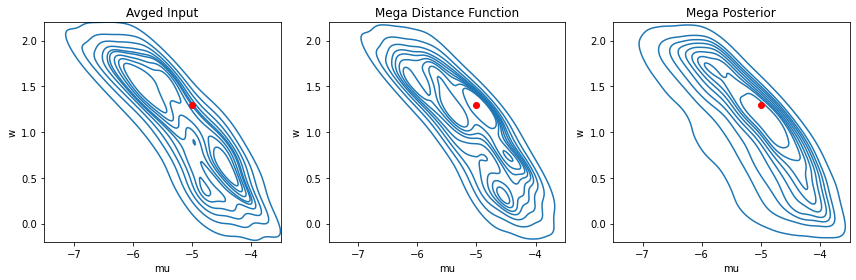

In [10]:
compare_methods(-5, 1.3, 0.001, data_size=10)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=390, start_time=2021-03-17 14:31:25.699718, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring from avgs


INFO:Epsilon:initial epsilon is 0.0018949999999999963
INFO:ABC:t: 0, eps: 0.0018949999999999963.
INFO:ABC:Acceptance rate: 1000 / 2006 = 4.9850e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00011000000000000002.
INFO:ABC:Acceptance rate: 1000 / 2051 = 4.8757e-01, ESS=9.4814e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=390, start_time=2021-03-17 14:31:25.699718, end_time=2021-03-17 14:31:34.795123)>


SMC run time:  9.14
Total number of SMC simulations:  5057


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=391, start_time=2021-03-17 14:31:35.628810, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.0033999999999999924
INFO:ABC:t: 0, eps: 0.0033999999999999924.
INFO:ABC:Acceptance rate: 1000 / 2081 = 4.8054e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00026000000000000003.
INFO:ABC:Acceptance rate: 1000 / 2059 = 4.8567e-01, ESS=9.5664e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=391, start_time=2021-03-17 14:31:35.628810, end_time=2021-03-17 14:31:44.767527)>


SMC run time:  9.18
Total number of SMC simulations:  5140


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=392, start_time=2021-03-17 14:31:45.628354, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Inferring with mega posterior


INFO:Epsilon:initial epsilon is 0.0022249999999999965
INFO:ABC:t: 0, eps: 0.0022249999999999965.
INFO:ABC:Acceptance rate: 1000 / 1933 = 5.1733e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00016.
INFO:ABC:Acceptance rate: 1000 / 1897 = 5.2715e-01, ESS=9.3586e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=392, start_time=2021-03-17 14:31:45.628354, end_time=2021-03-17 14:31:54.749413)>


SMC run time:  9.16
Total number of SMC simulations:  4830


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=393, start_time=2021-03-17 14:31:55.618270, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.001779999999999993
INFO:ABC:t: 0, eps: 0.001779999999999993.
INFO:ABC:Acceptance rate: 1000 / 1977 = 5.0582e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00011.
INFO:ABC:Acceptance rate: 1000 / 2026 = 4.9358e-01, ESS=9.5809e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=393, start_time=2021-03-17 14:31:55.618270, end_time=2021-03-17 14:32:04.808594)>


SMC run time:  9.23
Total number of SMC simulations:  5003


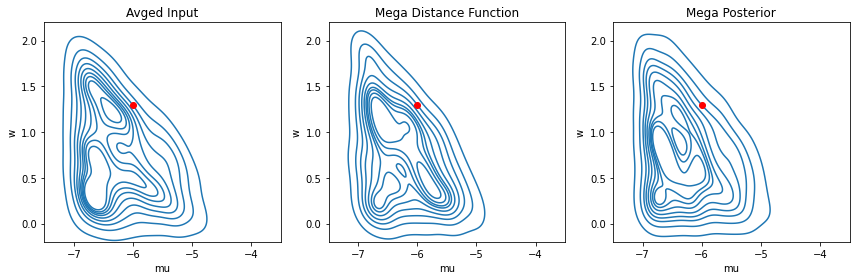

In [11]:
compare_methods(-6, 1.3, 0.001, data_size=2)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=215, start_time=2021-03-07 16:15:01.529122, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -5 and fitness 1.3


INFO:Epsilon:initial epsilon is 0.0016999999999999927
INFO:ABC:t: 0, eps: 0.0016999999999999927.
INFO:ABC:Acceptance rate: 1000 / 1959 = 5.1046e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00075.
INFO:ABC:Acceptance rate: 1000 / 2002 = 4.9950e-01, ESS=9.6206e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=215, start_time=2021-03-07 16:15:01.529122, end_time=2021-03-07 16:15:06.286158)>


SMC run time:  4.79
Total number of SMC simulations:  4961


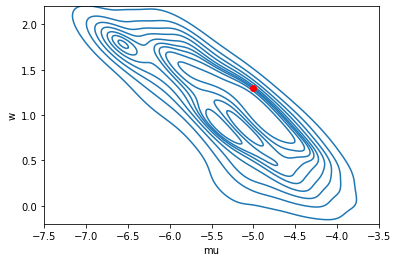

In [105]:
post = infer_megapost(-5, 1.3, 0.001, num_of_experiments=1)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=193, start_time=2021-03-07 15:10:53.282457, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
     0        1        2        3        4        5        6        7  \
0  0.0  0.00001  0.00005  0.00005  0.00004  0.00008  0.00010  0.00014   
1  0.0  0.00002  0.00004  0.00002  0.00005  0.00012  0.00012  0.00020   
2  0.0  0.00001  0.00001  0.00002  0.00010  0.00009  0.00006  0.00021   
3  0.0  0.00001  0.00000  0.00004  0.00005  0.00007  0.00019  0.00013   
4  0.0  0.00001  0.00006  0.00003  0.00003  0.00009  0.00009  0.00022   
5  0.0  0.00002  0.00000  0.00006  0.00008  0.00010  0.00016  0.00023   
6  0.0  0.00003  0.00003  0.00003  0.00004  0.00011  0.00015  0.00015   
7  0.0  0.00000  0.00003  0.00004  0.00005  0.00008  0.00016  0.00014   
8  0.0  0.00001  0.00001  0.00003  0.00003  0.00014  0.00014  0.00014   
9  0.0  0.00000  0.00000  0.00003  0.00009  0.00008  0.00012  0.00020   

         8        9  
0  0.00020  0.00040  
1  0.00020  0.00029  
2  0.00015  0.00042  
3  0.00019  0.00029  
4  0.00022  0.00029  
5  0.00023  0.00027  
6  0.00022  0.00045  


INFO:Epsilon:initial epsilon is 0.011844999999999996
INFO:ABC:t: 0, eps: 0.011844999999999996.
INFO:ABC:Acceptance rate: 1000 / 2057 = 4.8614e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.009749999999999998.
INFO:ABC:Acceptance rate: 1000 / 2095 = 4.7733e-01, ESS=9.5866e+02.
INFO:ABC:t: 2, eps: 0.00791.
INFO:ABC:Acceptance rate: 1000 / 2017 = 4.9579e-01, ESS=9.6285e+02.
INFO:ABC:t: 3, eps: 0.006099613475827024.
INFO:ABC:Acceptance rate: 1000 / 2158 = 4.6339e-01, ESS=9.7574e+02.
INFO:ABC:t: 4, eps: 0.00476.
INFO:ABC:Acceptance rate: 1000 / 2087 = 4.7916e-01, ESS=9.8907e+02.
INFO:ABC:t: 5, eps: 0.00406.
INFO:ABC:Acceptance rate: 1000 / 2106 = 4.7483e-01, ESS=9.8586e+02.
INFO:ABC:t: 6, eps: 0.0035900000000000003.
INFO:ABC:Acceptance rate: 1000 / 2392 = 4.1806e-01, ESS=9.7920e+02.
INFO:ABC:t: 7, eps: 0.0033300000000000005.
INFO:ABC:Acceptance rate: 1000 / 2631 = 3.8008e-01, ESS=9.2480e+02.
INFO:ABC:t: 8, eps: 0.0031499999999999996.
INFO:ABC:Acceptance rate: 1000 / 3573 = 2.7988e-01, ESS=8.071

SMC run time:  51.84
Total number of SMC simulations:  27451


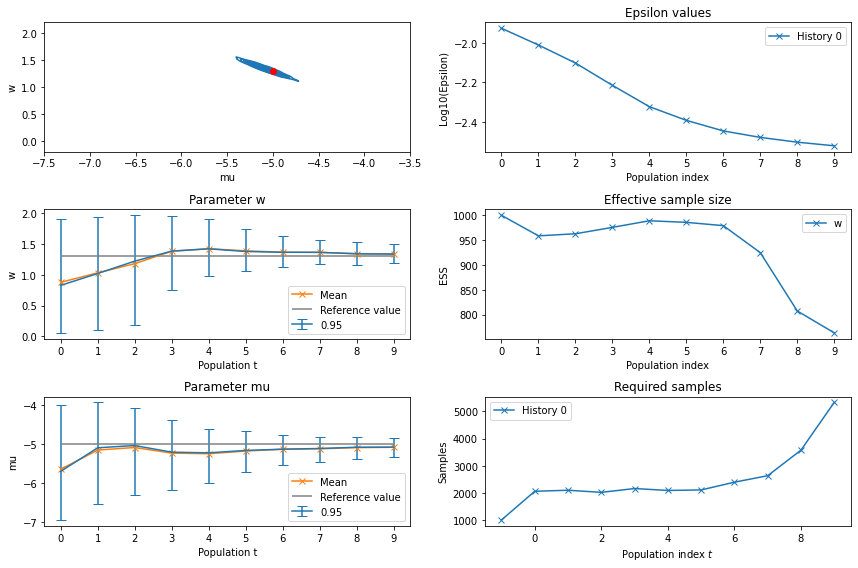

In [80]:
post = infer_megadist(-5, 1.3, 0.001, )

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=194, start_time=2021-03-07 15:13:07.801292, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -5 and fitness 1.3


INFO:Epsilon:initial epsilon is 0.001131199999999982
INFO:ABC:t: 0, eps: 0.001131199999999982.
INFO:ABC:Acceptance rate: 1000 / 2024 = 4.9407e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0009631999999999978.
INFO:ABC:Acceptance rate: 1000 / 2055 = 4.8662e-01, ESS=9.5755e+02.
INFO:ABC:t: 2, eps: 0.0007590000000000001.
INFO:ABC:Acceptance rate: 1000 / 2045 = 4.8900e-01, ESS=9.6151e+02.
INFO:ABC:t: 3, eps: 0.0005990000000000001.
INFO:ABC:Acceptance rate: 1000 / 2051 = 4.8757e-01, ESS=9.6596e+02.
INFO:ABC:t: 4, eps: 0.0004514641912808919.
INFO:ABC:Acceptance rate: 1000 / 2251 = 4.4425e-01, ESS=9.6489e+02.
INFO:ABC:t: 5, eps: 0.00034735415647094945.
INFO:ABC:Acceptance rate: 1000 / 2607 = 3.8358e-01, ESS=9.3850e+02.
INFO:ABC:t: 6, eps: 0.0002762.
INFO:ABC:Acceptance rate: 1000 / 3097 = 3.2289e-01, ESS=8.8782e+02.
INFO:ABC:t: 7, eps: 0.00023140000000000007.
INFO:ABC:Acceptance rate: 1000 / 4175 = 2.3952e-01, ESS=7.0232e+02.
INFO:ABC:t: 8, eps: 0.00019620000000000008.
INFO:ABC:Acceptance rate: 

SMC run time:  29.37
Total number of SMC simulations:  38878


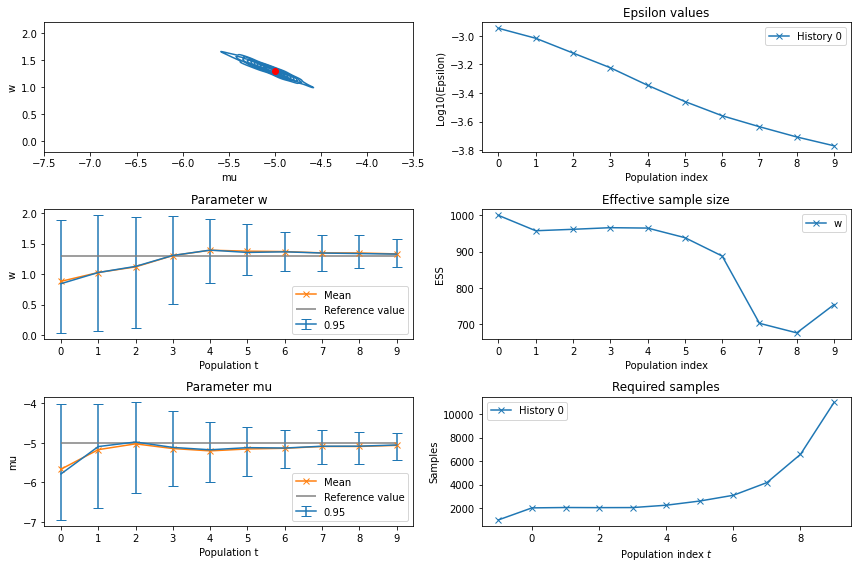

In [81]:
post = infer_avg_50(-5, 1.3, 0.0001)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=205, start_time=2021-03-07 15:19:08.950960, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -5 and fitness 1.3


INFO:Epsilon:initial epsilon is 0.00099
INFO:ABC:t: 0, eps: 0.00099.
INFO:ABC:Acceptance rate: 1000 / 2034 = 4.9164e-01, ESS=1.0000e+03.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=205, start_time=2021-03-07 15:19:08.950960, end_time=2021-03-07 15:19:11.475674)>


SMC run time:  2.55
Total number of SMC simulations:  3034


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=206, start_time=2021-03-07 15:19:11.918666, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.0011549999999999965
INFO:ABC:t: 0, eps: 0.0011549999999999965.
INFO:ABC:Acceptance rate: 1000 / 1899 = 5.2659e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0010400000000000001.
INFO:ABC:Acceptance rate: 1000 / 2104 = 4.7529e-01, ESS=9.2207e+02.
INFO:ABC:t: 2, eps: 0.00084.
INFO:ABC:Acceptance rate: 1000 / 2021 = 4.9480e-01, ESS=9.5467e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=206, start_time=2021-03-07 15:19:11.918666, end_time=2021-03-07 15:19:19.210050)>


SMC run time:  7.31
Total number of SMC simulations:  7025


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=207, start_time=2021-03-07 15:19:19.637644, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.001104999999999982
INFO:ABC:t: 0, eps: 0.001104999999999982.
INFO:ABC:Acceptance rate: 1000 / 1998 = 5.0050e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00093.
INFO:ABC:Acceptance rate: 1000 / 2038 = 4.9068e-01, ESS=9.5395e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=207, start_time=2021-03-07 15:19:19.637644, end_time=2021-03-07 15:19:24.354448)>


SMC run time:  4.74
Total number of SMC simulations:  5036


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=208, start_time=2021-03-07 15:19:24.810521, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.00103
INFO:ABC:t: 0, eps: 0.00103.
INFO:ABC:Acceptance rate: 1000 / 1936 = 5.1653e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00093.
INFO:ABC:Acceptance rate: 1000 / 2078 = 4.8123e-01, ESS=9.3283e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=208, start_time=2021-03-07 15:19:24.810521, end_time=2021-03-07 15:19:29.357271)>


SMC run time:  4.57
Total number of SMC simulations:  5014


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=209, start_time=2021-03-07 15:19:29.788408, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.0013349999999999963
INFO:ABC:t: 0, eps: 0.0013349999999999963.
INFO:ABC:Acceptance rate: 1000 / 1955 = 5.1151e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00085.
INFO:ABC:Acceptance rate: 1000 / 2027 = 4.9334e-01, ESS=9.7085e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=209, start_time=2021-03-07 15:19:29.788408, end_time=2021-03-07 15:19:34.488213)>


SMC run time:  4.72
Total number of SMC simulations:  4982


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=210, start_time=2021-03-07 15:19:34.928860, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.00118
INFO:ABC:t: 0, eps: 0.00118.
INFO:ABC:Acceptance rate: 1000 / 1899 = 5.2659e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0010799999999999998.
INFO:ABC:Acceptance rate: 1000 / 2042 = 4.8972e-01, ESS=9.3371e+02.
INFO:ABC:t: 2, eps: 0.0008799999999999999.
INFO:ABC:Acceptance rate: 1000 / 2097 = 4.7687e-01, ESS=9.6683e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=210, start_time=2021-03-07 15:19:34.928860, end_time=2021-03-07 15:19:42.062845)>


SMC run time:  7.16
Total number of SMC simulations:  7038


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=211, start_time=2021-03-07 15:19:42.526007, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.00098
INFO:ABC:t: 0, eps: 0.00098.
INFO:ABC:Acceptance rate: 1000 / 2003 = 4.9925e-01, ESS=1.0000e+03.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=211, start_time=2021-03-07 15:19:42.526007, end_time=2021-03-07 15:19:45.137759)>


SMC run time:  2.63
Total number of SMC simulations:  3003


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=212, start_time=2021-03-07 15:19:45.603770, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.0016699999999999998
INFO:ABC:t: 0, eps: 0.0016699999999999998.
INFO:ABC:Acceptance rate: 1000 / 1892 = 5.2854e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00107.
INFO:ABC:Acceptance rate: 1000 / 2135 = 4.6838e-01, ESS=9.4752e+02.
INFO:ABC:t: 2, eps: 0.0009.
INFO:ABC:Acceptance rate: 1000 / 2006 = 4.9850e-01, ESS=9.5152e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=212, start_time=2021-03-07 15:19:45.603770, end_time=2021-03-07 15:19:53.663966)>


SMC run time:  8.08
Total number of SMC simulations:  7033


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=213, start_time=2021-03-07 15:19:54.095739, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.00096
INFO:ABC:t: 0, eps: 0.00096.
INFO:ABC:Acceptance rate: 1000 / 2073 = 4.8239e-01, ESS=1.0000e+03.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=213, start_time=2021-03-07 15:19:54.095739, end_time=2021-03-07 15:19:56.776816)>


SMC run time:  2.7
Total number of SMC simulations:  3073


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=214, start_time=2021-03-07 15:19:57.228089, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.00102
INFO:ABC:t: 0, eps: 0.00102.
INFO:ABC:Acceptance rate: 1000 / 2024 = 4.9407e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0009299999999999999.
INFO:ABC:Acceptance rate: 1000 / 2061 = 4.8520e-01, ESS=9.4970e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=214, start_time=2021-03-07 15:19:57.228089, end_time=2021-03-07 15:20:02.522111)>


SMC run time:  5.32
Total number of SMC simulations:  5085


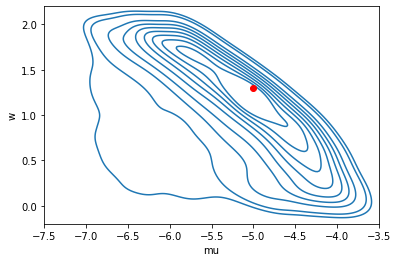

In [84]:
post = infer_megapost(-5, 1.3, 0.001, num_of_experiments=10)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=171, start_time=2021-03-07 14:55:31.960899, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -5 and fitness 1.3


INFO:Epsilon:initial epsilon is 0.00111
INFO:ABC:t: 0, eps: 0.00111.
INFO:ABC:Acceptance rate: 1000 / 1988 = 5.0302e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00085.
INFO:ABC:Acceptance rate: 1000 / 2031 = 4.9237e-01, ESS=9.5003e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=171, start_time=2021-03-07 14:55:31.960899, end_time=2021-03-07 14:55:36.344280)>


SMC run time:  4.41
Total number of SMC simulations:  5019


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=172, start_time=2021-03-07 14:55:36.760608, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.0011149999999999964
INFO:ABC:t: 0, eps: 0.0011149999999999964.
INFO:ABC:Acceptance rate: 1000 / 1992 = 5.0201e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0010299999999999999.
INFO:ABC:Acceptance rate: 1000 / 2013 = 4.9677e-01, ESS=9.4294e+02.
INFO:ABC:t: 2, eps: 0.0008600000000000001.
INFO:ABC:Acceptance rate: 1000 / 2194 = 4.5579e-01, ESS=9.3464e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=172, start_time=2021-03-07 14:55:36.760608, end_time=2021-03-07 14:55:43.467932)>


SMC run time:  6.73
Total number of SMC simulations:  7199


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=173, start_time=2021-03-07 14:55:43.872680, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.0013549999999999964
INFO:ABC:t: 0, eps: 0.0013549999999999964.
INFO:ABC:Acceptance rate: 1000 / 2018 = 4.9554e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00099.
INFO:ABC:Acceptance rate: 1000 / 1947 = 5.1361e-01, ESS=9.3370e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=173, start_time=2021-03-07 14:55:43.872680, end_time=2021-03-07 14:55:48.470778)>


SMC run time:  4.62
Total number of SMC simulations:  4965


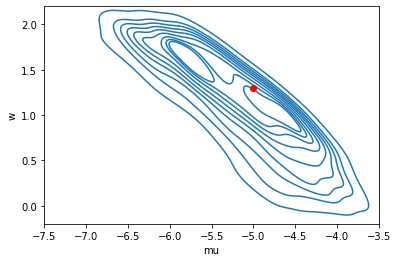

In [52]:
post = infer_megapost(-5, 1.3, 0.001, num_of_experiments=3)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=174, start_time=2021-03-07 14:56:17.915901, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -5 and fitness 1.3


INFO:Epsilon:initial epsilon is 0.00105
INFO:ABC:t: 0, eps: 0.00105.
INFO:ABC:Acceptance rate: 1000 / 1974 = 5.0659e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00094.
INFO:ABC:Acceptance rate: 1000 / 2185 = 4.5767e-01, ESS=9.5029e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=174, start_time=2021-03-07 14:56:17.915901, end_time=2021-03-07 14:56:22.521739)>


SMC run time:  4.63
Total number of SMC simulations:  5159


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=175, start_time=2021-03-07 14:56:22.938138, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.0013849999999999822
INFO:ABC:t: 0, eps: 0.0013849999999999822.
INFO:ABC:Acceptance rate: 1000 / 1946 = 5.1387e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00079.
INFO:ABC:Acceptance rate: 1000 / 2075 = 4.8193e-01, ESS=9.5567e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=175, start_time=2021-03-07 14:56:22.938138, end_time=2021-03-07 14:56:27.324948)>


SMC run time:  4.41
Total number of SMC simulations:  5021


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=176, start_time=2021-03-07 14:56:27.734906, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.00093
INFO:ABC:t: 0, eps: 0.00093.
INFO:ABC:Acceptance rate: 1000 / 2020 = 4.9505e-01, ESS=1.0000e+03.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=176, start_time=2021-03-07 14:56:27.734906, end_time=2021-03-07 14:56:30.082019)>


SMC run time:  2.37
Total number of SMC simulations:  3020


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=177, start_time=2021-03-07 14:56:30.497878, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.00094
INFO:ABC:t: 0, eps: 0.00094.
INFO:ABC:Acceptance rate: 1000 / 2040 = 4.9020e-01, ESS=1.0000e+03.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=177, start_time=2021-03-07 14:56:30.497878, end_time=2021-03-07 14:56:32.923332)>


SMC run time:  2.45
Total number of SMC simulations:  3040


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=178, start_time=2021-03-07 14:56:33.376501, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.00099
INFO:ABC:t: 0, eps: 0.00099.
INFO:ABC:Acceptance rate: 1000 / 2051 = 4.8757e-01, ESS=1.0000e+03.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=178, start_time=2021-03-07 14:56:33.376501, end_time=2021-03-07 14:56:35.818858)>


SMC run time:  2.47
Total number of SMC simulations:  3051


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=179, start_time=2021-03-07 14:56:36.255759, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.00134
INFO:ABC:t: 0, eps: 0.00134.
INFO:ABC:Acceptance rate: 1000 / 1868 = 5.3533e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00124.
INFO:ABC:Acceptance rate: 1000 / 2054 = 4.8685e-01, ESS=9.2380e+02.
INFO:ABC:t: 2, eps: 0.00103.
INFO:ABC:Acceptance rate: 1000 / 2172 = 4.6041e-01, ESS=9.4188e+02.
INFO:ABC:t: 3, eps: 0.00083.
INFO:ABC:Acceptance rate: 1000 / 2045 = 4.8900e-01, ESS=9.4723e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=179, start_time=2021-03-07 14:56:36.255759, end_time=2021-03-07 14:56:46.054034)>


SMC run time:  9.82
Total number of SMC simulations:  9139


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=180, start_time=2021-03-07 14:56:46.488952, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.00083
INFO:ABC:t: 0, eps: 0.00083.
INFO:ABC:Acceptance rate: 1000 / 2096 = 4.7710e-01, ESS=1.0000e+03.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=180, start_time=2021-03-07 14:56:46.488952, end_time=2021-03-07 14:56:49.150741)>


SMC run time:  2.68
Total number of SMC simulations:  3096


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=181, start_time=2021-03-07 14:56:49.596808, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.00125
INFO:ABC:t: 0, eps: 0.00125.
INFO:ABC:Acceptance rate: 1000 / 2026 = 4.9358e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00101.
INFO:ABC:Acceptance rate: 1000 / 1968 = 5.0813e-01, ESS=9.4625e+02.
INFO:ABC:t: 2, eps: 0.0008500000000000001.
INFO:ABC:Acceptance rate: 1000 / 2075 = 4.8193e-01, ESS=9.6160e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=181, start_time=2021-03-07 14:56:49.596808, end_time=2021-03-07 14:56:57.378606)>


SMC run time:  7.81
Total number of SMC simulations:  7069


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=182, start_time=2021-03-07 14:56:57.824945, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.001644999999999982
INFO:ABC:t: 0, eps: 0.001644999999999982.
INFO:ABC:Acceptance rate: 1000 / 1880 = 5.3191e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0010400000000000001.
INFO:ABC:Acceptance rate: 1000 / 1968 = 5.0813e-01, ESS=9.5601e+02.
INFO:ABC:t: 2, eps: 0.0008600000000000001.
INFO:ABC:Acceptance rate: 1000 / 2072 = 4.8263e-01, ESS=9.5551e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=182, start_time=2021-03-07 14:56:57.824945, end_time=2021-03-07 14:57:05.954473)>


SMC run time:  8.16
Total number of SMC simulations:  6920


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=183, start_time=2021-03-07 14:57:06.384950, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.0010349999999999964
INFO:ABC:t: 0, eps: 0.0010349999999999964.
INFO:ABC:Acceptance rate: 1000 / 2018 = 4.9554e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00089.
INFO:ABC:Acceptance rate: 1000 / 2102 = 4.7574e-01, ESS=9.5954e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=183, start_time=2021-03-07 14:57:06.384950, end_time=2021-03-07 14:57:11.651209)>


SMC run time:  5.29
Total number of SMC simulations:  5120


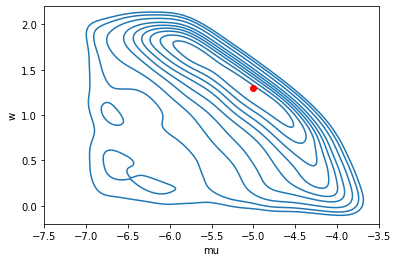

In [53]:
post = infer_megapost(-5, 1.3, 0.001, num_of_experiments=10)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=162, start_time=2021-03-07 14:29:02.194536, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -5.5 and fitness 1


INFO:Epsilon:initial epsilon is 0.0020927999999999945
INFO:ABC:t: 0, eps: 0.0020927999999999945.
INFO:ABC:Acceptance rate: 100 / 211 = 4.7393e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.0001412.
INFO:ABC:Acceptance rate: 100 / 198 = 5.0505e-01, ESS=9.1276e+01.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=162, start_time=2021-03-07 14:29:02.194536, end_time=2021-03-07 14:29:03.607122)>


SMC run time:  1.44
Total number of SMC simulations:  509


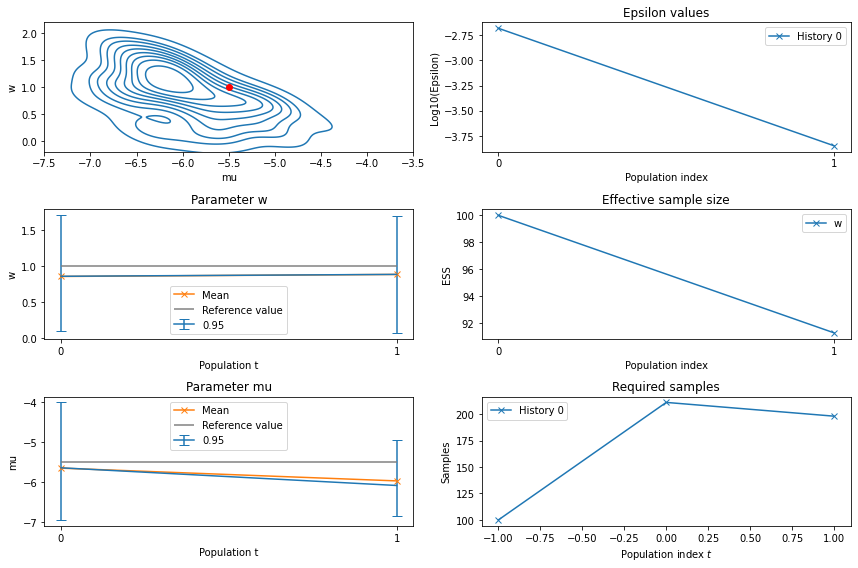

In [27]:
post = infer_avg_50(mr, w, 0.001, smc_population_size=100)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=161, start_time=2021-03-07 14:28:02.491885, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -5.5 and fitness 1


INFO:Epsilon:initial epsilon is 0.0032507999999999877
INFO:ABC:t: 0, eps: 0.0032507999999999877.
INFO:ABC:Acceptance rate: 100 / 197 = 5.0761e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.00013920000000000008.
INFO:ABC:Acceptance rate: 100 / 188 = 5.3191e-01, ESS=8.9381e+01.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=161, start_time=2021-03-07 14:28:02.491885, end_time=2021-03-07 14:28:04.013246)>


SMC run time:  1.55
Total number of SMC simulations:  485


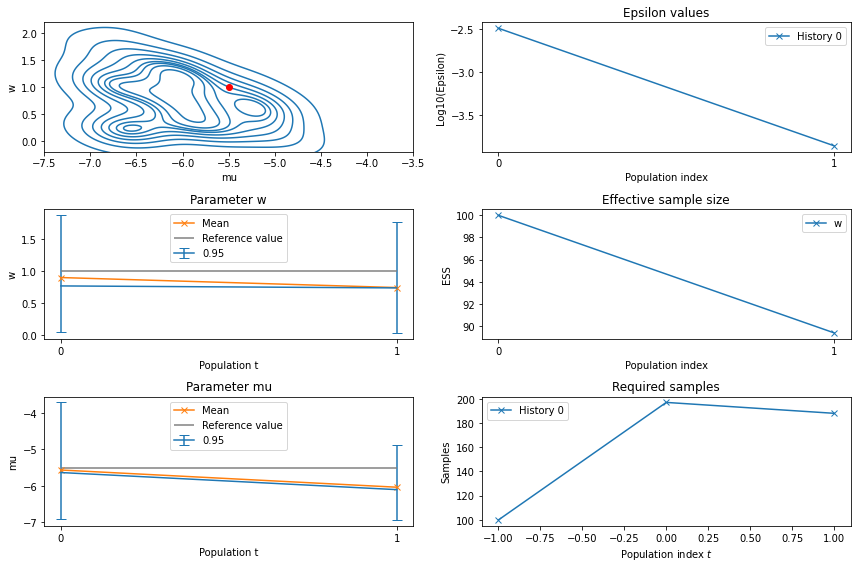

In [23]:
post = infer_avg_50(mr, w, 0.001, smc_population_size=100)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=160, start_time=2021-03-07 14:27:05.453031, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -5.5 and fitness 1


INFO:Epsilon:initial epsilon is 0.0015709999999999928
INFO:ABC:t: 0, eps: 0.0015709999999999928.
INFO:ABC:Acceptance rate: 1000 / 2034 = 4.9164e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00013900000000000007.
INFO:ABC:Acceptance rate: 1000 / 1614 = 6.1958e-01, ESS=9.5100e+02.
INFO:ABC:t: 2, eps: 0.00011900000000000007.
INFO:ABC:Acceptance rate: 1000 / 2211 = 4.5228e-01, ESS=9.2423e+02.
INFO:ABC:t: 3, eps: 9.819999999999997e-05.
INFO:ABC:Acceptance rate: 1000 / 2671 = 3.7439e-01, ESS=8.8305e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=160, start_time=2021-03-07 14:27:05.453031, end_time=2021-03-07 14:27:14.627568)>


SMC run time:  9.21
Total number of SMC simulations:  9530


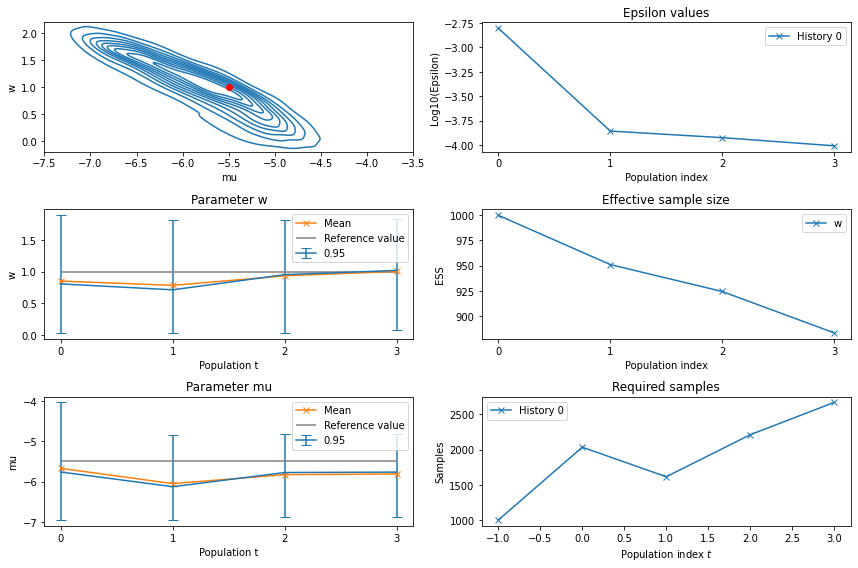

In [17]:
post = infer(mr, w, 0.0001, smc_population_size=1000)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=159, start_time=2021-03-07 12:52:20.607124, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -5.5 and fitness 1


INFO:Epsilon:initial epsilon is 0.0021963999999999964
INFO:ABC:t: 0, eps: 0.0021963999999999964.
INFO:ABC:Acceptance rate: 1000 / 2021 = 4.9480e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0001386000000000001.
INFO:ABC:Acceptance rate: 1000 / 1786 = 5.5991e-01, ESS=9.3580e+02.
INFO:ABC:t: 2, eps: 0.00011860000000000009.
INFO:ABC:Acceptance rate: 1000 / 2062 = 4.8497e-01, ESS=9.4777e+02.
INFO:ABC:t: 3, eps: 9.994135146373812e-05.
INFO:ABC:Acceptance rate: 1000 / 2565 = 3.8986e-01, ESS=8.6963e+02.
INFO:ABC:t: 4, eps: 8.740000000000001e-05.
INFO:ABC:Acceptance rate: 1000 / 3468 = 2.8835e-01, ESS=8.0399e+02.
INFO:ABC:t: 5, eps: 7.666369251772134e-05.
INFO:ABC:Acceptance rate: 1000 / 5607 = 1.7835e-01, ESS=7.8620e+02.
INFO:ABC:t: 6, eps: 6.860000000000004e-05.
INFO:ABC:Acceptance rate: 1000 / 8886 = 1.1254e-01, ESS=6.9388e+02.
INFO:ABC:t: 7, eps: 6.220000000000002e-05.
INFO:ABC:Acceptance rate: 1000 / 15655 = 6.3877e-02, ESS=5.0331e+02.
INFO:ABC:t: 8, eps: 5.6999999999999996e-05.
INFO:ABC:Acc

SMC run time:  64.26
Total number of SMC simulations:  125988


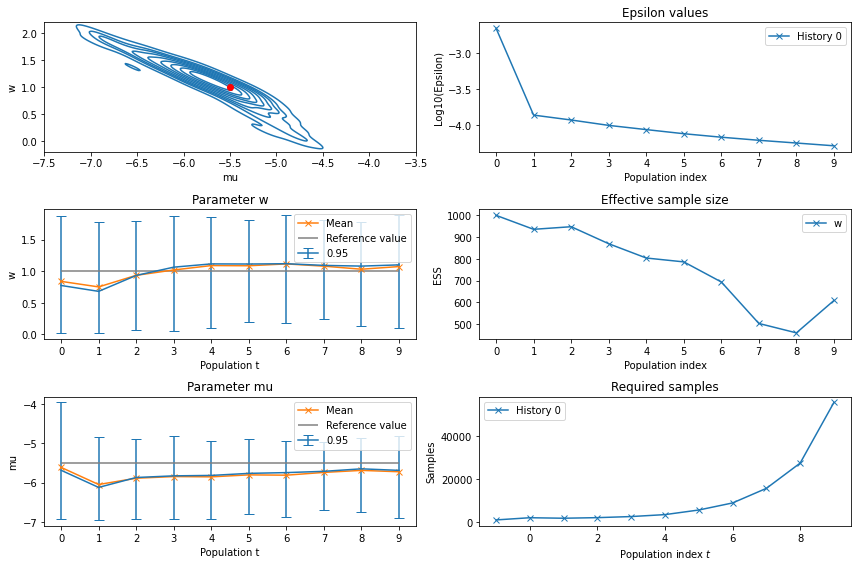

In [9]:
post = infer(mr, w, 0.00001, smc_population_size=1000)